# Inverse loss paper

# Initial predictions

## Preprocess

In [39]:
import os
# file_path = "C:/Users/hgp/Documents/bezerkeley/research/isol-sys-database/src/paper/"
# dir_path = os.path.dirname(file_path)
# os.chdir(dir_path)

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

plt.close('all')

main_obj = pd.read_pickle("../../data/loss/structural_db_complete_normloss.pickle")
    
main_obj.calculate_collapse()

df_raw = main_obj.ops_analysis
df_raw = df_raw.reset_index(drop=True)

# remove the singular outlier point
from scipy import stats
df = df_raw[np.abs(stats.zscore(df_raw['collapse_prob'])) < 5].copy()

# df = df.drop(columns=['index'])
# df = df_whole.head(100).copy()

df['max_isol_disp'] = pd.to_numeric(df['max_isol_disp'])
df['max_drift'] = df.PID.apply(max)
df['log_drift'] = np.log(df['max_drift'])

df['max_velo'] = df.PFV.apply(max)
df['max_accel'] = df.PFA.apply(max)

# df['T_ratio'] = df['T_m'] / df['T_fb']
df['T_ratio_e'] = df['T_m'] / df['T_fbe']
pi = 3.14159
g = 386.4

zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
df['Bm'] = np.interp(df['zeta_e'], zetaRef, BmRef)

df['gap_ratio'] = (df['constructed_moat']*4*pi**2)/ \
    (g*(df['sa_tm']/df['Bm'])*df['T_m']**2)

df['k2'] = (df['k_e']*df['D_m'] - df['Q'])/df['D_m']
df['k1'] = df['k_ratio'] * df['k2']

df['bldg_area'] = (df['num_bays']*df['L_bay'])**2 * (df['num_stories'] + 1)

df_loss = main_obj.loss_data

max_obj = pd.read_pickle("../../data/loss/structural_db_complete_max_loss.pickle")
df_loss_max = max_obj.max_loss

### Readjust for TFP

In [40]:
def wL_calc(num_stories, bldg_area):
    
    # in kip/ft^2
    LL_avg = (num_stories*50.0/1000 + 20.0/1000)/(num_stories + 1)
    W_L = LL_avg*bldg_area
    return W_L

def TFP_period_shift(W_D, W_L, bearing):
    # shift assumes that the load case is 1.0D + 0.5L
    if bearing == 'TFP':
        return (W_D/(W_D+0.5*W_L))**0.5
    else:
        return 1.0

df['W_L'] = df.apply(lambda x: wL_calc(x['num_stories'], x['bldg_area']), axis=1)
df['Tshift_coef'] = df.apply(
    lambda x: TFP_period_shift(x['W'], x['W_L'], x['isolator_system']), axis=1)

df['T_M_adj'] = pd.to_numeric(df['T_m'] * df['Tshift_coef'])

df['T_ratio'] = pd.to_numeric(df['T_M_adj']/df['T_fb'])

from gms import get_ST


df['sa_tm_adj'] = df.apply(
    lambda x: get_ST(x, x['T_M_adj'],
                      db_dir='../../resource/ground_motions/gm_db.csv',
                      spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
    axis=1)

df['GR_OG'] = pd.to_numeric((df['constructed_moat']*4*pi**2)/ \
    (g*(df['sa_tm']/df['Bm'])*df['T_m']**2))
    
df['gap_ratio'] = pd.to_numeric((df['constructed_moat']*4*pi**2)/ \
    (g*(df['sa_tm_adj']/df['Bm'])*df['T_M_adj']**2))
    
df['GR_shift_coef'] = pd.to_numeric(df['gap_ratio'])/pd.to_numeric(df['GR_OG'])
# df['GR-Ad_coef'] = pd.to_numeric(df['GR_OG'])/pd.to_numeric(df['moat_ampli'])
df['sa_tm_shift'] = pd.to_numeric(df['sa_tm_adj']/df['sa_tm'])


## Main predictor function

In [41]:

def predict_DV(X, impact_pred_mdl, hit_loss_mdl, miss_loss_mdl,
               outcome='cost_50%', return_var=False):
    """Returns the expected value of the decision variable based on the total
    probability law (law of iterated expectation).
    
    E[cost] = sum_i sum_j E[cost|impact_j] Pr(impact_j) 
    
    Currently, this assumes that the models used are all GPC/GPR.
    
    Parameters
    ----------
    X: pd dataframe of design points
    impact_pred_mdl: classification model predicting impact
    hit_loss_mdl: regression model predicting outcome conditioned on yes impact
    miss_loss_mdl: regression model predicting outcome conditioned on no impact
    outcome: desired name for outcome variable
    
    Returns
    -------
    expected_DV_df: DataFrame of expected DV with single column name outcome+'_pred'
    """
        
    # get probability of impact
    if 'log_reg_kernel' in impact_pred_mdl.named_steps.keys():
        probs_imp = impact_pred_mdl.predict_proba(impact_pred_mdl.K_pr)
    else:
        probs_imp = impact_pred_mdl.predict_proba(X)

    miss_prob = probs_imp[:,0]
    hit_prob = probs_imp[:,1]
    
    hit_loss, hit_std = hit_loss_mdl.predict(X, return_std=True)
    miss_loss, miss_std = miss_loss_mdl.predict(X, return_std=True)
    
    # weight with probability of collapse
    # E[Loss] = (impact loss)*Pr(impact) + (no impact loss)*Pr(no impact)
    # run SVR_hit model on this dataset
    outcome_str = outcome+'_pred'
    expected_DV_hit = pd.DataFrame(
            {outcome_str:np.multiply(
                    hit_loss,
                    hit_prob)})
            
    
    # run miss model on this dataset
    expected_DV_miss = pd.DataFrame(
            {outcome_str:np.multiply(
                    miss_loss,
                    miss_prob)})
    
    expected_DV = expected_DV_hit + expected_DV_miss
    
    # tower variance
    # Var[cost] = E[cost^2] - E[cost]^2 = E[E(cost^2|imp)] - expected_DV^2
    # = (hit_cost^2 + var_hit_cost)*p(hit) + (miss_cost^2 + var_miss_cost)*p(miss) - expected_DV^2
    '''
    if return_var:
        expected_loss_sq = (hit_std**2 + hit_loss**2)*hit_prob + (miss_std**2 + miss_loss**2)*miss_prob
        total_var = expected_loss_sq - expected_DV**2
        return(expected_DV, total_var)
    '''
    
    if return_var:
        # get probability of impact
        gpc_obj = impact_pred_mdl._final_estimator
        base_estimator = gpc_obj.base_estimator_
        K_func = base_estimator.kernel_
        W_inv = np.diag(1/base_estimator.W_sr_**2)
        K_a = K_func(base_estimator.X_train_, base_estimator.X_train_)
        R_inv = np.linalg.inv(W_inv + K_a)
        
        # follow Eq. 3.24 to calculate latent variance
        gpc_scaler = impact_pred_mdl[0]
        X_scaled = gpc_scaler.transform(X)
        K_s = K_func(base_estimator.X_train_, X_scaled)
        k_ss = np.diagonal(K_func(X_scaled, X_scaled))
        var_f = k_ss - np.sum((R_inv @ K_s) * K_s, axis=0)
        
        # propagate uncertainty (Wikipedia example for f = ae^(bA)) and f = aA^b
        pi_ = base_estimator.pi_
        y_train_ = base_estimator.y_train_
        f_star = K_s.T.dot(y_train_ - pi_)
        gamma_ = (1 + np.exp(-f_star))
        prob_var = np.exp(-2*f_star)*var_f/(gamma_**4)
        
        # regression model variances
        hit_var = hit_std**2
        miss_var = miss_std**2
        
        # for now, ignore correlation
        # is there correlation? is probability of impact correlated with cost given that the building impacted
        # propagate uncertainty (f = AB)
        
        if miss_loss < 1e-8:
            miss_loss_min = 1e-3
        else:
            miss_loss_min = miss_loss
            
        impact_side_var = np.multiply(hit_loss, hit_prob)**2*(
            (hit_var/hit_loss**2) + (prob_var/hit_prob**2) + 0)
        
        nonimpact_side_var = np.multiply(miss_loss_min, miss_prob)**2*(
            (miss_var/miss_loss_min**2) + (prob_var/miss_prob**2) + 0)
        
        # propagate uncertainty (f = A + B)
        total_var = impact_side_var + nonimpact_side_var + 0
        
        return(expected_DV, total_var)
    else:
        return(expected_DV)
    

### Other utility functions

In [42]:
# make a generalized 2D plotting grid, defaulted to gap and Ry
# grid is based on the bounds of input data
def make_2D_plotting_space(X, res, x_var='gap_ratio', y_var='RI', 
                           all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                           third_var_set = None, fourth_var_set = None,
                           x_bounds=None, y_bounds=None):
    if x_bounds == None:
        x_min = min(X[x_var])
        x_max = max(X[x_var])
    else:
        x_min = x_bounds[0]
        x_max = x_bounds[1]
    if y_bounds == None:
        y_min = min(X[y_var])
        y_max = max(X[y_var])
    else:
        y_min = y_bounds[0]
        y_max = y_bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min,
                                     x_max,
                                     res),
                         np.linspace(y_min,
                                     y_max,
                                     res))

    rem_vars = [i for i in all_vars if i not in [x_var, y_var]]
    third_var = rem_vars[0]
    fourth_var = rem_vars[-1]
       
    # xx = xx
    # yy = yy
    
    if third_var_set is None:
        third_var_val= X[third_var].median()
    else:
        third_var_val = third_var_set
    if fourth_var_set is None:
        fourth_var_val = X[fourth_var].median()
    else:
        fourth_var_val = fourth_var_set
    
    
    X_pl = pd.DataFrame({x_var:xx.ravel(),
                         y_var:yy.ravel(),
                         third_var:np.repeat(third_var_val,
                                             res*res),
                         fourth_var:np.repeat(fourth_var_val, 
                                              res*res)})
    X_plot = X_pl[all_vars]
                         
    return(X_plot)

def make_design_space(res, var_list=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                      fixed_var=None, bound_dict=None):
    
    if bound_dict is None:
        bound_dict = {
            'gap_ratio': (0.6, 2.0),
            'RI': (0.5, 2.25),
            'T_ratio': (2.0, 11.0),
            'zeta_e': (0.1, 0.25),
            'k_ratio': (5.0, 12.0)}
    
    fixed_val = {
        'gap_ratio': 1.0,
        'RI': 2.0,
        'T_ratio': 4.0,
        'zeta_e': 0.15,
        'k_ratio': 10.0
        }
    
    if fixed_var is None:
        xx, yy, uu, vv = np.meshgrid(np.linspace(*bound_dict[var_list[0]], res),
                                     np.linspace(*bound_dict[var_list[1]], res),
                                     np.linspace(*bound_dict[var_list[2]], res),
                                     np.linspace(*bound_dict[var_list[3]], res))
        
        X_space = pd.DataFrame({var_list[0]:xx.ravel(),
                             var_list[1]:yy.ravel(),
                             var_list[2]:uu.ravel(),
                             var_list[3]:vv.ravel()})
    else:
        fixed_val_single = fixed_val[fixed_var]
        excluded_idx = var_list.index(fixed_var)
        my_args = tuple(np.linspace(*bound_dict[var_list[i]], res) 
                                    for i in range(len(var_list)) 
                                    if i!=excluded_idx)
        
        xx, yy, uu, vv = np.meshgrid(*my_args,
                                     fixed_val_single)
        
        var_list.pop(excluded_idx)
        
        # TODO: this is unordered
        X_space = pd.DataFrame({var_list[0]:xx.ravel(),
                             var_list[1]:yy.ravel(),
                             var_list[2]:uu.ravel(),
                             fixed_var:vv.ravel()})
    return(X_space)

def moment_frame_cost(df, steel_per_unit=1.25):
    n_bays = df.num_bays
    
    # ft
    L_beam = df.L_bay
    h_story = df.h_story
    
    all_beams = df.beam
    all_cols = df.column
    
    # sum of per-length-weight of all floors
    col_wt = [float(member.split('X',1)[1]) for member in all_cols]
    beam_wt = [float(member.split('X',1)[1]) for member in all_beams] 
    
    # col_all_wt = np.array(list(map(sum, col_wt)))
    # beam_all_wt = np.array(list(map(sum, beam_wt)))
    
    # only 2 lateral frames
    n_frames = 4
    n_cols = 4*n_bays
    
    floor_col_length = np.array(n_cols*h_story, dtype=float)
    floor_beam_length = np.array(L_beam * n_bays * n_frames, dtype=float)
        
    floor_col_wt = col_wt*floor_col_length 
    floor_beam_wt = beam_wt*floor_beam_length
    
    bldg_wt = sum(floor_col_wt) + sum(floor_beam_wt)
    
    steel_cost = steel_per_unit*bldg_wt
    return(steel_cost)

def braced_frame_cost(df, brace_db, steel_per_unit=1.25):
    n_bays = df.num_bays
    
    # ft
    L_beam = df.L_bay
    h_story = df.h_story
    n_stories = df.num_stories
    
    from math import atan, cos
    theta = atan(h_story/(L_beam/2))
    L_brace = (L_beam/2)/cos(theta)
    
    all_beams = df.beam
    all_cols = df.column
    all_braces = df.brace
    
    n_braced = int(round(n_bays/2.25))
    n_braced = max(n_braced, 1)
    
    # sum of per-length-weight of all floors
    col_wt = [float(member.split('X',1)[1]) for member in all_cols]
    beam_wt = [float(member.split('X',1)[1]) for member in all_beams] 
    brace_wt = [brace_db.loc[brace_db['AISC_Manual_Label'] == brace_name]['W'].item() 
                    for brace_name in all_braces]
    
    # only 2 lateral frames
    n_frames = 4
    
    # in CBF, only count the big frames
    n_cols = 4*(n_braced+1)
    
    floor_col_length = np.array(n_cols*h_story, dtype=float)
    floor_beam_length = np.array(L_beam * n_braced * n_frames, dtype=float)
    floor_brace_length = np.array(L_brace * n_braced * n_frames, dtype=float)
    
    n_every_col = 4*n_bays
    full_frame_col_length = np.array(n_every_col*h_story, dtype=float)
    full_frame_beam_length = np.array(L_beam * n_bays * n_frames, dtype=float)
    grav_col_length = full_frame_col_length - floor_col_length
    grav_beam_length = full_frame_beam_length - floor_beam_length
    
    # assume W14x120 grav columns, W16x31 beams
    grav_col_wt = np.repeat(120.0, n_stories)*grav_col_length
    grav_beam_wt = np.repeat(31.0, n_stories)*grav_beam_length
    
    floor_col_wt = col_wt*floor_col_length 
    floor_beam_wt = beam_wt*floor_beam_length
    floor_brace_wt = brace_wt*floor_brace_length
    
    bldg_wt = (sum(floor_col_wt) + sum(floor_beam_wt) + sum(floor_brace_wt) +
               sum(grav_col_wt) + sum(grav_beam_wt))
    
    steel_cost = steel_per_unit*bldg_wt
    
    return(steel_cost)

# calc cost of existing db
def calc_steel_cost(df, brace_db, steel_per_unit=1.25):
    superstructure_system = df.superstructure_system
    
    if superstructure_system == 'MF':
        return moment_frame_cost(df, steel_per_unit=steel_per_unit)
    else:
        return braced_frame_cost(df, brace_db, steel_per_unit=steel_per_unit)

## Loss definitions

In [43]:

def loss_percentages(df_main, df_loss, df_max):
    df_main['bldg_area'] = df_main['L_bldg']**2 * (df_main['num_stories'] + 1)

    df_main['replacement_cost'] = 600.0*(df_main['bldg_area'])
    df_main['total_cmp_cost'] = df_max['cost_50%']
    df_main['cmp_replace_cost_ratio'] = df_main['total_cmp_cost']/df_main['replacement_cost']
    df_main['median_cost_ratio'] = df_loss['cost_50%']/df_main['replacement_cost']
    df_main['cmp_cost_ratio'] = df_loss['cost_50%']/df_main['total_cmp_cost']

    # but working in parallel (2x faster)
    df_main['replacement_time'] = df_main['bldg_area']/1000*365
    df_main['total_cmp_time'] = df_max['time_l_50%']
    df_main['cmp_replace_time_ratio'] = df_main['total_cmp_time']/df_main['replacement_time']
    df_main['median_time_ratio'] = df_loss['time_l_50%']/df_main['replacement_time']
    df_main['cmp_time_ratio'] = df_loss['time_l_50%']/df_main['total_cmp_time']

    df_main['replacement_freq'] = df_loss['replacement_freq']

    df_main[['B_50%', 'C_50%', 'D_50%', 'E_50%']] = df_loss[['B_50%', 'C_50%', 'D_50%', 'E_50%']]

    df_main['impacted'] = pd.to_numeric(df_main['impacted'])

    mask = df_loss['B_50%'].isnull()

    df_main['B_50%'].loc[mask] = df_max['B_50%'].loc[mask]
    df_main['C_50%'].loc[mask] = df_max['C_50%'].loc[mask]
    df_main['D_50%'].loc[mask] = df_max['D_50%'].loc[mask]
    df_main['E_50%'].loc[mask] = df_max['E_50%'].loc[mask]
    
    return(df_main)
    
df = loss_percentages(df, df_loss, df_loss_max)

cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']

db_string = '../../resource/'
brace_db = pd.read_csv(db_string+'braceShapes.csv', index_col=None, header=0)  

land_cost_per_sf = 2837/(3.28**2)

df['land_area'] = (df['L_bldg']*12 + df['constructed_moat'])**2
df['land_cost'] = land_cost_per_sf/144.0 * df['land_area']

df['steel_cost'] = df.apply(
       lambda row: calc_steel_cost(
           row, brace_db=brace_db,
           steel_per_unit=1.25),
       axis='columns', result_type='expand')

df['steel_cost_per_sf'] = df['steel_cost'] / df['bldg_area']

df['upfront_cost_per_sf'] = (df['steel_cost'] + df['land_cost'])/df['bldg_area']
df['upfront_cost_per_sm'] = df['upfront_cost_per_sf'] * 3.28**2
# df['upfront_cost_per_sf'] = df['steel_cost']/df['bldg_area'] + df['land_cost']/df['land_area']

df['system'] = df['superstructure_system'] +'-' + df['isolator_system']


## Subsetting

In [44]:

df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]
df_mf_i = df_mf[df_mf['impacted'] == 1]
df_cbf_i = df_cbf[df_cbf['impacted'] == 1]

df_tfp_o = df_tfp[df_tfp['impacted'] == 0]
df_lrb_o = df_lrb[df_lrb['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

## Impact classification

In [45]:
# for each system, make separate impact classification model

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)

mdl_impact_cbf_lrb = GP(df_cbf_lrb)
mdl_impact_cbf_lrb.set_covariates(covariate_list)
mdl_impact_cbf_lrb.set_outcome('impacted')
mdl_impact_cbf_lrb.test_train_split(0.2)

mdl_impact_cbf_tfp = GP(df_cbf_tfp)
mdl_impact_cbf_tfp.set_covariates(covariate_list)
mdl_impact_cbf_tfp.set_outcome('impacted')
mdl_impact_cbf_tfp.test_train_split(0.2)

mdl_impact_mf_lrb = GP(df_mf_lrb)
mdl_impact_mf_lrb.set_covariates(covariate_list)
mdl_impact_mf_lrb.set_outcome('impacted')
mdl_impact_mf_lrb.test_train_split(0.2)

mdl_impact_mf_tfp = GP(df_mf_tfp)
mdl_impact_mf_tfp.set_covariates(covariate_list)
mdl_impact_mf_tfp.set_outcome('impacted')
mdl_impact_mf_tfp.test_train_split(0.2)

print('======= impact classification per system ========')
import time
t0 = time.time()

mdl_impact_cbf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_cbf_tfp.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_tfp.fit_gpc(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPC training for impact done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

# mdl_impact_mf_lrb.fit_kde()
# mdl_impact_cbf_lrb.fit_kde()
# mdl_impact_mf_tfp.fit_kde()
# mdl_impact_cbf_tfp.fit_kde()

mdl_impact_mf_lrb.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_cbf_lrb.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_mf_tfp.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_cbf_tfp.fit_kde(bandwidth_range=np.logspace(-3,1,20))

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


impact_classification_mdls = {'mdl_impact_cbf_lrb': mdl_impact_cbf_lrb,
                        'mdl_impact_cbf_tfp': mdl_impact_cbf_tfp,
                        'mdl_impact_mf_lrb': mdl_impact_mf_lrb,
                        'mdl_impact_mf_tfp': mdl_impact_mf_tfp}

======= impact classification per system ========
The GP training score is 0.773
The GP testing score is 0.797
The GP training score is 0.783
The GP testing score is 0.714
The GP training score is 0.786
The GP testing score is 0.797
The GP training score is 0.824
The GP testing score is 0.762
GPC training for impact done for 4 models in 0.406 s
======= Density estimation per system ========
KDE training done for 4 models in 1.311 s


## Regressions

In [46]:
#%% regression models: cost
# goal: E[cost|sys=sys, impact=impact]

mdl_cost_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_cost_cbf_lrb_i.set_covariates(covariate_list)
mdl_cost_cbf_lrb_i.set_outcome(cost_var)
mdl_cost_cbf_lrb_i.test_train_split(0.2)

mdl_cost_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_cost_cbf_lrb_o.set_covariates(covariate_list)
mdl_cost_cbf_lrb_o.set_outcome(cost_var)
mdl_cost_cbf_lrb_o.test_train_split(0.2)

mdl_cost_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_cost_cbf_tfp_i.set_covariates(covariate_list)
mdl_cost_cbf_tfp_i.set_outcome(cost_var)
mdl_cost_cbf_tfp_i.test_train_split(0.2)

mdl_cost_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_cost_cbf_tfp_o.set_covariates(covariate_list)
mdl_cost_cbf_tfp_o.set_outcome(cost_var)
mdl_cost_cbf_tfp_o.test_train_split(0.2)

mdl_cost_mf_lrb_i = GP(df_mf_lrb_i)
mdl_cost_mf_lrb_i.set_covariates(covariate_list)
mdl_cost_mf_lrb_i.set_outcome(cost_var)
mdl_cost_mf_lrb_i.test_train_split(0.2)

mdl_cost_mf_lrb_o = GP(df_mf_lrb_o)
mdl_cost_mf_lrb_o.set_covariates(covariate_list)
mdl_cost_mf_lrb_o.set_outcome(cost_var)
mdl_cost_mf_lrb_o.test_train_split(0.2)

mdl_cost_mf_tfp_i = GP(df_mf_tfp_i)
mdl_cost_mf_tfp_i.set_covariates(covariate_list)
mdl_cost_mf_tfp_i.set_outcome(cost_var)
mdl_cost_mf_tfp_i.test_train_split(0.2)

mdl_cost_mf_tfp_o = GP(df_mf_tfp_o)
mdl_cost_mf_tfp_o.set_covariates(covariate_list)
mdl_cost_mf_tfp_o.set_outcome(cost_var)
mdl_cost_mf_tfp_o.test_train_split(0.2)

print('======= cost regression per system per impact ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 8 models in %.3f s" % tp)

cost_regression_mdls = {'mdl_cost_cbf_lrb_i': mdl_cost_cbf_lrb_i,
                        'mdl_cost_cbf_lrb_o': mdl_cost_cbf_lrb_o,
                        'mdl_cost_cbf_tfp_i': mdl_cost_cbf_tfp_i,
                        'mdl_cost_cbf_tfp_o': mdl_cost_cbf_tfp_o,
                        'mdl_cost_mf_lrb_i': mdl_cost_mf_lrb_i,
                        'mdl_cost_mf_lrb_o': mdl_cost_mf_lrb_o,
                        'mdl_cost_mf_tfp_i': mdl_cost_mf_tfp_i,
                        'mdl_cost_mf_tfp_o': mdl_cost_mf_tfp_o}

#%% regression models: time
# goal: E[time|sys=sys, impact=impact]

mdl_time_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_time_cbf_lrb_i.set_covariates(covariate_list)
mdl_time_cbf_lrb_i.set_outcome(time_var)
mdl_time_cbf_lrb_i.test_train_split(0.2)

mdl_time_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_time_cbf_lrb_o.set_covariates(covariate_list)
mdl_time_cbf_lrb_o.set_outcome(time_var)
mdl_time_cbf_lrb_o.test_train_split(0.2)

mdl_time_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_time_cbf_tfp_i.set_covariates(covariate_list)
mdl_time_cbf_tfp_i.set_outcome(time_var)
mdl_time_cbf_tfp_i.test_train_split(0.2)

mdl_time_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_time_cbf_tfp_o.set_covariates(covariate_list)
mdl_time_cbf_tfp_o.set_outcome(time_var)
mdl_time_cbf_tfp_o.test_train_split(0.2)

mdl_time_mf_lrb_i = GP(df_mf_lrb_i)
mdl_time_mf_lrb_i.set_covariates(covariate_list)
mdl_time_mf_lrb_i.set_outcome(time_var)
mdl_time_mf_lrb_i.test_train_split(0.2)

mdl_time_mf_lrb_o = GP(df_mf_lrb_o)
mdl_time_mf_lrb_o.set_covariates(covariate_list)
mdl_time_mf_lrb_o.set_outcome(time_var)
mdl_time_mf_lrb_o.test_train_split(0.2)

mdl_time_mf_tfp_i = GP(df_mf_tfp_i)
mdl_time_mf_tfp_i.set_covariates(covariate_list)
mdl_time_mf_tfp_i.set_outcome(time_var)
mdl_time_mf_tfp_i.test_train_split(0.2)

mdl_time_mf_tfp_o = GP(df_mf_tfp_o)
mdl_time_mf_tfp_o.set_covariates(covariate_list)
mdl_time_mf_tfp_o.set_outcome(time_var)
mdl_time_mf_tfp_o.test_train_split(0.2)

print('======= downtime regression per system per impact ========')
import time
t0 = time.time()

mdl_time_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 8 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb_i': mdl_time_cbf_lrb_i,
                        'mdl_time_cbf_lrb_o': mdl_time_cbf_lrb_o,
                        'mdl_time_cbf_tfp_i': mdl_time_cbf_tfp_i,
                        'mdl_time_cbf_tfp_o': mdl_time_cbf_tfp_o,
                        'mdl_time_mf_lrb_i': mdl_time_mf_lrb_i,
                        'mdl_time_mf_lrb_o': mdl_time_mf_lrb_o,
                        'mdl_time_mf_tfp_i': mdl_time_mf_tfp_i,
                        'mdl_time_mf_tfp_o': mdl_time_mf_tfp_o}

#%% regression models: repl
# goal: E[repl|sys=sys, impact=impact]

mdl_repl_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_repl_cbf_lrb_i.set_covariates(covariate_list)
mdl_repl_cbf_lrb_i.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_i.test_train_split(0.2)

mdl_repl_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_repl_cbf_lrb_o.set_covariates(covariate_list)
mdl_repl_cbf_lrb_o.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_o.test_train_split(0.2)

mdl_repl_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_repl_cbf_tfp_i.set_covariates(covariate_list)
mdl_repl_cbf_tfp_i.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_i.test_train_split(0.2)

mdl_repl_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_repl_cbf_tfp_o.set_covariates(covariate_list)
mdl_repl_cbf_tfp_o.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_o.test_train_split(0.2)

mdl_repl_mf_lrb_i = GP(df_mf_lrb_i)
mdl_repl_mf_lrb_i.set_covariates(covariate_list)
mdl_repl_mf_lrb_i.set_outcome('replacement_freq')
mdl_repl_mf_lrb_i.test_train_split(0.2)

mdl_repl_mf_lrb_o = GP(df_mf_lrb_o)
mdl_repl_mf_lrb_o.set_covariates(covariate_list)
mdl_repl_mf_lrb_o.set_outcome('replacement_freq')
mdl_repl_mf_lrb_o.test_train_split(0.2)

mdl_repl_mf_tfp_i = GP(df_mf_tfp_i)
mdl_repl_mf_tfp_i.set_covariates(covariate_list)
mdl_repl_mf_tfp_i.set_outcome('replacement_freq')
mdl_repl_mf_tfp_i.test_train_split(0.2)

mdl_repl_mf_tfp_o = GP(df_mf_tfp_o)
mdl_repl_mf_tfp_o.set_covariates(covariate_list)
mdl_repl_mf_tfp_o.set_outcome('replacement_freq')
mdl_repl_mf_tfp_o.test_train_split(0.2)

t0 = time.time()

print('======= replacement regression per system per impact ========')

mdl_repl_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_mf_lrb_i.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_mf_lrb_o.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_mf_tfp_i.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)
mdl_repl_mf_tfp_o.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2),
                         const_lower_bound=1e-10)

tp = time.time() - t0

print("GPR training for replacement done for 8 models in %.3f s" % tp)

repl_regression_mdls = {'mdl_repl_cbf_lrb_i': mdl_repl_cbf_lrb_i,
                        'mdl_repl_cbf_lrb_o': mdl_repl_cbf_lrb_o,
                        'mdl_repl_cbf_tfp_i': mdl_repl_cbf_tfp_i,
                        'mdl_repl_cbf_tfp_o': mdl_repl_cbf_tfp_o,
                        'mdl_repl_mf_lrb_i': mdl_repl_mf_lrb_i,
                        'mdl_repl_mf_lrb_o': mdl_repl_mf_lrb_o,
                        'mdl_repl_mf_tfp_i': mdl_repl_mf_tfp_i,
                        'mdl_repl_mf_tfp_o': mdl_repl_mf_tfp_o}

# moment frames that do not impact the wall do not have high replacement


======= cost regression per system per impact ========
GPR training for cost done for 8 models in 1.846 s
======= downtime regression per system per impact ========
GPR training for time done for 8 models in 1.768 s
======= replacement regression per system per impact ========


c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR training for replacement done for 8 models in 1.804 s


# Plots

## Collapse definitions

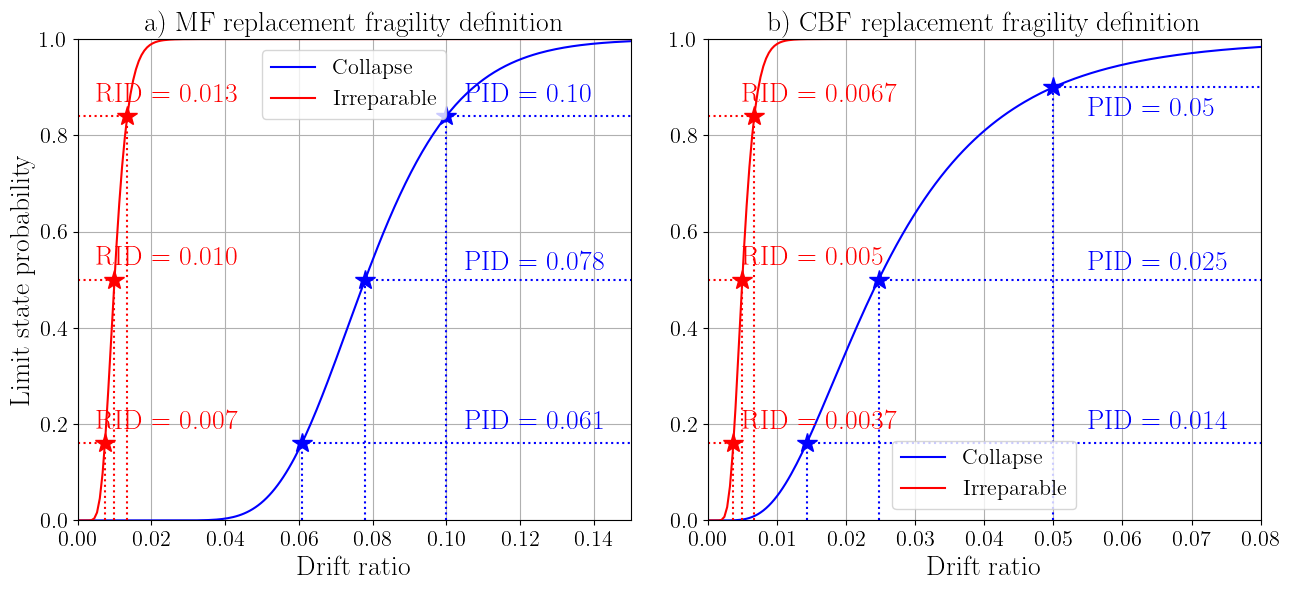

In [47]:

# TODO: definitions
import numpy as np
from scipy.stats import norm
inv_norm = norm.ppf(0.84)
# collapse as a probability
from scipy.stats import lognorm
from math import log, exp

plt.rcParams["text.usetex"] = True
x = np.linspace(0, 0.15, 200)
mu = log(0.1)- 0.25*inv_norm
sigma = 0.25

ln_dist = lognorm(s=sigma, scale=exp(mu))
p = ln_dist.cdf(np.array(x))

# plt.close('all')
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 1)
# ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(x, p, label='Collapse', color='blue')

mu_irr = log(0.01)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

ax.plot(x, p_irr, color='red', label='Irreparable')

axis_font = 20
subt_font = 18
xleft = 0.15
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
ax.set_ylabel('Limit state probability', fontsize=axis_font)
ax.set_xlabel('Drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=exp(mu), xmax=0.15, color='blue', linestyle=":")
ax.text(0.105, 0.52, r'PID = 0.078', fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

ax.vlines(x=0.1, ymin=0, ymax=0.84, color='blue', linestyle=":")
ax.hlines(y=0.84, xmin=0.1, xmax=xleft, color='blue', linestyle=":")
ax.text(0.105, 0.87, r'PID = 0.10', fontsize=axis_font, color='blue')
ax.plot([0.10], [0.84], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=lower, xmax=xleft, color='blue', linestyle=":")
ax.text(0.105, 0.19, r'PID = 0.061', fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


ax.hlines(y=0.5, xmin=0.0, xmax=exp(mu_irr), color='red', linestyle=":")
lower = ln_dist_irr.ppf(0.16)
ax.hlines(y=0.16, xmin=0.0, xmax=lower, color='red', linestyle=":")
upper = ln_dist_irr.ppf(0.84)
ax.hlines(y=0.84, xmin=0.0, xmax=upper, color='red', linestyle=":")
ax.plot([lower], [0.16], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([0.01], [0.5], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([upper], [0.84], marker='*', markersize=15, color="red", linestyle=":")
ax.vlines(x=upper, ymin=0, ymax=0.84, color='red', linestyle=":")
ax.vlines(x=0.01, ymin=0, ymax=0.5, color='red', linestyle=":")
ax.vlines(x=lower, ymin=0, ymax=0.16, color='red', linestyle=":")

ax.text(0.005, 0.19, r'RID = 0.007', fontsize=axis_font, color='red')
ax.text(0.005, 0.87, r'RID = 0.013', fontsize=axis_font, color='red')
ax.text(0.005, 0.53, r'RID = 0.010', fontsize=axis_font, color='red')

ax.set_title('a) MF replacement fragility definition', fontsize=axis_font)
ax.grid()
label_size = 16
clabel_size = 12

ax.legend(fontsize=label_size, loc='upper center')

# cbf
inv_norm = norm.ppf(0.9)
# collapse as a probability

x = np.linspace(0, 0.08, 200)
mu = log(0.05)- 0.55*inv_norm
sigma = 0.55;

ln_dist = lognorm(s=sigma, scale=exp(mu))
p = ln_dist.cdf(np.array(x))

# plt.close('all')
ax = fig.add_subplot(1, 2, 2)

ax.plot(x, p, label='Collapse', color='blue')

mu_irr = log(0.005)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

ax.plot(x, p_irr, color='red', label='Irreparable')

axis_font = 20
subt_font = 18
xleft = 0.08
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
# ax.set_ylabel('Limit state probability', fontsize=axis_font)
ax.set_xlabel('Drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=exp(mu), xmax=0.15, color='blue', linestyle=":")
ax.text(0.055, 0.52, r'PID = 0.025', fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

ax.vlines(x=0.05, ymin=0, ymax=0.9, color='blue', linestyle=":")
ax.hlines(y=0.9, xmin=0.05, xmax=xleft, color='blue', linestyle=":")
ax.text(0.055, 0.84, r'PID = 0.05', fontsize=axis_font, color='blue')
ax.plot([0.05], [0.9], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=lower, xmax=xleft, color='blue', linestyle=":")
ax.text(0.055, 0.19, r'PID = 0.014', fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


ax.hlines(y=0.5, xmin=0.0, xmax=exp(mu_irr), color='red', linestyle=":")
lower = ln_dist_irr.ppf(0.16)
ax.hlines(y=0.16, xmin=0.0, xmax=lower, color='red', linestyle=":")
upper = ln_dist_irr.ppf(0.84)
ax.hlines(y=0.84, xmin=0.0, xmax=upper, color='red', linestyle=":")
ax.plot([lower], [0.16], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([0.005], [0.5], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([upper], [0.84], marker='*', markersize=15, color="red", linestyle=":")
ax.vlines(x=upper, ymin=0, ymax=0.84, color='red', linestyle=":")
ax.vlines(x=0.005, ymin=0, ymax=0.5, color='red', linestyle=":")
ax.vlines(x=lower, ymin=0, ymax=0.16, color='red', linestyle=":")

ax.text(0.005, 0.19, r'RID = 0.0037', fontsize=axis_font, color='red')
ax.text(0.005, 0.87, r'RID = 0.0067', fontsize=axis_font, color='red')
ax.text(0.005, 0.53, r'RID = 0.005', fontsize=axis_font, color='red')

ax.set_title('b) CBF replacement fragility definition', fontsize=axis_font)
ax.grid()
label_size = 16
clabel_size = 12

ax.legend(fontsize=label_size, loc='lower center')
fig.tight_layout()
plt.show()
# plt.savefig('./eng_struc_figures/replacement_def.eps')

## Impact difference

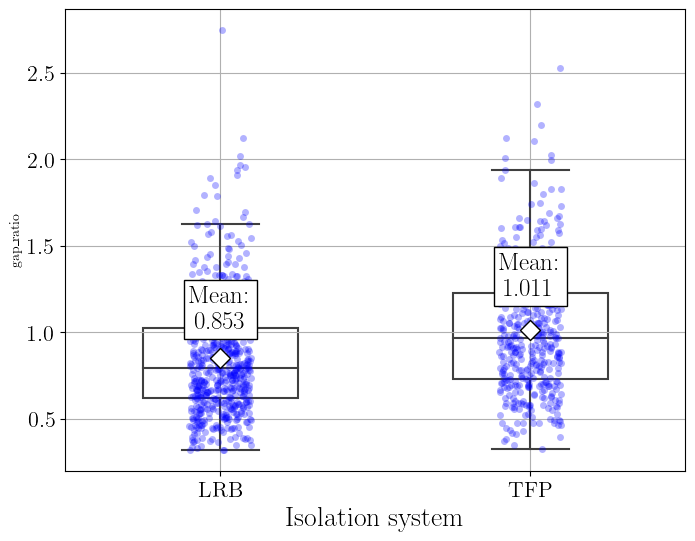

In [48]:
# plt.figure(figsize=(8,6))
# plt.scatter(df['gap_ratio'], df['T_ratio'])
# # plt.xlim([0.5,2.0])
# # plt.ylim([0.5, 2.25])
# plt.xlabel('$GR$', fontsize=axis_font)
# plt.ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# plt.grid(True)
# # plt.title('Collapse risk using full 400 points', fontsize=axis_font)
# plt.show()

from scipy import stats
# df_test = df[np.abs(stats.zscore(df['max_isol_disp'])) < 1.].copy()
# df_test = df[df['impacted'] == 0]
df_test = df.copy()
df_tfp_test = df_test[df_test['isolator_system'] == 'TFP']
df_lrb_test = df_test[df_test['isolator_system'] == 'LRB']
# df_test = df.copy()
plt.close('all')
fig = plt.figure(figsize=(8,6))
import seaborn as sns
my_var = 'gap_ratio'
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor='white', zorder=20)
ax = fig.add_subplot(1, 1, 1)
bx = sns.boxplot(y=my_var, x= "isolator_system", data=df_test,  showfliers=False,
            boxprops={'facecolor': 'none'},showmeans=True, meanprops=meanpointprops,
            width=0.5, ax=ax)
sp = sns.stripplot(x='isolator_system', y=my_var, data=df_test, ax=ax, jitter=True,
              alpha=0.3, s=5, color='blue')

val = df_tfp_test[my_var].mean()
ax.text(1, val*1.2, f'Mean: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
# ax.annotate("", (0, val),(0.25, 0.45),  arrowprops={'arrowstyle':'->'})

val = df_lrb_test[my_var].mean()
ax.text(0, val*1.2, f'Mean: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
# ax.annotate("", (1, val),(0.85, 0.45),  arrowprops={'arrowstyle':'->'})
# ax.set_zlim([-0.05, 0.2])
# ax.set_ylim([0, 40.])
ax.grid('True', zorder=0)
plt.xlabel('Isolation system', fontsize=axis_font)
# plt.ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
plt.show()

In [49]:

# import numpy as np
# import statsmodels.api as sm
# my_var = 'k2'
# var_array = df_tfp_test[my_var]
# var_array_2 = df_lrb_test[my_var]
# # plt.close('all')
# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(1, 2, 1)
# sm.qqplot(var_array, line='45', loc=np.mean(var_array), scale=np.std(var_array), ax=ax)
# ax.set_title('TFPs')
# # plt.show()
# ax = fig.add_subplot(1, 2, 2)
# sm.qqplot(var_array_2, line='45', loc=np.mean(var_array), scale=np.std(var_array), ax=ax)
# ax.set_title('LRBs')
# plt.show()


## EDP results

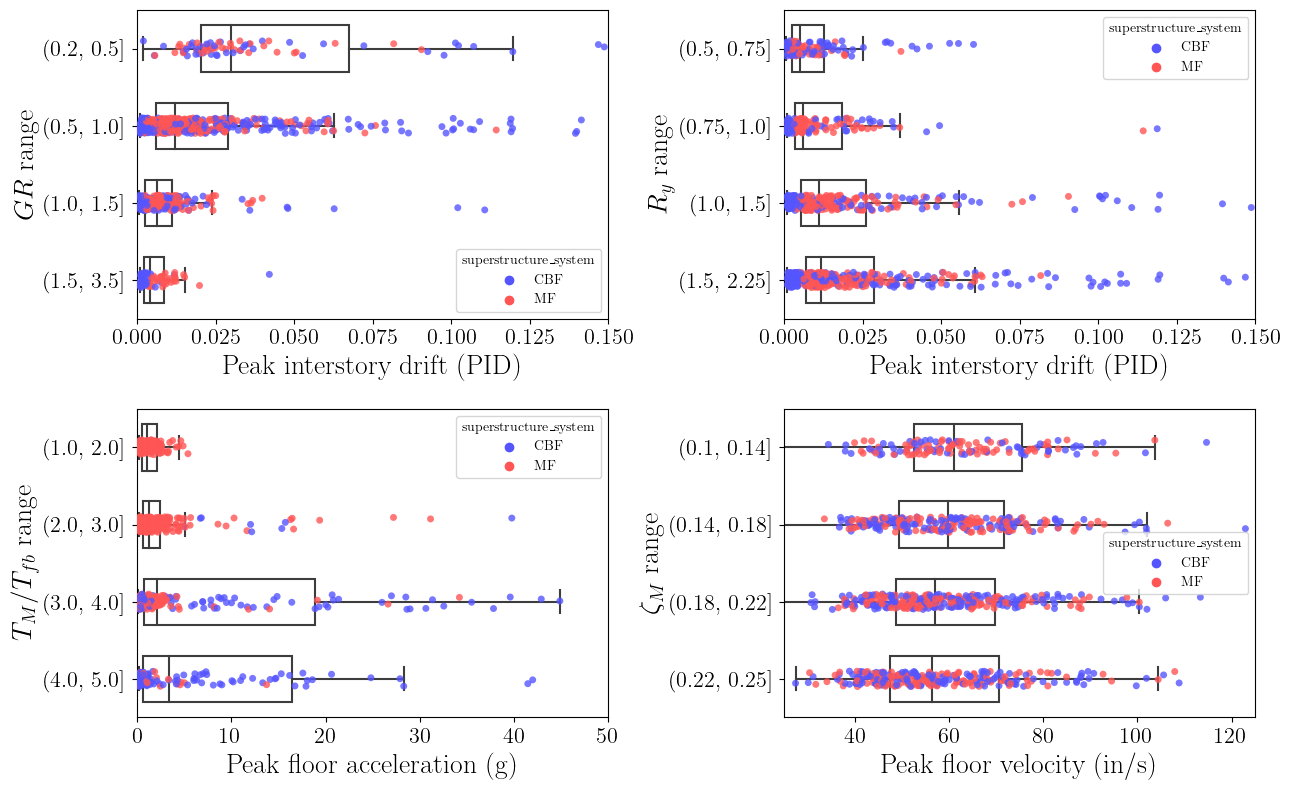

In [50]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 20
subt_font = 18
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# plt.close('all')
fig = plt.figure(figsize=(13, 8))

bins = pd.IntervalIndex.from_tuples([(0.2, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 3.5)])
labels=['tiny', 'small', 'okay', 'large']
df['bin'] = pd.cut(df['gap_ratio'], bins=bins, labels=labels)


ax = fig.add_subplot(2, 2, 1)
import seaborn as sns
sns.stripplot(data=df, x="max_drift", y="bin", orient="h", alpha=0.8, size=5,
              hue='superstructure_system', ax=ax, legend='brief', palette='seismic')
sns.boxplot(y="bin", x= "max_drift", data=df,  showfliers=False,
            boxprops={'facecolor': 'none'}, meanprops={'color': 'black'},
            width=0.6, ax=ax)

ax.set_ylabel('$GR$ range', fontsize=axis_font)
ax.set_xlabel('Peak interstory drift (PID)', fontsize=axis_font)
plt.xlim([0.0, 0.15])

#####
bins = pd.IntervalIndex.from_tuples([(0.5, 0.75), (0.75, 1.0), (1.0, 1.5), (1.5, 2.25)])
labels=['tiny', 'small', 'okay', 'large']
df['bin'] = pd.cut(df['RI'], bins=bins, labels=labels)


ax = fig.add_subplot(2, 2, 2)
import seaborn as sns
sns.stripplot(data=df, x="max_drift", y="bin", orient="h", size=5, alpha=0.8,
              hue='superstructure_system', ax=ax, legend='brief', palette='seismic')
sns.boxplot(y="bin", x= "max_drift", data=df,  showfliers=False,
            boxprops={'facecolor': 'none'}, meanprops={'color': 'black'},
            width=0.6, ax=ax)


ax.set_ylabel('$R_y$ range', fontsize=axis_font)
ax.set_xlabel('Peak interstory drift (PID)', fontsize=axis_font)
plt.xlim([0.0, 0.15])



#####
bins = pd.IntervalIndex.from_tuples([(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0)])
labels=['tiny', 'small', 'okay', 'large']
df['bin'] = pd.cut(df['T_ratio'], bins=bins, labels=labels)


ax = fig.add_subplot(2, 2, 3)
import seaborn as sns
sns.stripplot(data=df, x="max_accel", y="bin", orient="h", size=5, alpha=0.8,
              hue='superstructure_system', ax=ax, legend='brief', palette='seismic')
sns.boxplot(y="bin", x= "max_accel", data=df,  showfliers=False,
            boxprops={'facecolor': 'none'}, meanprops={'color': 'black'},
            width=0.6, ax=ax)


ax.set_ylabel('$T_M/T_{fb}$ range', fontsize=axis_font)
ax.set_xlabel('Peak floor acceleration (g)', fontsize=axis_font)
plt.xlim([0.0, 50.0])

#####
bins = pd.IntervalIndex.from_tuples([(0.1, 0.14), (0.14, 0.18), (0.18, 0.22), (0.22, 0.25)])
labels=['tiny', 'small', 'okay', 'large']
df['bin'] = pd.cut(df['zeta_e'], bins=bins, labels=labels)


ax = fig.add_subplot(2, 2, 4)
import seaborn as sns
sns.stripplot(data=df, x="max_velo", y="bin", orient="h", size=5, alpha=0.8,
              hue='superstructure_system', ax=ax, legend='brief', palette='seismic')
sns.boxplot(y="bin", x= "max_velo", data=df,  showfliers=False,
            boxprops={'facecolor': 'none'}, meanprops={'color': 'black'},
            width=0.6, ax=ax)


ax.set_ylabel('$\zeta_M$ range', fontsize=axis_font)
ax.set_xlabel('Peak floor velocity (in/s)', fontsize=axis_font)
plt.xlim([25, 125.0])
fig.tight_layout(h_pad=2.0)
plt.show()

## Scatterhist

(0.1, 0.25)

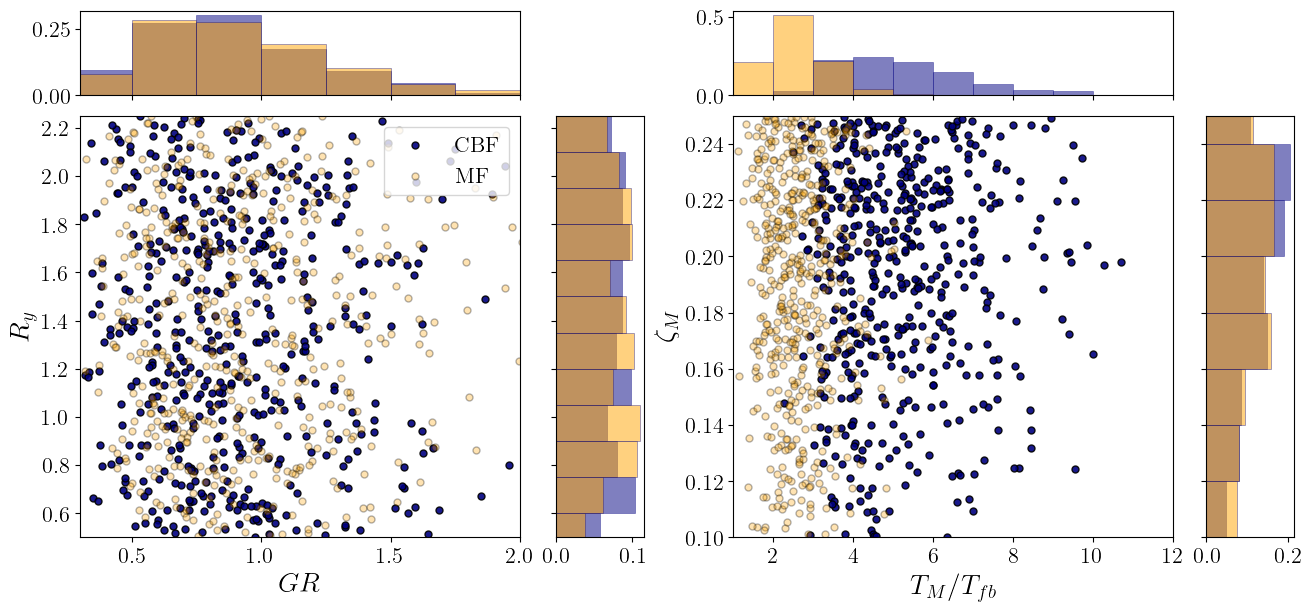

In [51]:
# TODO: scatterhist

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
               label=label)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    if y.name == 'zeta_e':
        binwidth = 0.02
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    elif y.name == 'RI':
        binwidth = 0.15
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    elif y.name=='T_ratio' or y.name=='T_ratio_e' or 'k_ratio':
        binwidth = 1.0
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    if x.name == 'Q':
        binwidth = 0.01
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_x = np.arange(-lim, lim + binwidth, binwidth)
    elif x.name == 'T_ratio' or x.name=='T_ratio_e':
        binwidth = 1.0
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_x = np.arange(-lim, lim + binwidth, binwidth)
    else:
        bin_x = bins
    ax_histx.hist(x, bins=bin_x, alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)
    ax_histy.hist(y, bins=bin_y, orientation='horizontal', alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 20
subt_font = 18
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df_cbf['gap_ratio'], df_cbf['RI'], 'navy', 0.9, ax, ax_histx, ax_histy,
             label='CBF')
scatter_hist(df_mf['gap_ratio'], df_mf['RI'], 'orange', 0.3, ax, ax_histx, ax_histy,
             label='MF')
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_xlim([0.3, 2.0])
ax.set_ylim([0.5, 2.25])
ax.legend(fontsize=label_size)

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df_cbf['T_ratio'], df_cbf['zeta_e'], 'navy', 0.9, ax, ax_histx, ax_histy)
scatter_hist(df_mf['T_ratio'], df_mf['zeta_e'], 'orange', 0.3, ax, ax_histx, ax_histy)

ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)
ax.set_xlim([1.0, 12.0])
ax.set_ylim([0.1, 0.25])

# plt.savefig('./eng_struc_figures/input_scatterhist.pdf')

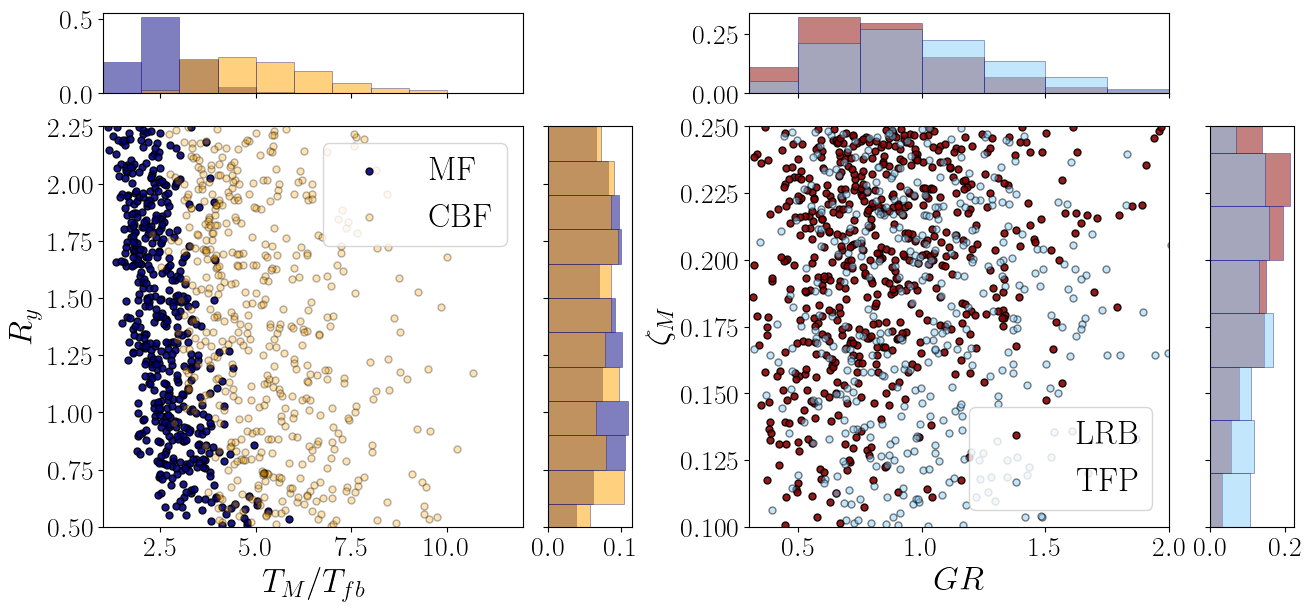

In [52]:

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
                label=label)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    if y.name == 'zeta_e':
        binwidth = 0.02
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    elif y.name == 'RI':
        binwidth = 0.15
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    elif y.name=='T_ratio' or y.name=='T_ratio_e' or 'k_ratio':
        binwidth = 1.0
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
        
    if x.name == 'Q':
        binwidth = 0.01
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_x = np.arange(-lim, lim + binwidth, binwidth)
    elif x.name == 'T_ratio' or x.name=='T_ratio_e':
        binwidth = 1.0
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_x = np.arange(-lim, lim + binwidth, binwidth)
    else:
        bin_x = bins
    ax_histx.hist(x, bins=bin_x, alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)
    ax_histy.hist(y, bins=bin_y, orientation='horizontal', alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df_mf['T_ratio'], df_mf['RI'], 'navy', 0.9, ax, ax_histx, ax_histy,
             label='MF')
scatter_hist(df_cbf['T_ratio'], df_cbf['RI'], 'orange', 0.3, ax, ax_histx, ax_histy,
             label='CBF')
ax.legend(fontsize=axis_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_xlim([1.0, 12.0])
ax.set_ylim([0.5, 2.25])

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df_lrb['gap_ratio'], df_lrb['zeta_e'], 'darkred', 0.9, ax, ax_histx, ax_histy,
              label='LRB')
scatter_hist(df_tfp['gap_ratio'], df_tfp['zeta_e'], 'lightskyblue', 0.5, ax, ax_histx, ax_histy,
              label='TFP')
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)
ax.set_xlim([0.3, 2.0])
ax.set_ylim([0.1, 0.25])

ax.legend(fontsize=axis_font)

# plt.savefig('./eng_struc_figures/input_scatterhist_mix.pdf')

## Non impact DVs

c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


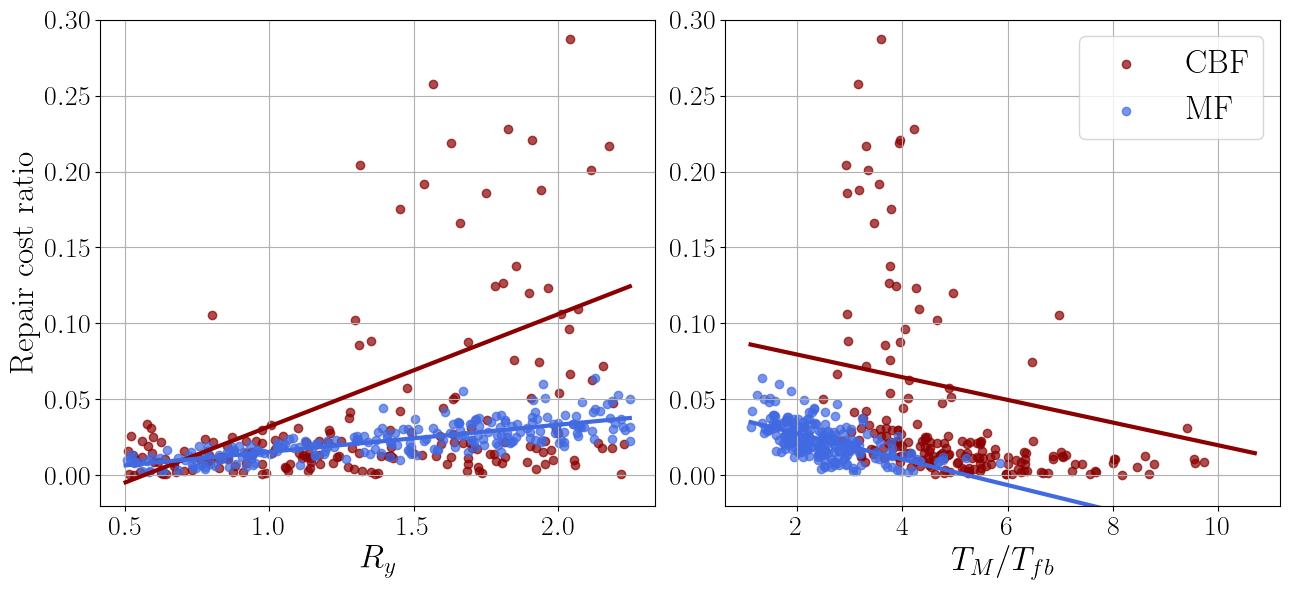

In [53]:

mf_tfp_color = 'royalblue'
mf_lrb_color = 'cornflowerblue'
cbf_tfp_color = 'darkred'
cbf_lrb_color = 'firebrick'

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 20
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')
fig = plt.figure(figsize=(13, 6))
cmap = plt.cm.tab10

from sklearn import linear_model
regr = linear_model.LinearRegression()

# ax = fig.add_subplot(2, 2, 3)
# xvar = 'gap_ratio'
# x_1d = np.linspace(df[xvar].min(), df[xvar].max(), 200).reshape(-1, 1)
# ax.scatter(df_cbf_o[xvar], df_cbf_o[cost_var], alpha=0.7, color=cbf_tfp_color, label='CBF')
# regr.fit(df_cbf_o[[xvar]], df_cbf_o[[cost_var]])
# y_pred = regr.predict(x_1d)
# plt.plot(x_1d, y_pred, color=cbf_tfp_color, linewidth=3)

# ax.scatter(df_mf_o[xvar], df_mf_o[cost_var], alpha=0.7, color=mf_tfp_color, label='MF')
# regr.fit(df_mf_o[[xvar]], df_mf_o[[cost_var]])
# y_pred = regr.predict(x_1d)
# plt.plot(x_1d, y_pred, color=mf_tfp_color, linewidth=3)
# ax.set_xlabel("$GR$", fontsize=axis_font)

# ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
# ax.set_ylim([-0.02, 0.3])
# ax.grid()

ax = fig.add_subplot(1, 2, 1)
xvar = 'RI'
x_1d = np.linspace(df[xvar].min(), df[xvar].max(), 200).reshape(-1, 1)
ax.scatter(df_cbf_o[xvar], df_cbf_o[cost_var], alpha=0.7, color=cbf_tfp_color, label='CBF')
regr.fit(df_cbf_o[[xvar]], df_cbf_o[[cost_var]])
y_pred = regr.predict(x_1d)
plt.plot(x_1d, y_pred, color=cbf_tfp_color, linewidth=3)

ax.scatter(df_mf_o[xvar], df_mf_o[cost_var], alpha=0.7, color=mf_tfp_color, label='MF')
regr.fit(df_mf_o[[xvar]], df_mf_o[[cost_var]])
y_pred = regr.predict(x_1d)
plt.plot(x_1d, y_pred, color=mf_tfp_color, linewidth=3)
ax.set_xlabel("$R_y$", fontsize=axis_font)
ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
ax.set_ylim([-0.02, 0.3])
ax.grid()


ax = fig.add_subplot(1, 2, 2)
xvar = 'T_ratio'
x_1d = np.linspace(df[xvar].min(), df[xvar].max(), 200).reshape(-1, 1)
ax.scatter(df_cbf_o[xvar], df_cbf_o[cost_var], alpha=0.7, color=cbf_tfp_color, label='CBF')
regr.fit(df_cbf_o[[xvar]], df_cbf_o[[cost_var]])
y_pred = regr.predict(x_1d)
plt.plot(x_1d, y_pred, color=cbf_tfp_color, linewidth=3)

ax.scatter(df_mf_o[xvar], df_mf_o[cost_var], alpha=0.7, color=mf_tfp_color, label='MF')
regr.fit(df_mf_o[[xvar]], df_mf_o[[cost_var]])
y_pred = regr.predict(x_1d)
plt.plot(x_1d, y_pred, color=mf_tfp_color, linewidth=3)
ax.set_xlabel("$T_M/T_{fb}$", fontsize=axis_font)
ax.set_ylim([-0.02, 0.3])
ax.grid()

ax.legend(fontsize=axis_font, loc='upper right')
# ax = fig.add_subplot(2, 2, 4)
# xvar = 'zeta_e'
# x_1d = np.linspace(df[xvar].min(), df[xvar].max(), 200).reshape(-1, 1)
# ax.scatter(df_cbf_o[xvar], df_cbf_o[cost_var], alpha=0.7, color=cbf_tfp_color, label='CBF')
# regr.fit(df_cbf_o[[xvar]], df_cbf_o[[cost_var]])
# y_pred = regr.predict(x_1d)
# plt.plot(x_1d, y_pred, color=cbf_tfp_color, linewidth=3)

# ax.scatter(df_mf_o[xvar], df_mf_o[cost_var], alpha=0.7, color=mf_tfp_color, label='MF')
# regr.fit(df_mf_o[[xvar]], df_mf_o[[cost_var]])
# y_pred = regr.predict(x_1d)
# plt.plot(x_1d, y_pred, color=mf_tfp_color, linewidth=3)
# ax.set_xlabel("$\zeta_M$", fontsize=axis_font)
# ax.set_ylim([-0.02, 0.3])
# ax.grid()

fig.tight_layout()

# plt.savefig('./eng_struc_figures/nonimpact_dvs.pdf')


## Impact DV breakdown

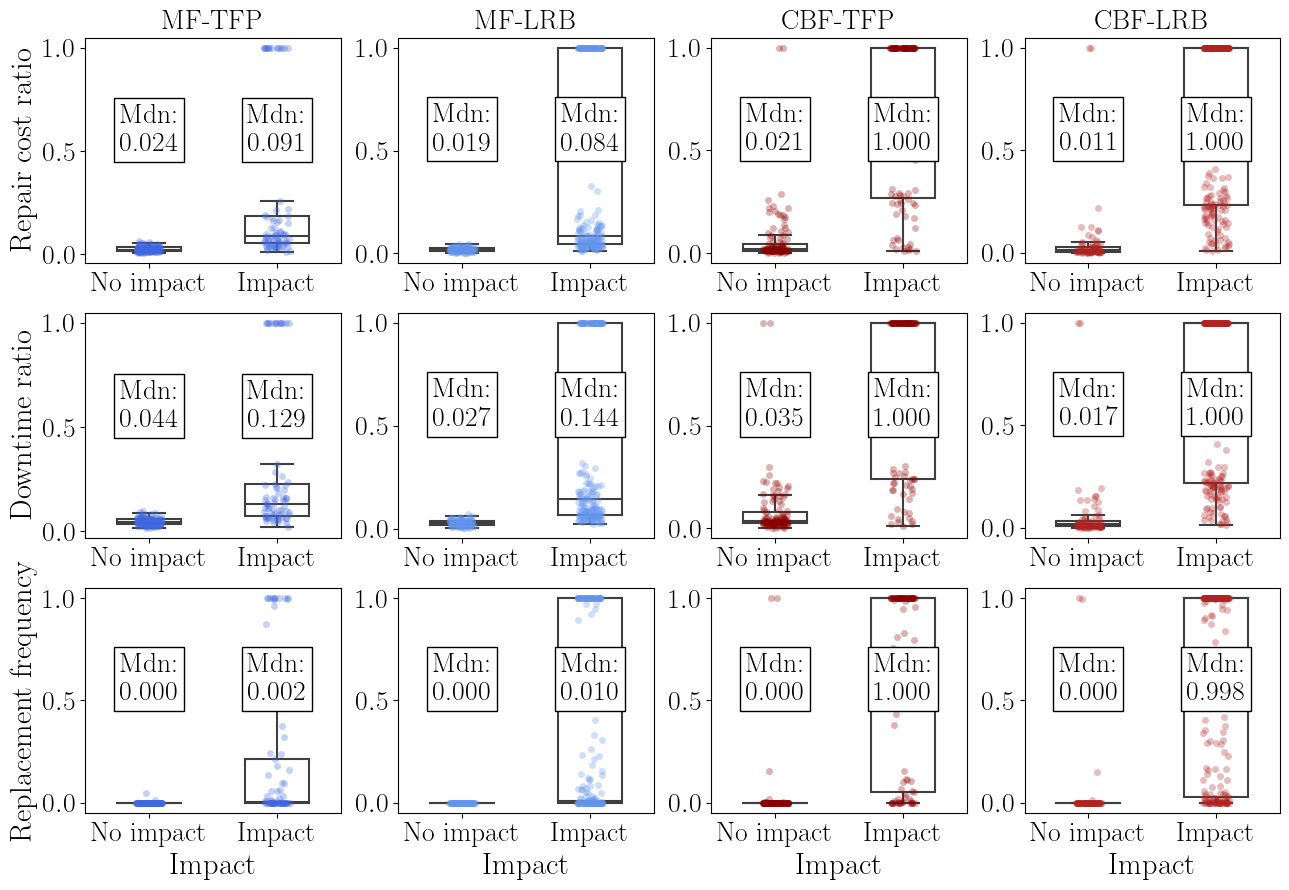

In [75]:

# TODO: breakdown

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 22
subt_font = 20
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# plt.close('all')
import seaborn as sns

# make grid and plot classification predictions

fig = plt.figure(figsize=(13, 9))

cats = ['No impact', 'Impact']

### cost
ax = fig.add_subplot(3, 4, 1)
bx = sns.boxplot(y=cost_var, x= "impacted", data=df_mf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sp = sns.stripplot(x='impacted', y=cost_var, data=df_mf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_tfp_color)


val = df_mf_tfp_o[cost_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_tfp_i[cost_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))


bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
ax.set_title('MF-TFP', fontsize=subt_font)
ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 2)
bx = sns.boxplot(y=cost_var, x= "impacted", data=df_mf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=cost_var, data=df_mf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_lrb_color)

val = df_mf_lrb_o[cost_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_lrb_i[cost_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
ax.set_title('MF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 3)
bx = sns.boxplot(y=cost_var, x= "impacted", data=df_cbf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=cost_var, data=df_cbf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_tfp_color)

val = df_cbf_tfp_o[cost_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_tfp_i[cost_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))


bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
ax.set_title('CBF-TFP', fontsize=subt_font)
# ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 4)
bx = sns.boxplot(y=cost_var, x= "impacted", data=df_cbf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=cost_var, data=df_cbf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_lrb_color)

val = df_cbf_lrb_o[cost_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_lrb_i[cost_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))



bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
ax.set_title('CBF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair cost ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

## time
ax = fig.add_subplot(3, 4, 5)
bx = sns.boxplot(y=time_var, x= "impacted", data=df_mf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sp = sns.stripplot(x='impacted', y=time_var, data=df_mf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_tfp_color)

val = df_mf_tfp_o[time_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_tfp_i[time_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))


bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('MF-TFP', fontsize=subt_font)
ax.set_ylabel('Downtime ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 6)
bx = sns.boxplot(y=time_var, x= "impacted", data=df_mf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=time_var, data=df_mf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_lrb_color)

val = df_mf_lrb_o[time_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_lrb_i[time_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))


bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('MF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair time ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 7)
bx = sns.boxplot(y=time_var, x= "impacted", data=df_cbf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=time_var, data=df_cbf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_tfp_color)

val = df_cbf_tfp_o[time_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_tfp_i[time_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('CBF-TFP', fontsize=subt_font)
# ax.set_ylabel('Repair time ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 8)
bx = sns.boxplot(y=time_var, x= "impacted", data=df_cbf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=time_var, data=df_cbf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_lrb_color)

val = df_cbf_lrb_o[time_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_lrb_i[time_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('CBF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair time ratio', fontsize=axis_font)
# ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')


## time
ax = fig.add_subplot(3, 4, 9)
bx = sns.boxplot(y=repl_var, x= "impacted", data=df_mf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sp = sns.stripplot(x='impacted', y=repl_var, data=df_mf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_tfp_color)

val = df_mf_tfp_o[repl_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_tfp_i[repl_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('MF-TFP', fontsize=subt_font)
ax.set_ylabel('Replacement frequency', fontsize=axis_font)
ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 10)
bx = sns.boxplot(y=repl_var, x= "impacted", data=df_mf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=repl_var, data=df_mf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=mf_lrb_color)

val = df_mf_lrb_o[repl_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_mf_lrb_i[repl_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.45))


bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('MF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair repl ratio', fontsize=axis_font)
ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 11)
bx = sns.boxplot(y=repl_var, x= "impacted", data=df_cbf_tfp,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=repl_var, data=df_cbf_tfp, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_tfp_color)

val = df_cbf_tfp_o[repl_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_tfp_i[repl_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('CBF-TFP', fontsize=subt_font)
# ax.set_ylabel('Repair repl ratio', fontsize=axis_font)
ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

ax = fig.add_subplot(3, 4, 12)
bx = sns.boxplot(y=repl_var, x= "impacted", data=df_cbf_lrb,  showfliers=False,
            boxprops={'facecolor': 'none'},
            width=0.5, ax=ax)
sns.stripplot(x='impacted', y=repl_var, data=df_cbf_lrb, ax=ax, jitter=True,
              alpha=0.3, s=5, color=cbf_lrb_color)

val = df_cbf_lrb_o[repl_var].median()
ax.text(0, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (0, val),(0.25, 0.45))

val = df_cbf_lrb_i[repl_var].median()
ax.text(1, 0.5, f'Mdn: \n{val:,.3f}', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate("", (1, val),(0.85, 0.8))

bx.set(xlabel=None)
bx.set(ylabel=None)
ax.set_xticklabels(cats)
# ax.set_title('CBF-LRB', fontsize=subt_font)
# ax.set_ylabel('Repair repl ratio', fontsize=axis_font)
ax.set_xlabel('Impact', fontsize=axis_font)
# ax.set_yscale('log')

fig.tight_layout()

plt.savefig('./eng_struc_figures/impact_dvs.pdf')

plt.show()


## Impact classification plot

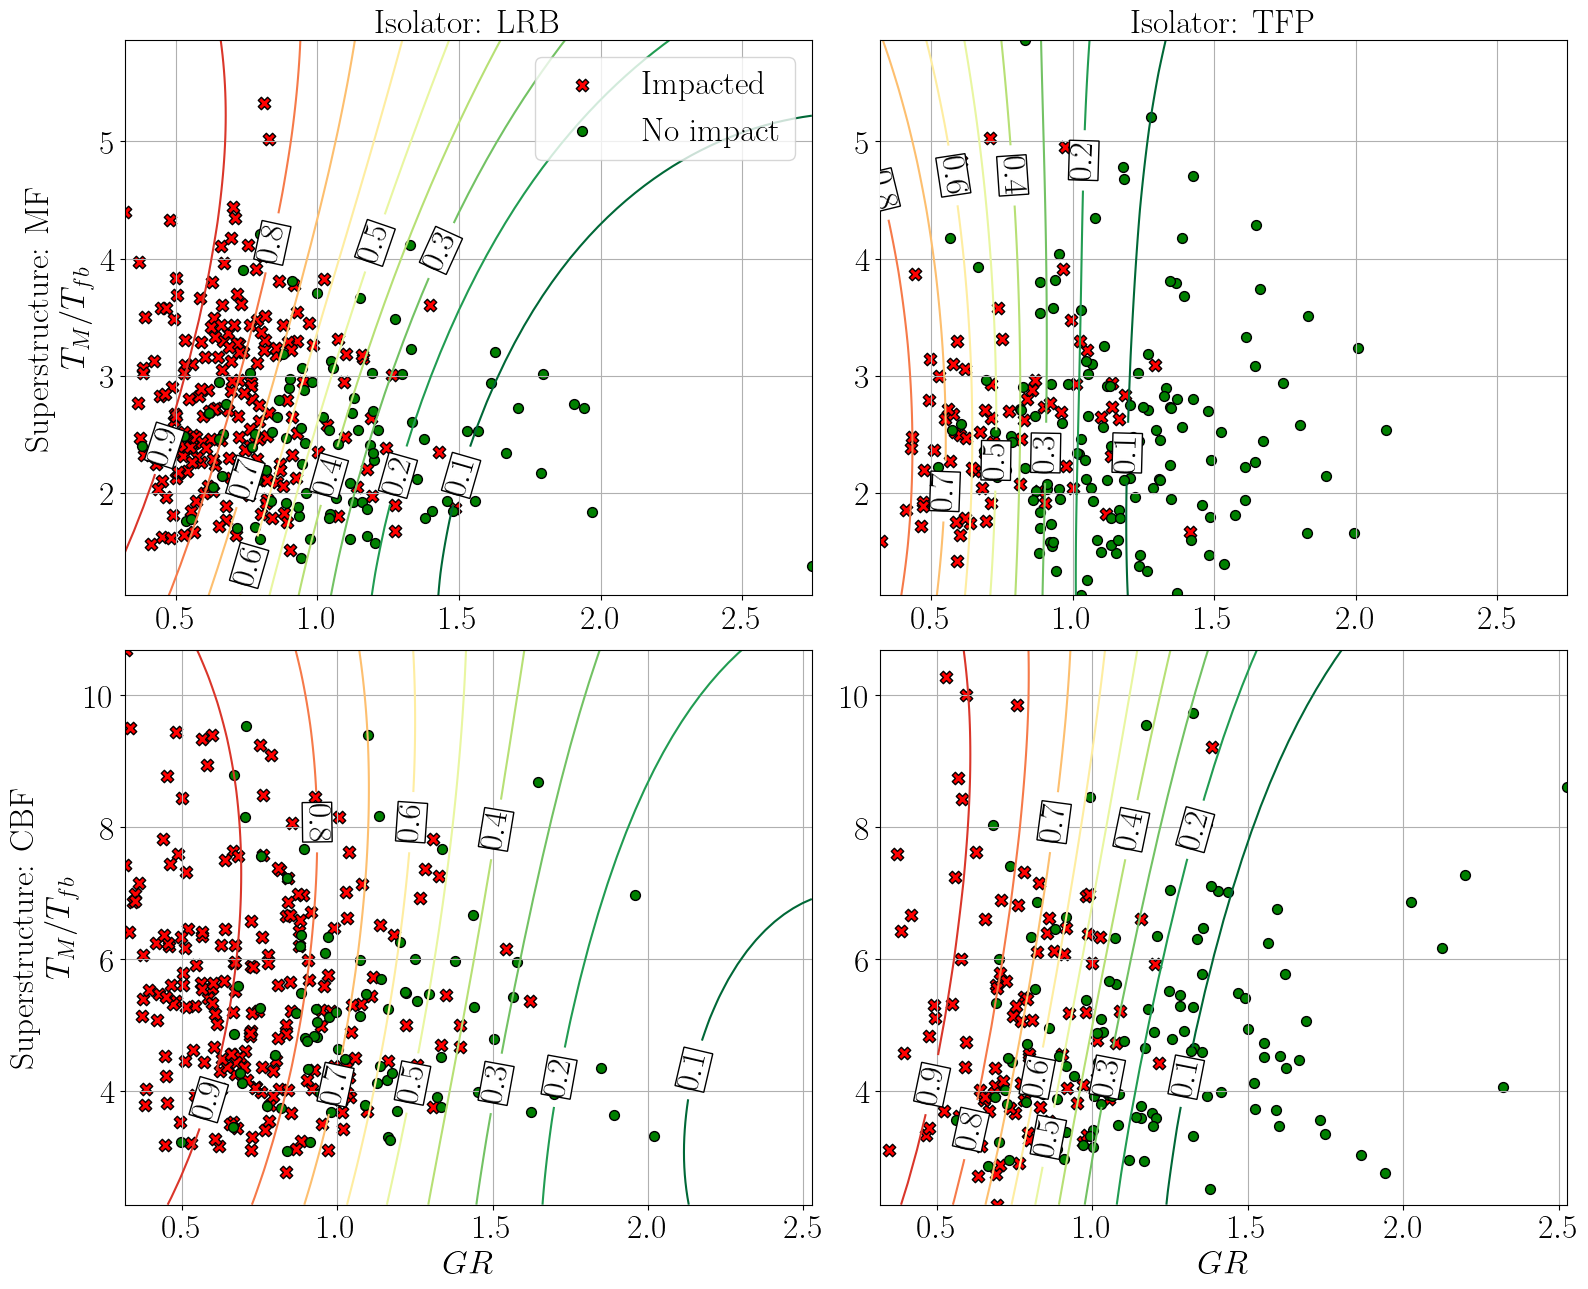

In [55]:

# TODO: impact classification plot

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
title_font = 24
subt_font = 24
import matplotlib as mpl
label_size = 24
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# make grid and plot classification predictions

fig = plt.figure(figsize=(16, 13))
ax = fig.add_subplot(2, 2, 1)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.18)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_mf_lrb.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

# plt.imshow(
#         Z_classif,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.RdYlGn_r,
#     )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, cmap='RdYlGn_r',
                  levels=np.linspace(0.1,1.0,num=10))
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_lrb_i[xvar][:plt_density],
            df_mf_lrb_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_mf_lrb_o[xvar][:plt_density],
            df_mf_lrb_o[yvar][:plt_density],
            s=50, c='green', edgecolors='black', label='No impact')
ax.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'Isolator: LRB', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel('Superstructure: MF \n $T_M/T_{fb}$', fontsize=axis_font, multialignment='center')
ax.grid('on', zorder=0)
####

ax = fig.add_subplot(2, 2, 2)

res = 75
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.18)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_mf_tfp.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

# plt.imshow(
#         Z_classif,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.RdYlGn_r,
#     )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, cmap='RdYlGn_r',
                  levels=np.linspace(0.1,1.0,num=10))
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_tfp_i[xvar][:plt_density],
            df_mf_tfp_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_mf_tfp_o[xvar][:plt_density],
            df_mf_tfp_o[yvar][:plt_density],
            s=50, c='green', edgecolors='black', label='No impact')
# plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'Isolator: TFP', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)

ax.grid('on', zorder=0)
# plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False) #remove ticks

# plt.show()



ax = fig.add_subplot(2, 2, 3)


res = 75
X_plot = make_2D_plotting_space(df_cbf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.18)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_cbf_lrb.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

# plt.imshow(
#         Z_classif,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.RdYlGn_r,
#     )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, cmap='RdYlGn_r',
                  levels=np.linspace(0.1,1.0,num=10))
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_lrb_i[xvar][:plt_density],
            df_cbf_lrb_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_cbf_lrb_o[xvar][:plt_density],
            df_cbf_lrb_o[yvar][:plt_density],
            s=50, c='green', edgecolors='black', label='No impact')
# plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
# ax.set_title(r'LRB impact', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel('Superstructure: CBF \n $T_M/T_{fb}$', fontsize=axis_font, multialignment='center')
ax.grid('on', zorder=0)
####

ax = fig.add_subplot(2, 2, 4)

res = 75
X_plot = make_2D_plotting_space(df_cbf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.18)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_cbf_tfp.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

# plt.imshow(
#         Z_classif,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.RdYlGn_r,
#     )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, cmap='RdYlGn_r',
                  levels=np.linspace(0.1,1.0,num=10))
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_tfp_i[xvar][:plt_density],
            df_cbf_tfp_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_cbf_tfp_o[xvar][:plt_density],
            df_cbf_tfp_o[yvar][:plt_density],
            s=50, c='green', edgecolors='black', label='No impact')
# plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
# ax.set_title(r'TFP impact', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)

ax.grid('on', zorder=0)
# plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False) #remove ticks
fig.tight_layout()
plt.show()

# plt.savefig('./eng_struc_figures/impact_classif.pdf')

## Targeted contours

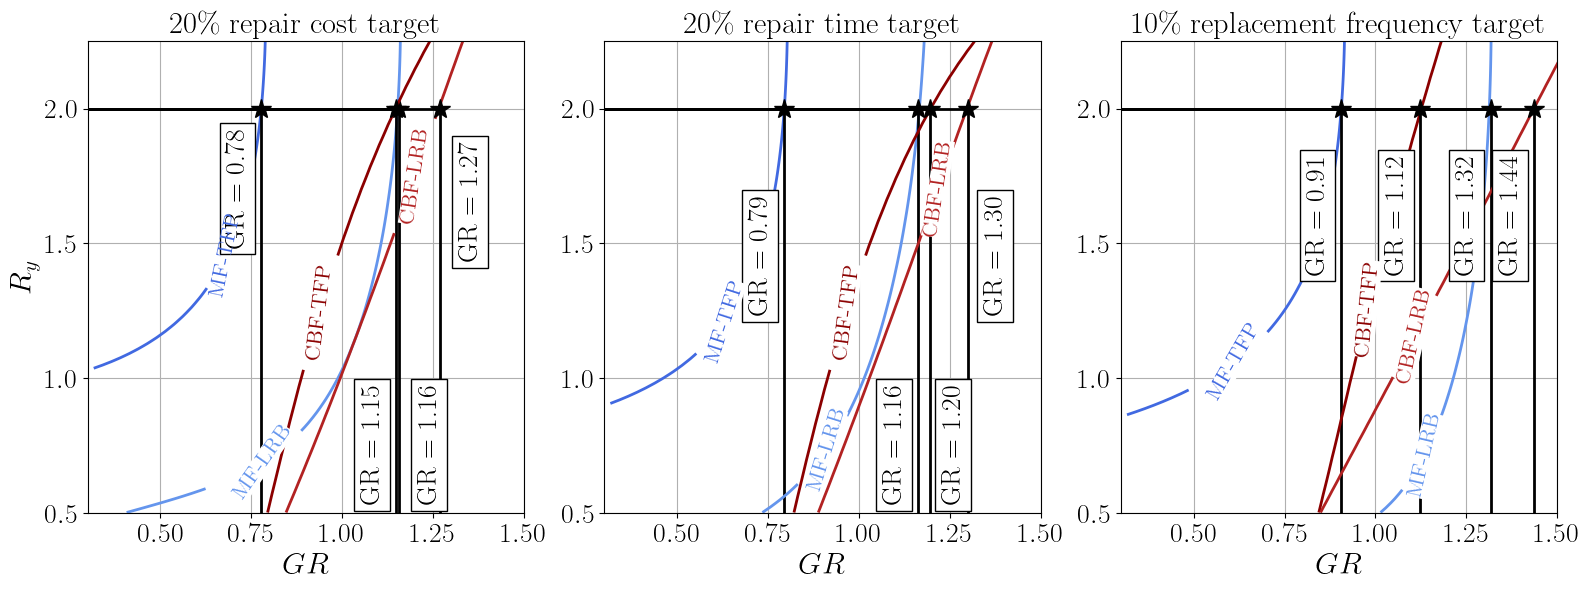

In [56]:

# Figure caption needs to state the fixed variables

# TODO: contour

def design_line(level, xoffset=0.05, y_loc=0.55, Ry_target=2.0):
    from scipy.interpolate import RegularGridInterpolator
    xq = np.linspace(0.4, 2.0, 200)
    interp = RegularGridInterpolator((y_pl, x_pl), Z_cont)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target

    lq = interp(pts)

    theGapIdx = np.argmin(abs(lq - level))

    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
    ax.text(theGap+xoffset, y_loc, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

fig = plt.figure(figsize=(16, 6))

#################################
xvar = 'gap_ratio'
yvar = 'RI'

lvls = np.array([0.2])

res = 100
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 3.0, fourth_var_set = 0.2)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

## MF-TFP

ax = fig.add_subplot(1, 3, 1)
plt.setp(ax, xticks=np.arange(0.5, 3.0, step=0.25))
plt.setp(ax, yticks=np.arange(0.5, 3.0, step=0.5))
grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=mf_tfp_color, vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

# manual_locations = [(0.5, 1.0), (1.05, 1.25), (0.8, 1.25), (0.85, 0.85)]
# plt.clabel(cs, inline=1, fontsize=clabel_size, manual=manual_locations)

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
# [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=-0.1, y_loc=1.5, Ry_target=2.0)

## MF-LRB
grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_cost_mf_lrb_i.gpr,
                       mdl_cost_mf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[mf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, manual=[(0.75, 0.7)], inline_spacing=-10.0)
[txt.set_bbox(dict(boxstyle='square, pad=0', facecolor='white', edgecolor='none')) for txt in clabels]
design_line(0.2, xoffset=0.05, y_loc=0.55, Ry_target=2.0)

## CBF-TFP
grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_cost_cbf_tfp_i.gpr,
                       mdl_cost_cbf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_tfp_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=-0.1, y_loc=0.55, Ry_target=2.0)

## CBF-LRB
grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_cost_cbf_lrb_i.gpr,
                       mdl_cost_cbf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, manual=[(1.2, 1.75)])
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=0.05, y_loc=1.45, Ry_target=2.0)

ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_title(r'20\% repair cost target', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

######

ax = fig.add_subplot(1, 3, 2)
plt.setp(ax, xticks=np.arange(0.5, 3.0, step=0.25))
plt.setp(ax, yticks=np.arange(0.5, 3.0, step=0.5))
grid_time = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_time_mf_tfp_i.gpr,
                       mdl_time_mf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=mf_tfp_color, vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=-0.1, y_loc=1.25, Ry_target=2.0)

## MF-LRB
grid_time = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_time_mf_lrb_i.gpr,
                       mdl_time_mf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[mf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0,
                    manual=[(0.8, 0.75)])
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=-.1, y_loc=0.55, Ry_target=2.0)

## CBF-TFP
grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_time_cbf_tfp_i.gpr,
                       mdl_time_cbf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_tfp_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=0.03, y_loc=0.55, Ry_target=2.0)

## CBF-LRB
grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_time_cbf_lrb_i.gpr,
                       mdl_time_cbf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0,
                    manual=[(1.25, 1.7)])
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.2, xoffset=0.04, y_loc=1.25, Ry_target=2.0)

ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_title(r'20\% repair time target', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

######

lvls = [0.1]
ax = fig.add_subplot(1, 3, 3)
plt.setp(ax, xticks=np.arange(0.5, 3.0, step=0.25))
plt.setp(ax, yticks=np.arange(0.5, 3.0, step=0.5))

grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=mf_tfp_color, vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.1, xoffset=-.1, y_loc=1.4, Ry_target=2.0)

## MF-LRB
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_repl_mf_lrb_i.gpr,
                       mdl_repl_mf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[mf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['MF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.1, xoffset=-.1, y_loc=1.4, Ry_target=2.0)

## CBF-TFP
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_repl_cbf_tfp_i.gpr,
                       mdl_repl_cbf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_tfp_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-TFP']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.1, xoffset=-0.1, y_loc=1.4, Ry_target=2.0)

## CBF-LRB
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, colors=[cbf_lrb_color], vmin=-1,
                 levels=lvls)
fmt = {}
strs = ['CBF-LRB']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

clabels = ax.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=clabel_size, inline_spacing=-10.0)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
design_line(0.1, xoffset=-.1, y_loc=1.4, Ry_target=2.0)

ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_title(r'10\% replacement frequency target', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


fig.tight_layout()
plt.show()

# plt.savefig('./eng_struc_figures/target_contours_GR_Ry.eps')

### time and repl

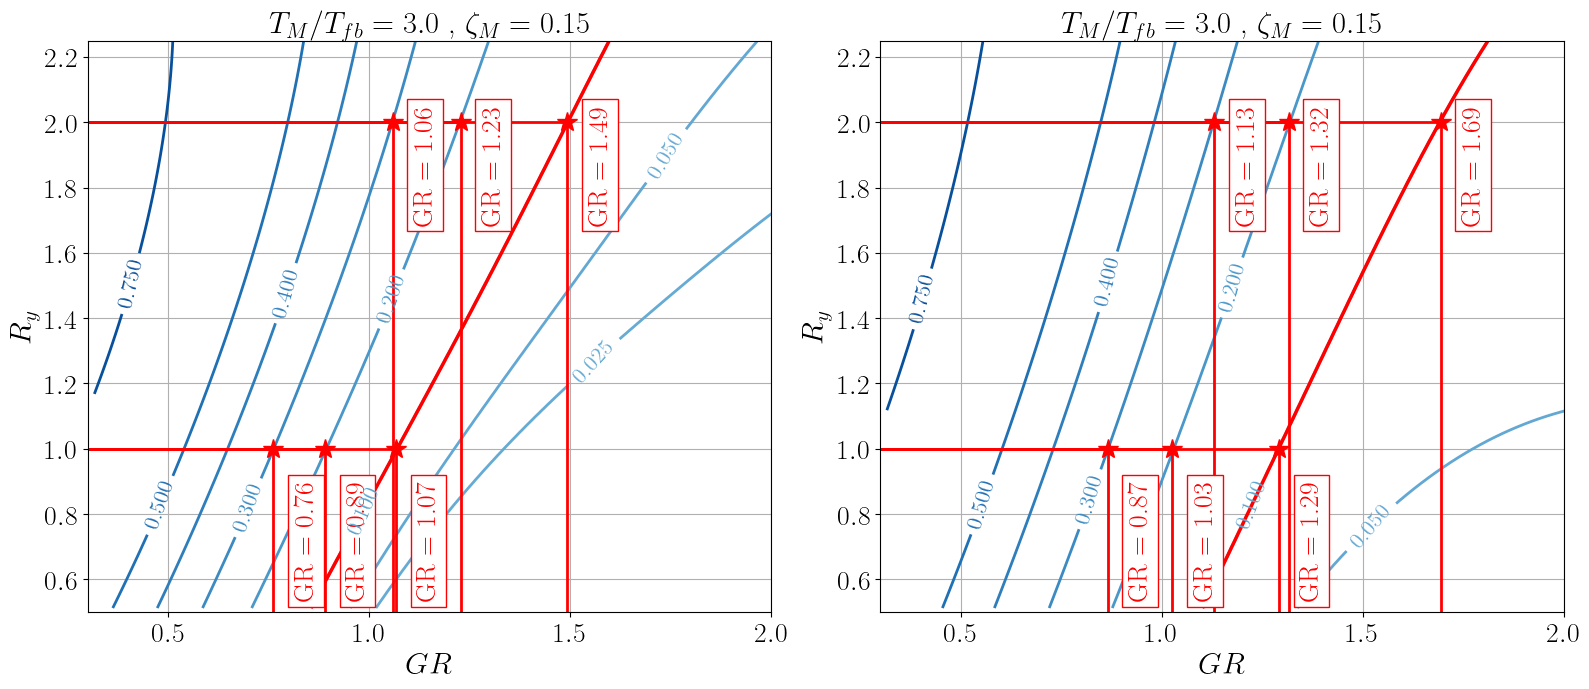

In [57]:


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

fig = plt.figure(figsize=(16, 7))

#################################
xvar = 'gap_ratio'
yvar = 'RI'

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 100
X_plot = make_2D_plotting_space(mdl_impact_cbf_lrb.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 3.0, fourth_var_set = 0.15)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

ax = fig.add_subplot(1, 2, 1)
plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome='replacement_freq_pred')

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-1,
                 levels=lvls)
clabels = ax.clabel(cs, fontsize=clabel_size)
# [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

prob_list = [0.3, 0.2, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.4, 2.0, 200)
    
    Ry_target = 1.0
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_cont)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap+0.05, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap+0.05, 1.7, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
    


ax.contour(xx_pl, yy_pl, Z_cont, levels = [0.1], colors=('red'),
            linestyles=('-'),linewidths=(2.5,))

ax.set_xlim([0.3, 2.0])
ax.set_ylim([0.5, 2.25])

# df_sc = df[(df['T_ratio']<=3.5) & (df['T_ratio']>=2.5) & 
#             (df['zeta_e']<=0.2) & (df['zeta_e']>=0.13)]

# sc = ax.scatter(df_sc[xvar],
#             df_sc[yvar],
#             c=df_sc[cost_var], cmap='Blues',
#             s=20, edgecolors='k', linewidth=0.5)

ax.grid(visible=True)
ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

# handles, labels = sc.legend_elements(prop="colors")
# legend2 = ax.legend(handles, labels, loc="lower right", title="$c_r$",
#                       fontsize=subt_font, title_fontsize=subt_font)

#################################
xvar = 'gap_ratio'
yvar = 'RI'

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 100
X_plot = make_2D_plotting_space(mdl_impact_cbf_lrb.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 3.0, fourth_var_set = 0.15)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

ax = fig.add_subplot(1, 2, 2)
plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_time_cbf_lrb_i.gpr,
                       mdl_time_cbf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-1,
                 levels=lvls)
clabels = ax.clabel(cs, fontsize=clabel_size)
# [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

prob_list = [0.3, 0.2, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.4, 2.0, 200)
    
    Ry_target = 1.0
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_cont)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap+0.05, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap+0.05, 1.7, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
    


ax.contour(xx_pl, yy_pl, Z_cont, levels = [0.1], colors=('red'),
            linestyles=('-'),linewidths=(2.5,))

ax.set_xlim([0.3, 2.0])
ax.set_ylim([0.5, 2.25])

# df_sc = df[(df['T_ratio']<=3.5) & (df['T_ratio']>=2.5) & 
#            (df['zeta_e']<=0.2) & (df['zeta_e']>=0.13)]

# sc = ax.scatter(df_sc[xvar],
#             df_sc[yvar],
#             c=df_sc[cost_var], cmap='Blues',
#             s=20, edgecolors='k', linewidth=0.5)

ax.grid(visible=True)
ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

# handles, labels = sc.legend_elements(prop="colors")
# legend2 = ax.legend(handles, labels, loc="lower left", title="$t_r$",
#                       fontsize=subt_font, title_fontsize=subt_font)


fig.tight_layout()
plt.show()

### Secondary contours

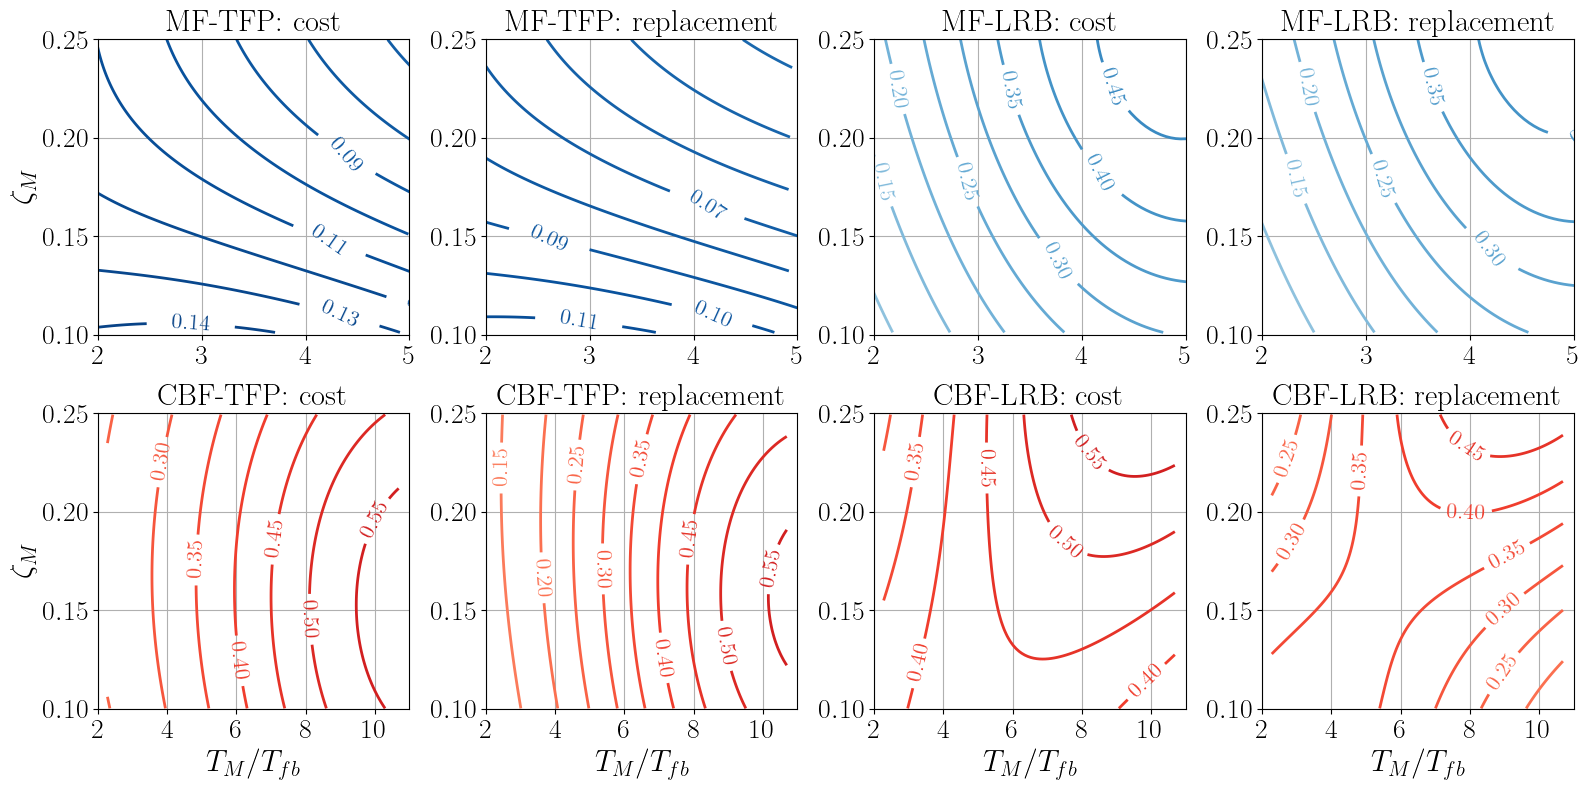

In [58]:
# TODO: contour, add imshow to this

# Figure caption needs to state the fixed variables


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

fig = plt.figure(figsize=(16, 8))

#################################
xvar = 'T_ratio'
yvar = 'zeta_e'

# lvls = np.array([0.2])
lvls = np.arange(0.01, .2, 0.01)


####### MFs
res = 100
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 1.0, fourth_var_set = 2.0)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

## mf-TFP: cost
ax = fig.add_subplot(2, 4, 1)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 5.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'MF-TFP: cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## mf-TFP: repl
ax = fig.add_subplot(2, 4, 2)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 5.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'MF-TFP: replacement', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## mf-LRB: cost
lvls = np.arange(0.05, 1.0, 0.05)
ax = fig.add_subplot(2, 4, 3)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_cost_mf_lrb_i.gpr,
                       mdl_cost_mf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 5.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'MF-LRB: cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## mf-LRB: repl
ax = fig.add_subplot(2, 4, 4)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_repl_mf_lrb_i.gpr,
                       mdl_repl_mf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 5.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'MF-LRB: replacement', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

####### CBFs
res = 100
X_plot = make_2D_plotting_space(df_cbf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 1.0, fourth_var_set = 2.0)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

## CBF-TFP: cost
ax = fig.add_subplot(2, 4, 5)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=2.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_cost_cbf_tfp_i.gpr,
                       mdl_cost_cbf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Reds', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 11.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'CBF-TFP: cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## CBF-TFP: repl
ax = fig.add_subplot(2, 4, 6)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=2.0))

grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_repl_cbf_tfp_i.gpr,
                       mdl_repl_cbf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Reds', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 11.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'CBF-TFP: replacement', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## CBF-LRB: cost
ax = fig.add_subplot(2, 4, 7)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=2.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_cost_cbf_lrb_i.gpr,
                       mdl_cost_cbf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Reds', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 11.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'CBF-LRB: cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

## CBF-LRB: repl
ax = fig.add_subplot(2, 4, 8)
plt.setp(ax, xticks=np.arange(2.0, 11.0, step=2.0))

grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Reds', vmin=-0.5,
                 levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([2.0, 11.0])
ax.set_ylim([0.1, 0.25])

ax.grid(visible=True)
ax.set_title(r'CBF-LRB: replacement', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)


fig.tight_layout()
plt.show()

# plt.savefig('./eng_struc_figures/target_contours_Tm_zeta.eps')

## Constructability KDE

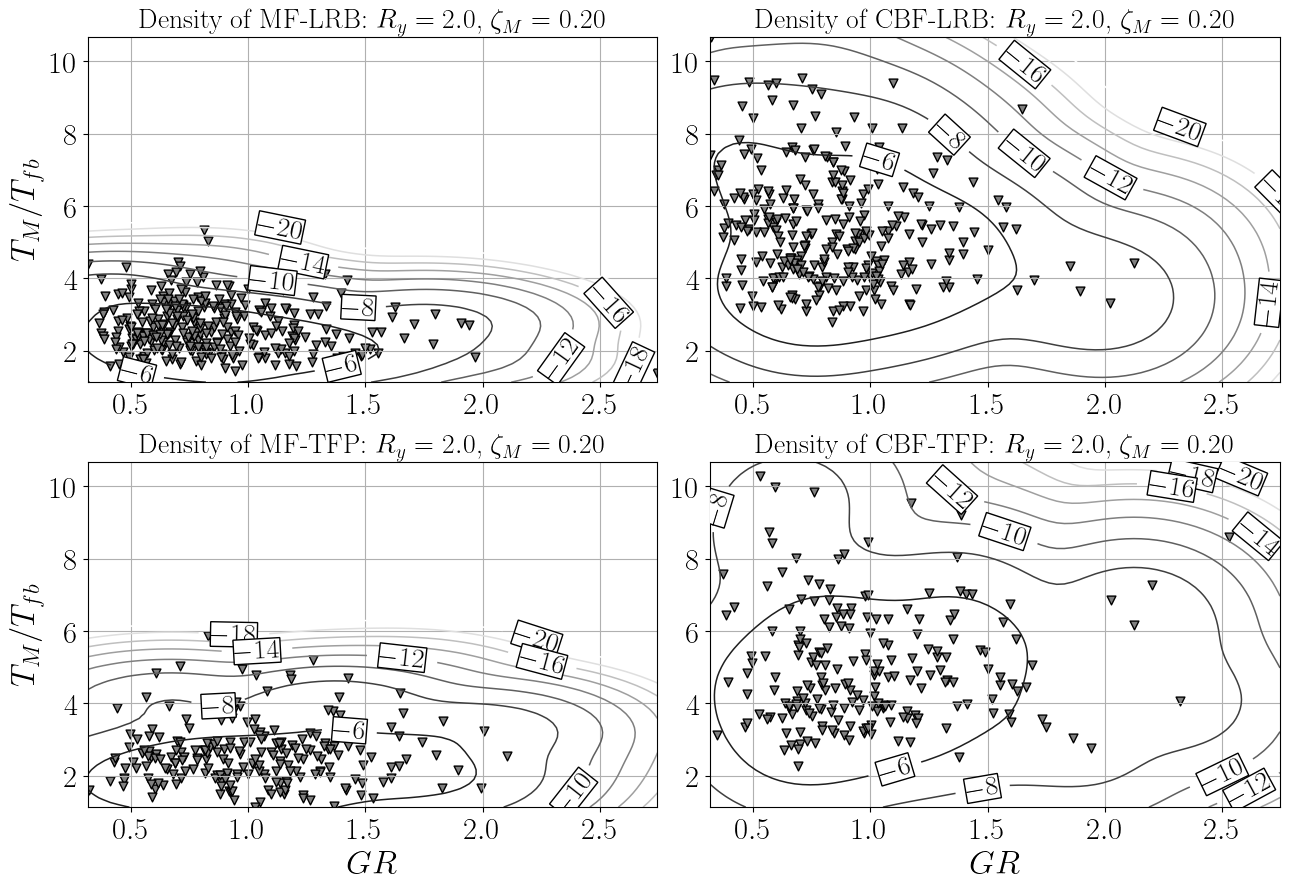

In [73]:
# TODO: KDE

fig = plt.figure(figsize=(13,9))

title_font = 20
ax=fig.add_subplot(2, 2, 1)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(mdl_all.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.2)
xx = X_plot[xvar]
yy = X_plot[yvar]

# density estimation
log_dens = mdl_impact_mf_lrb.kde.score_samples(X_plot)


# # kernel logistic impact prediction
# K_space = mdl_impact.get_kernel(X_plot, kernel_name='rbf', gamma=0.25)
# probs_imp = mdl_impact.log_reg_kernel.predict_proba(K_space)
# Z = probs_imp[:,1]

x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_dens = log_dens.reshape(xx_pl.shape)

# plt.imshow(
#         Z_dens,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.Blues,
#     )


lvls = np.arange(-20, -2, 2)
cs = plt.contour(xx_pl, yy_pl, Z_dens, levels=lvls, linewidths=1.1, cmap='binary')
clabels = plt.clabel(cs, fontsize=20, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_lrb[xvar],
            df_mf_lrb[yvar],
            s=40, c='gray', marker='v', edgecolors='black', label='Replacement')

ax.set_title(r'Density of MF-LRB: $R_y = 2.0$, $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid()

ax=fig.add_subplot(2, 2, 2)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(mdl_all.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.2)
xx = X_plot[xvar]
yy = X_plot[yvar]

# density estimation
log_dens = mdl_impact_cbf_lrb.kde.score_samples(X_plot)


# # kernel logistic impact prediction
# K_space = mdl_impact.get_kernel(X_plot, kernel_name='rbf', gamma=0.25)
# probs_imp = mdl_impact.log_reg_kernel.predict_proba(K_space)
# Z = probs_imp[:,1]

x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_dens = log_dens.reshape(xx_pl.shape)

# plt.imshow(
#         Z_dens,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.Blues,
#     )
plt_density = 200

lvls = np.arange(-20, -2, 2)
cs = plt.contour(xx_pl, yy_pl, Z_dens, levels=lvls, linewidths=1.1, cmap='binary')
clabels = plt.clabel(cs, fontsize=20, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_lrb[xvar],
            df_cbf_lrb[yvar],
            s=40, c='gray', marker='v', edgecolors='black', label='Replacement')

ax.set_title(r'Density of CBF-LRB: $R_y = 2.0$, $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid()


#### TFPs

ax=fig.add_subplot(2, 2, 3)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(mdl_all.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.2)
xx = X_plot[xvar]
yy = X_plot[yvar]

# density estimation
log_dens = mdl_impact_mf_tfp.kde.score_samples(X_plot)


# # kernel logistic impact prediction
# K_space = mdl_impact.get_kernel(X_plot, kernel_name='rbf', gamma=0.25)
# probs_imp = mdl_impact.log_reg_kernel.predict_proba(K_space)
# Z = probs_imp[:,1]

x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_dens = log_dens.reshape(xx_pl.shape)

# plt.imshow(
#         Z_dens,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.Blues,
#     )

lvls = np.arange(-20, -2, 2)
cs = plt.contour(xx_pl, yy_pl, Z_dens, levels=lvls, linewidths=1.1, cmap='binary')
clabels = plt.clabel(cs, fontsize=20, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_tfp[xvar],
            df_mf_tfp[yvar],
            s=40, c='gray', marker='v', edgecolors='black', label='Replacement')

ax.set_title(r'Density of MF-TFP: $R_y = 2.0$, $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid()

ax=fig.add_subplot(2, 2, 4)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(mdl_all.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.2)
xx = X_plot[xvar]
yy = X_plot[yvar]

# density estimation
log_dens = mdl_impact_cbf_tfp.kde.score_samples(X_plot)


# # kernel logistic impact prediction
# K_space = mdl_impact.get_kernel(X_plot, kernel_name='rbf', gamma=0.25)
# probs_imp = mdl_impact.log_reg_kernel.predict_proba(K_space)
# Z = probs_imp[:,1]

x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_dens = log_dens.reshape(xx_pl.shape)

# plt.imshow(
#         Z_dens,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.Blues,
#     )

lvls = np.arange(-20, -2, 2)
cs = plt.contour(xx_pl, yy_pl, Z_dens, levels=lvls, linewidths=1.1, cmap='binary')
clabels = plt.clabel(cs, fontsize=20, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_tfp[xvar],
            df_cbf_tfp[yvar],
            s=40, c='gray', marker='v', edgecolors='black', label='Replacement')

ax.set_title(r'Density of CBF-TFP: $R_y = 2.0$, $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid()
fig.tight_layout()

plt.savefig('./eng_struc_figures/fig_12_kde_constructability_eesd.eps')
plt.show()

# Inverse design

## Upfront cost

In [60]:
# calc cost of new point

# TODO: inverse design

def calc_upfront_cost(X, config_dict, steel_cost_dict,
                      land_cost_per_sqft=2837/(3.28**2)):
    
    from scipy.interpolate import interp1d
    zeta_ref = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
    Bm_ref = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
    interp_f = interp1d(zeta_ref, Bm_ref)
    Bm = interp_f(X['zeta_e'])
    
    # estimate Tm
    config_df = pd.DataFrame(config_dict, index=[0])
    from loads import estimate_period, define_gravity_loads
    W_and_loads = config_df.apply(lambda row: define_gravity_loads(row),
                                            axis='columns', result_type='expand')
    
    # order of outputs are below
    # W_seis, W_super, w_on_frame, P_on_leaning_column, all_w_cases, all_plc_cases
    W_seis = W_and_loads.iloc[0][0]
    W_super = W_and_loads.iloc[0][1]
    
    # perform calculation for both MF and CBF
    X_query = X.copy()
    X_query['h_bldg'] = config_dict['num_stories'] * config_dict['h_story']
    
    # estimate periods
    X_mf = X_query.copy()
    X_mf['superstructure_system'] = 'MF'
    X_mf['T_fbe'] = X_mf.apply(lambda row: estimate_period(row),
                                                     axis='columns', result_type='expand')
    
    X_cbf = X_query.copy()
    X_cbf['superstructure_system'] = 'CBF'
    X_cbf['h_bldg'] = config_dict['num_stories'] * config_dict['h_story']
    X_cbf['T_fbe'] = X_cbf.apply(lambda row: estimate_period(row),
                                                     axis='columns', result_type='expand')
    
    
    X_query['T_fbe_mf'] = X_mf['T_fbe']
    X_query['T_fbe_cbf'] = X_cbf['T_fbe']
    
    X_query['T_m_mf'] = X_query['T_fbe_mf'] * X_query['T_ratio']
    X_query['T_m_cbf'] = X_query['T_fbe_cbf'] * X_query['T_ratio']
    
    # calculate moat gap
    pi = 3.14159
    g = 386.4
    SaTm_mf = config_dict['S_1']/X_query['T_m_mf']
    moat_gap_mf = X_query['gap_ratio'] * (g*(SaTm_mf/Bm)*X_query['T_m_mf']**2)/(4*pi**2)
    
    # calculate design base shear
    kM_mf = (1/g)*(2*pi/X_query['T_m_mf'])**2
    Dm_mf = g*config_dict['S_1']*X_query['T_m_mf']/(4*pi**2*Bm)
    Vb_mf = Dm_mf * kM_mf * W_super / 2
    Vst_mf = Vb_mf*(W_super/W_seis)**(1 - 2.5*X_query['zeta_e'])
    Vs_mf = Vst_mf/X_query['RI']
    
    # regression was done for steel cost ~ Vs
    reg_mf = steel_cost_dict['mf']
    try:
        steel_cost_mf = reg_mf.intercept_.item() + reg_mf.coef_.item()*Vs_mf
    except:
        steel_cost_mf = reg_mf.intercept_ + reg_mf.coef_.item()*Vs_mf    
    
    L_bldg = config_dict['L_bay']*config_dict['num_bays']
    land_area_mf = (L_bldg*12.0 + moat_gap_mf)**2
    land_cost_mf = land_cost_per_sqft/144.0 * land_area_mf
    
    # repeat for cbf
    # calculate moat gap
    pi = 3.14159
    g = 386.4
    SaTm_cbf = config_dict['S_1']/X_query['T_m_cbf']
    moat_gap_cbf = X_query['gap_ratio'] * (g*(SaTm_cbf/Bm)*X_query['T_m_cbf']**2)/(4*pi**2)
    
    # calculate design base shear
    kM_cbf = (1/g)*(2*pi/X_query['T_m_cbf'])**2
    Dm_cbf = g*config_dict['S_1']*X_query['T_m_cbf']/(4*pi**2*Bm)
    Vb_cbf = Dm_cbf * kM_cbf * W_super / 2
    Vst_cbf = Vb_cbf*(W_super/W_seis)**(1 - 2.5*X_query['zeta_e'])
    Vs_cbf = Vst_cbf/X_query['RI']
    
    # regression was done for steel cost ~ Vs
    reg_cbf = steel_cost_dict['cbf']
    try:
        steel_cost_cbf = reg_cbf.intercept_.item() + reg_cbf.coef_.item()*Vs_cbf
    except:
        steel_cost_cbf = reg_cbf.intercept_ + reg_cbf.coef_.item()*Vs_cbf
        
    L_bldg = config_dict['L_bay']*config_dict['num_bays']
    land_area_cbf = (L_bldg*12.0 + moat_gap_cbf)**2
    land_cost_cbf = land_cost_per_sqft/144.0 * land_area_cbf
    
    return({'total_mf': steel_cost_mf + land_cost_mf,
            'steel_mf': steel_cost_mf,
            'land_mf': land_cost_mf,
           'total_cbf': steel_cost_cbf + land_cost_cbf,
           'steel_cbf': steel_cost_cbf,
           'land_cbf': land_cost_cbf,
           'Vs_cbf': Vs_cbf,
           'Vs_mf': Vs_mf})


# linear regress cost as f(base shear)
from sklearn.linear_model import LinearRegression
reg_mf = LinearRegression(fit_intercept=False)
reg_mf.fit(X=df_mf[['Vs']], y=df_mf[['steel_cost']])

reg_cbf = LinearRegression(fit_intercept=False)
reg_cbf.fit(X=df_cbf[['Vs']], y=df_cbf[['steel_cost']])

reg_dict = {
    'mf':reg_mf,
    'cbf':reg_cbf
    }

## Grid search

In [61]:

def grid_search_inverse_design(res, system_name, targets_dict, config_dict,
                               impact_clfs, cost_regs, time_regs, repl_regs,
                               cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):
    import time
    
    # isolator_system = system_name.split('_')[1]
    # system_X = impact_clfs['mdl_impact_'+system_name].X
    X_space = make_design_space(res)
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify replacement models
    mdl_repl_hit_name = 'mdl_repl_' + system_name + '_i'
    mdl_repl_miss_name = 'mdl_repl_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_repl_hit = repl_regs[mdl_repl_hit_name]
    mdl_repl_miss = repl_regs[mdl_repl_miss_name]
    
    # first, scan whole range for constructable bounds
    # constructable
    space_constr = mdl_impact.kde.score_samples(X_space)
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]
    constr_bounds = ok_constr.agg(['min', 'max'])
    variable_names = list(constr_bounds.columns)
    temp_dict = constr_bounds.to_dict()
    ranges = [tuple(temp_dict[key].values()) for key in variable_names]
    bounds = {k:v for (k,v) in zip(variable_names, ranges)}
    
    
    # then recreate a finer design space within constructable range
    X_space = make_design_space(res, bound_dict=bounds)
    t0 = time.time()
    
    # assumes GPC/GPR, predict the outcome for the design space
    space_repair_cost = predict_DV(X_space, 
                                   mdl_impact.gpc, 
                                   mdl_cost_hit.gpr, 
                                   mdl_cost_miss.gpr, 
                                   outcome=cost_var)
    tp = time.time() - t0
    print("GPC-GPR repair cost prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                               tp))
    
    t0 = time.time()
    space_downtime = predict_DV(X_space,
                                mdl_impact.gpc,
                                mdl_time_hit.gpr,
                                mdl_time_miss.gpr,
                                outcome=time_var)
    tp = time.time() - t0
    print("GPC-GPR downtime prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))

    t0 = time.time()
    space_repl = predict_DV(X_space,
                            mdl_impact.gpc,
                            mdl_repl_hit.gpr,
                            mdl_repl_miss.gpr,
                            outcome='replacement_freq')
    tp = time.time() - t0
    print("GPC-GPR replacement prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    t0 = time.time()
    space_constr = mdl_impact.kde.score_samples(X_space)
    tp = time.time() - t0
    print("KDE constructability prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    # filter cost threshold
    cost_thresh = targets_dict[cost_var]
    ok_cost = X_space.loc[space_repair_cost[cost_var+'_pred']<=cost_thresh]

    # downtime threshold
    dt_thresh = targets_dict[time_var]
    ok_time = X_space.loc[space_downtime[time_var+'_pred']<=dt_thresh]

    # acceptable replacement risk
    repl_thresh = targets_dict['replacement_freq']
    ok_repl = X_space.loc[space_repl['replacement_freq_pred']<=
                          repl_thresh]
    
    # constructable
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]

    X_design = X_space[np.logical_and.reduce((
            X_space.index.isin(ok_cost.index), 
            X_space.index.isin(ok_time.index),
            X_space.index.isin(ok_repl.index),
            X_space.index.isin(ok_constr.index)))]

    if X_design.shape[0] < 1:
        print('No suitable design found for system', system_name)
        return None, None
    
    
    # select best viable design
    structural_system = system_name.split('_')[0]
    
    if structural_system.upper() == 'MF':
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict)
    else:
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        
    # upfront_costs = calc_upfront_cost(
    #     X_design, config_dict=config_dict, steel_cost_dict=reg_dict)
    
    # compare = X_design.copy()
    # compare['cost'] = upfront_costs['total_'+structural_system]
    # compare['repair'] = space_repair_cost[space_repair_cost.index.isin(X_design.index)]
    
    cheapest_idx = upfront_costs['total_'+structural_system].idxmin()
    inv_upfront_cost = upfront_costs['total_'+structural_system].min()

    # least upfront cost of the viable designs
    inv_design = X_design.loc[cheapest_idx]
    inv_downtime = space_downtime.iloc[cheapest_idx].item()
    inv_repair_cost = space_repair_cost.iloc[cheapest_idx].item()
    inv_repl_risk = space_repl.iloc[cheapest_idx].item()
    
    inv_performance = {
        'time': inv_downtime,
        'cost': inv_repair_cost,
        'replacement_freq': inv_repl_risk,
        'upfront_cost': inv_upfront_cost}
    
    bldg_area = (config_dict['num_bays']*config_dict['L_bay'])**2 * (config_dict['num_stories'] + 1)

    # # assume $600/sf replacement
    # n_worker_series = bldg_area/1000
    # n_worker_parallel = n_worker_series/2

    # read out predictions
    print('==================================')
    print('            Predictions           ')
    print('==================================')
    print('======= Targets =======')
    print('System:', system_name)
    print('Repair cost fraction:', f'{cost_thresh*100:,.2f}%')
    print('Repair time fraction:', f'{dt_thresh*100:,.2f}%')
    print('Replacement risk:', f'{repl_thresh*100:,.2f}%')


    print('======= Overall inverse design =======')
    print(inv_design)
    print('Upfront cost of selected design: ',
          f'${inv_upfront_cost:,.2f}')
    print('Predicted median repair cost ratio: ',
          f'{inv_repair_cost*100:,.2f}%')
    print('Predicted repair time ratio: ',
          f'{inv_downtime*100:,.2f}%')
    print('Predicted replacement risk: ',
          f'{inv_repl_risk:.2%}')
    
    return(inv_design, inv_performance, X_design)

In [62]:

'''
def loss_fcn(x, system_name, targets_dict, config_dict,
             impact_clfs, cost_regs, time_regs, repl_regs,
             cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):
    
    X_trial = pd.DataFrame([x], columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify replacement models
    mdl_repl_hit_name = 'mdl_repl_' + system_name + '_i'
    mdl_repl_miss_name = 'mdl_repl_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_repl_hit = repl_regs[mdl_repl_hit_name]
    mdl_repl_miss = repl_regs[mdl_repl_miss_name]
    
    cost_trial = predict_DV(X_trial, 
                                   mdl_impact.gpc, 
                                   mdl_cost_hit.gpr, 
                                   mdl_cost_miss.gpr, 
                                   outcome=cost_var)
    
    time_trial = predict_DV(X_trial,
                                mdl_impact.gpc,
                                mdl_time_hit.gpr,
                                mdl_time_miss.gpr,
                                outcome=time_var)

    repl_trial = predict_DV(X_trial,
                            mdl_impact.gpc,
                            mdl_repl_hit.gpr,
                            mdl_repl_miss.gpr,
                            outcome='replacement_freq')
    
    constr_trial = mdl_impact.kde.score_samples(X_trial)
    
    if cost_trial[cost_var+'_pred'][0] > targets_dict[cost_var]:
        cost_loss = 1e9
    else:
        cost_loss = 0
    
    if time_trial[time_var+'_pred'][0] > targets_dict[time_var]:
        time_loss = 1e9
    else:
        time_loss = 0
    
    if repl_trial[repl_var+'_pred'][0] > targets_dict[repl_var]:
        repl_loss = 1e9
    else:
        repl_loss = 0
        
    if constr_trial[0] < targets_dict['constructability']:
        constr_loss = 1e9
    else:
        constr_loss = 0
    
    # select best viable design
    structural_system = system_name.split('_')[0]
    
    if structural_system.upper() == 'MF':
        upfront_costs = calc_upfront_cost(
            X_trial, config_dict=config_dict, steel_cost_dict=reg_dict)
    else:
        upfront_costs = calc_upfront_cost(
            X_trial, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        
    upfront_loss = upfront_costs['total_'+structural_system]
    
    return(cost_loss + time_loss + repl_loss + + constr_loss + upfront_loss)
    

x1_bounds = (0.6, 2.0)
x2_bounds = (0.5, 2.25)
x3_bounds = (2.0, 10.0)
x4_bounds = (0.1, 0.25)


### regular
ns = 4
hs = 13.
nb = 6
Lb = 30.

config_dict_moderate = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb
    }


my_targets = {
    cost_var: 0.2,
    time_var: 0.2,
    'replacement_freq': 0.1,
    'constructability': -6.0}

# loss_fcn(a, 'mf_tfp', my_targets, config_dict_moderate, 
#          impact_classification_mdls, cost_regression_mdls, 
#          time_regression_mdls, repl_regression_mdls,
#          cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

my_bounds = (x1_bounds, x2_bounds, x3_bounds, x4_bounds)
x0 = np.array([1.0, 2.0, 5.5, 0.2])
from scipy.optimize import minimize

from scipy.optimize import basinhopping
minimizer_kwargs={'args':('cbf_lrb', my_targets, config_dict_moderate, 
                          impact_classification_mdls, cost_regression_mdls, 
                          time_regression_mdls, repl_regression_mdls, 
                          'cmp_cost_ratio', 'cmp_time_ratio'),'bounds':my_bounds}
res = basinhopping(loss_fcn, x0, minimizer_kwargs=minimizer_kwargs)

# res = minimize(loss_fcn, x0, args=('cbf_lrb', my_targets, config_dict_moderate, 
#                                       impact_classification_mdls, cost_regression_mdls, 
#                                       time_regression_mdls, repl_regression_mdls, 'cmp_cost_ratio', 'cmp_time_ratio'),
#                       bounds=my_bounds, method='L-BFGS-B')
'''

"\ndef loss_fcn(x, system_name, targets_dict, config_dict,\n             impact_clfs, cost_regs, time_regs, repl_regs,\n             cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):\n    \n    X_trial = pd.DataFrame([x], columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])\n    # identify cost models\n    mdl_impact_name = 'mdl_impact_' + system_name\n    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'\n    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'\n    \n    mdl_impact = impact_clfs[mdl_impact_name]\n    mdl_cost_hit = cost_regs[mdl_cost_hit_name]\n    mdl_cost_miss = cost_regs[mdl_cost_miss_name]\n    \n    # identify time models\n    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'\n    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'\n    \n    mdl_impact = impact_clfs[mdl_impact_name]\n    mdl_time_hit = time_regs[mdl_time_hit_name]\n    mdl_time_miss = time_regs[mdl_time_miss_name]\n    \n    # identify replacement models\n    mdl_repl_hit_name = 'mdl

## Design space

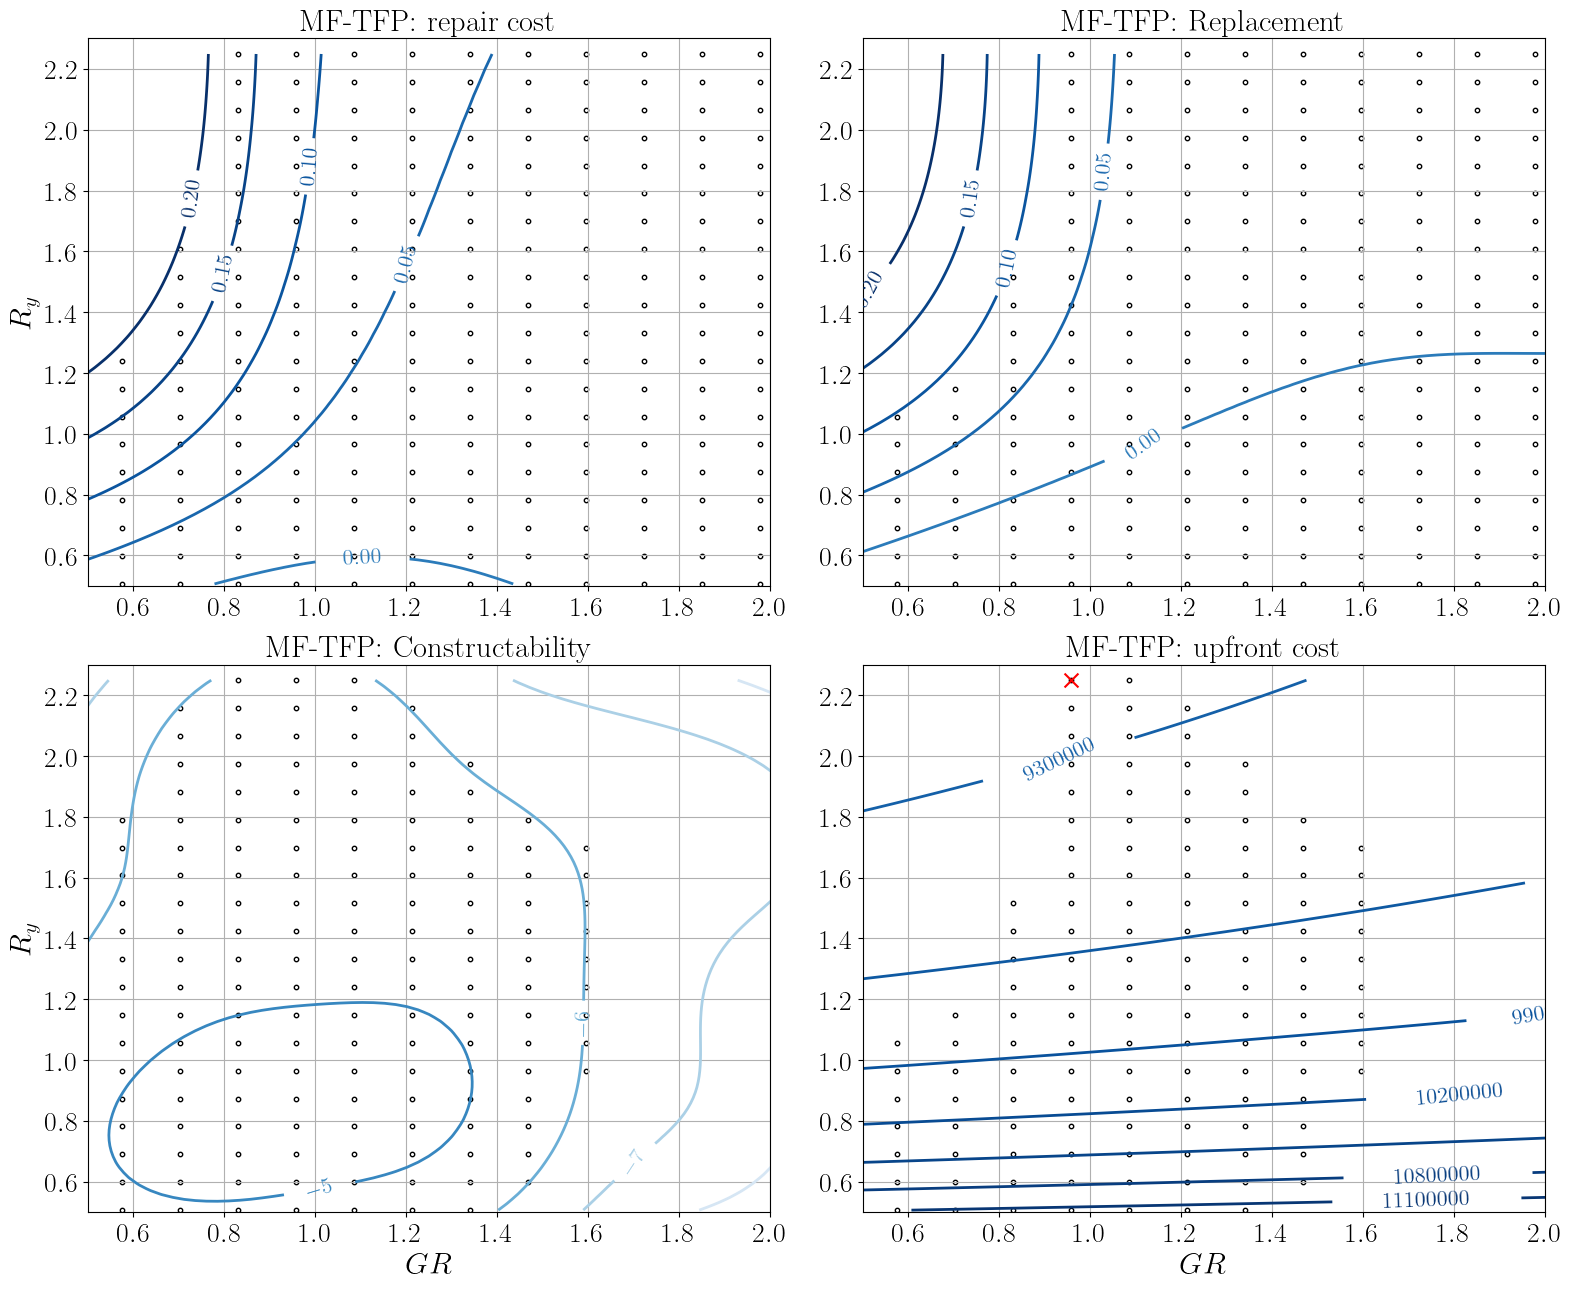

In [63]:

### regular
ns = 4
hs = 13.
nb = 6
Lb = 30.

config_dict_moderate = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb
    }

my_targets = {
    cost_var: 0.2,
    time_var: 0.2,
    'replacement_freq': 0.1,
    'constructability': -6.0}


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

fig = plt.figure(figsize=(16, 13))

#################################
xvar = 'gap_ratio'
yvar = 'RI'

# lvls = np.array([0.2])
lvls = np.arange(0.00, .25, 0.05)


####### MFs
res = 100
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.87, fourth_var_set = 0.23)

X_sc = make_2D_plotting_space(df_mf[covariate_list], 20, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.87, fourth_var_set = 0.23)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

## mf-TFP: cost
ax = fig.add_subplot(2, 2, 1)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

qual_cost = predict_DV(X_sc,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)
X_sc_qual_cost = X_sc[qual_cost[cost_var+'_pred'] < 0.2]
sc = ax.scatter(X_sc_qual_cost[xvar], X_sc_qual_cost[yvar], c='white', edgecolors='black', s=10)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5, levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([0.5, 2.0])
ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-TFP: repair cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

## mf-TFP: replacement
ax = fig.add_subplot(2, 2, 2)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)


qual_cost = predict_DV(X_sc,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)
X_sc_qual_repl = X_sc[qual_cost[repl_var+'_pred'] < 0.1]
sc = ax.scatter(X_sc_qual_repl[xvar], X_sc_qual_repl[yvar], c='white', edgecolors='black', s=10)


Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5, levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([0.5, 2.0])
ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-TFP: Replacement', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


## mf-TFP: constructability
ax = fig.add_subplot(2, 2, 3)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))
lvl_kde = np.arange(-9, -2, 1)
kde_scr = mdl_impact_mf_tfp.kde.score_samples(X_plot)

qual_cost = mdl_impact_mf_tfp.kde.score_samples(X_sc)
X_sc_qual_kde = X_sc[qual_cost > -6.1]
sc = ax.scatter(X_sc_qual_kde[xvar], X_sc_qual_kde[yvar], c='white', edgecolors='black', s=10)

Z = np.array(kde_scr)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', levels=lvl_kde)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([0.5, 2.0])
ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-TFP: Constructability', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)


## mf-TFP: cost
ax = fig.add_subplot(2, 2, 4)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))


all_upfront_costs  = calc_upfront_cost(
    X_plot, config_dict=config_dict_moderate, steel_cost_dict=reg_dict)

mf_upfront_cost = all_upfront_costs['total_mf']


X_sc_qual = X_sc[np.logical_and.reduce((
        X_sc.index.isin(X_sc_qual_cost.index), 
        X_sc.index.isin(X_sc_qual_repl.index),
        X_sc.index.isin(X_sc_qual_kde.index)))]
sc = ax.scatter(X_sc_qual[xvar], X_sc_qual[yvar], c='white', edgecolors='black', s=10)

qual_upfront_cost  = calc_upfront_cost(
    X_sc_qual, config_dict=config_dict_moderate, steel_cost_dict=reg_dict)

cheapest_idx = qual_upfront_cost['total_mf'].idxmin()

# least upfront cost of the viable designs
the_design = X_sc_qual.loc[cheapest_idx]

ax.scatter(the_design[xvar], the_design[yvar], marker='x', c='red', s=100)

Z = np.array(mf_upfront_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5)

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.set_xlim([0.5, 2.0])
ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-TFP: upfront cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()

## Inv design for targets

In [64]:
### regular
ns = 4
hs = 13.
nb = 6
Lb = 30.

config_dict_moderate = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb
    }


# for hi_constr, switch constructability to -5.0
my_targets = {
    cost_var: 0.2,
    time_var: 0.2,
    'replacement_freq': 0.1,
    'constructability': -6.0}

mf_tfp_inv_design, mf_tfp_inv_performance, mf_tfp_space = grid_search_inverse_design(
    20, 'mf_tfp', my_targets, config_dict_moderate, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

mf_lrb_inv_design, mf_lrb_inv_performance, mf_lrb_space = grid_search_inverse_design(
    20, 'mf_lrb', my_targets, config_dict_moderate, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

cbf_tfp_inv_design, cbf_tfp_inv_performance, cbf_tfp_space = grid_search_inverse_design(
    20, 'cbf_tfp', my_targets, config_dict_moderate, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

cbf_lrb_inv_design, cbf_lrb_inv_performance, cbf_lrb_space = grid_search_inverse_design(
    20, 'cbf_lrb', my_targets, config_dict_moderate, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

#%%
### strict
ns = 4
hs = 13.
nb = 6
Lb = 30.

config_dict_strict = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb
    }

my_targets = {
    cost_var: 0.1,
    time_var: 0.1,
    'replacement_freq': 0.05,
    'constructability': -6.0}


mf_tfp_strict_design, mf_tfp_strict_performance, mf_tfp_strict_space = grid_search_inverse_design(
    20, 'mf_tfp', my_targets, config_dict_strict, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

mf_lrb_strict_design, mf_lrb_strict_performance, mf_lrb_strict_space = grid_search_inverse_design(
    20, 'mf_lrb', my_targets, config_dict_strict, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

cbf_tfp_strict_design, cbf_tfp_strict_performance, cbf_tfp_strict_space = grid_search_inverse_design(
    20, 'cbf_tfp', my_targets, config_dict_strict, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

cbf_lrb_strict_design, cbf_lrb_strict_performance, cbf_lrb_strict_space = grid_search_inverse_design(
    20, 'cbf_lrb', my_targets, config_dict_strict, 
    impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls,
    cost_var='cmp_cost_ratio', time_var='cmp_time_ratio')

GPC-GPR repair cost prediction for 160000 inputs in 1.502 s
GPC-GPR downtime prediction for 160000 inputs in 1.543 s
GPC-GPR replacement prediction for 160000 inputs in 1.526 s
KDE constructability prediction for 160000 inputs in 0.986 s
            Predictions           
======= Targets =======
System: mf_tfp
Repair cost fraction: 20.00%
Repair time fraction: 20.00%
Replacement risk: 10.00%
======= Overall inverse design =======
gap_ratio    0.894737
RI           2.250000
T_ratio      2.872576
zeta_e       0.250000
Name: 153719, dtype: float64
Upfront cost of selected design:  $9,210,226.00
Predicted median repair cost ratio:  13.49%
Predicted repair time ratio:  14.53%
Predicted replacement risk:  9.06%
GPC-GPR repair cost prediction for 160000 inputs in 2.078 s
GPC-GPR downtime prediction for 160000 inputs in 2.194 s
GPC-GPR replacement prediction for 160000 inputs in 2.127 s
KDE constructability prediction for 160000 inputs in 1.307 s
            Predictions           
======= Targ

## Engineering inverse design

In [65]:

from db import prepare_ida_util
import json
### regular

print ('======== designing moderate structures ==========')
my_design = mf_tfp_inv_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 10

mf_tfp_dict = my_design.to_dict()

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
mf_tfp_dict['T_ratio'] = mf_tfp_dict['T_ratio']/0.9
mf_tfp_dict['gap_ratio'] = mf_tfp_dict['gap_ratio']*0.9

ida_mf_tfp_df = prepare_ida_util(mf_tfp_dict, db_string='../../resource/',
                                 config_dict=config_dict_moderate)

print('Length of MF-TFP IDA:', len(ida_mf_tfp_df))


# with open('../inputs/mf_tfp_moderate.in', 'w') as file:
#     file.write(json.dumps(mf_tfp_dict))
#     file.close()
    
# with open('../inputs/mf_tfp_moderate.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_moderate))
#     file.close()

my_design = cbf_tfp_inv_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 7


cbf_tfp_dict = my_design.to_dict()

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
cbf_tfp_dict['T_ratio'] = cbf_tfp_dict['T_ratio']/0.9
cbf_tfp_dict['gap_ratio'] = cbf_tfp_dict['gap_ratio']*0.9
    
ida_cbf_tfp_df = prepare_ida_util(cbf_tfp_dict, db_string='../../resource/',
                                 config_dict=config_dict_moderate)

print('Length of CBF-TFP IDA:', len(ida_cbf_tfp_df))

# with open('../inputs/cbf_tfp_moderate.in', 'w') as file:
#     file.write(json.dumps(cbf_tfp_dict))
#     file.close()
    
# with open('../inputs/cbf_tfp_moderate.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_moderate))
#     file.close()


my_design = mf_lrb_inv_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 10

mf_lrb_dict = my_design.to_dict()

ida_mf_lrb_df = prepare_ida_util(mf_lrb_dict, db_string='../../resource/',
                                 config_dict=config_dict_moderate)

print('Length of MF-LRB IDA:', len(ida_mf_lrb_df))

# with open('../inputs/mf_lrb_moderate.in', 'w') as file:
#     file.write(json.dumps(mf_lrb_dict))
#     file.close()
    
# with open('../inputs/mf_lrb_moderate.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_moderate))
#     file.close()


my_design = cbf_lrb_inv_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 10

cbf_lrb_dict = my_design.to_dict()

ida_cbf_lrb_df = prepare_ida_util(cbf_lrb_dict, db_string='../../resource/',
                                 config_dict=config_dict_moderate)

# with open('../inputs/cbf_lrb_moderate.in', 'w') as file:
#     file.write(json.dumps(cbf_lrb_dict))
#     file.close()
    
# with open('../inputs/cbf_lrb_moderate.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_moderate))
#     file.close()
    
print('Length of CBF-LRB IDA:', len(ida_cbf_lrb_df))

### strict

print ('======== designing enhanced structures ==========')

my_design = mf_tfp_strict_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 7

mf_tfp_dict_strict = my_design.to_dict()

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
mf_tfp_dict_strict['T_ratio'] = mf_tfp_dict_strict['T_ratio']/0.9
mf_tfp_dict_strict['gap_ratio'] = mf_tfp_dict_strict['gap_ratio']*0.9

ida_mf_tfp_df_strict = prepare_ida_util(mf_tfp_dict_strict, db_string='../../resource/',
                                 config_dict=config_dict_strict)

print('Length of MF-TFP IDA:', len(ida_mf_tfp_df_strict))

# with open('../inputs/mf_tfp_enhanced.in', 'w') as file:
#     file.write(json.dumps(mf_tfp_dict_strict))
#     file.close()
    
# with open('../inputs/mf_tfp_enhanced.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_strict))
#     file.close()

my_design = cbf_tfp_strict_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 7

cbf_tfp_dict_strict = my_design.to_dict()

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
cbf_tfp_dict_strict['T_ratio'] = cbf_tfp_dict_strict['T_ratio']/0.9
cbf_tfp_dict_strict['gap_ratio'] = cbf_tfp_dict_strict['gap_ratio']*0.9
    
ida_cbf_tfp_df_strict = prepare_ida_util(cbf_tfp_dict_strict, db_string='../../resource/',
                                 config_dict=config_dict_strict)

print('Length of CBF-TFP IDA:', len(ida_cbf_tfp_df_strict))

# with open('../inputs/cbf_tfp_enhanced.in', 'w') as file:
#     file.write(json.dumps(cbf_tfp_dict_strict))
#     file.close()

# with open('../inputs/cbf_tfp_enhanced.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_strict))
#     file.close()


my_design = mf_lrb_strict_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 10

mf_lrb_dict_strict = my_design.to_dict()

ida_mf_lrb_df_strict = prepare_ida_util(mf_lrb_dict_strict, db_string='../../resource/',
                                 config_dict=config_dict_strict)

print('Length of MF-LRB IDA:', len(ida_mf_lrb_df_strict))

# with open('../inputs/mf_lrb_enhanced.in', 'w') as file:
#     file.write(json.dumps(mf_lrb_dict_strict))
#     file.close()
    

# with open('../inputs/mf_lrb_enhanced.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_strict))
#     file.close()    

my_design = cbf_lrb_strict_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 10

cbf_lrb_dict_strict = my_design.to_dict()

ida_cbf_lrb_df_strict = prepare_ida_util(cbf_lrb_dict_strict, db_string='../../resource/',
                                 config_dict=config_dict_strict)

print('Length of CBF-LRB IDA:', len(ida_cbf_lrb_df_strict))

# with open('../inputs/cbf_lrb_enhanced.in', 'w') as file:
#     file.write(json.dumps(cbf_lrb_dict_strict))
#     file.close()
    

# with open('../inputs/cbf_lrb_enhanced.cfg', 'w') as file:
#     file.write(json.dumps(config_dict_strict))
#     file.close()

======== designing moderate structures ==========
Designs completed for 1 TFPs in 0.00 s
Designs completed for 1 moment frames in 0.06 s
Length of MF-TFP IDA: 135
Designs completed for 1 TFPs in 0.00 s
Designs completed for 1 braced frames in 0.04 s
Length of CBF-TFP IDA: 141
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 moment frames in 0.04 s
Length of MF-LRB IDA: 144
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 braced frames in 0.04 s
Length of CBF-LRB IDA: 144
======== designing enhanced structures ==========
Designs completed for 1 TFPs in 0.00 s
Designs completed for 1 moment frames in 0.04 s
Length of MF-TFP IDA: 135
Designs completed for 1 TFPs in 0.00 s
Designs completed for 1 braced frames in 0.03 s
Length of CBF-TFP IDA: 141
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 moment frames in 0.05 s
Length of MF-LRB IDA: 144
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 brac

# Validation

## Load and process

In [66]:

def process_results(run_case):
    
    import numpy as np
    # load in validation and max run
    val_dir = '../../data/validation/'+run_case+'/'
    
    loss_file = run_case+'_loss.pickle'
    max_loss_file = run_case+'_max_loss.pickle'
    
    val_obj = pd.read_pickle(val_dir+loss_file)
    ida_results_df = val_obj.ida_results.reset_index(drop=True)
    loss_results_df = val_obj.loss_data.reset_index(drop=True)
    
    val_max_obj = pd.read_pickle(val_dir+max_loss_file)
    max_loss_results_df = val_max_obj.max_loss.reset_index(drop=True)
    
    # calculate loss ratios
    ida_results_df = loss_percentages(
        ida_results_df, loss_results_df, max_loss_results_df)
    
    # print out the results
    ida_levels = [1.0, 1.5, 2.0]

    val_cost  = np.zeros((3,))
    val_replacement = np.zeros((3,))
    val_cost_ratio = np.zeros((3,))
    val_downtime_ratio = np.zeros((3,))
    val_downtime = np.zeros((3,))
    impact_freq = np.zeros((3,))
    struct_cost = np.zeros((3,))
    nsc_cost = np.zeros((3,))
    gap_ratios = np.zeros((3,))
    T_ratios = np.zeros((3,))
    
    GR_adjs = np.zeros((3,))
    
    isolator_system = run_case.split('_')[1]
    
    # collect variable: currently working with means of medians
    cost_var_ida = 'cost_50%'
    time_var_ida = 'time_l_50%'
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    for i, lvl in enumerate(ida_levels):
        val_ida = ida_results_df[ida_results_df['ida_level']==lvl]
        loss_ida = loss_results_df[ida_results_df['ida_level']==lvl]
        
        val_replacement[i] = val_ida['replacement_freq'].mean()
        val_cost[i] = loss_ida[cost_var_ida].mean()
        val_cost_ratio[i] = val_ida[cost_var].mean()
        val_downtime[i] = loss_ida[time_var_ida].mean()
        val_downtime_ratio[i] = val_ida[time_var].mean()
        impact_freq[i] = val_ida['impacted'].mean()
        struct_cost[i] = val_ida['B_50%'].mean()
        nsc_cost[i] = val_ida['C_50%'].mean() + val_ida['D_50%'].mean() + val_ida['E_50%'].mean() 
            
        
        zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
        BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
        Bm = np.interp(val_ida['zeta_e'], zetaRef, BmRef)
        
        if isolator_system == 'tfp':
            T_shifted = np.mean(val_ida['T_m']*0.9)
        else:
            T_shifted = np.mean(val_ida['T_m'])
            
        sa_tm_adj = val_ida.apply(
            lambda x: get_ST(x, T_shifted,
                              db_dir='../../resource/ground_motions/gm_db.csv',
                              spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
            axis=1)
        
        gap_ratios_all = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(val_ida['sa_tm']/Bm)*val_ida['T_m']**2)
        gap_ratios[i] = gap_ratios_all.mean()
        
        GR_adj = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(sa_tm_adj/Bm)*T_shifted**2)
        GR_adjs[i] = GR_adj.mean()
            
        T_ratio_adj = T_shifted / val_ida['T_fbe'].mean()
        
        T_ratios[i] = T_shifted / val_ida['T_fb'].mean()
        
    # print(T_shifted)
    # print(GR_adjs)
    # print(T_ratio_adj)
    # print(T_ratios)
    
    
    design_list = []
    ss_sys = ida_results_df['superstructure_system'].iloc[0]
    iso_sys = ida_results_df['isolator_system'].iloc[0]
    if ss_sys == 'CBF':
        design_list.extend(['beam', 'column', 'brace'])
    else:
        design_list.extend(['beam', 'column'])
    if iso_sys == 'LRB':
        design_list.extend(['d_bearing', 'd_lead', 't_r', 'n_layers'])
    else:
        design_list.extend(['mu_1', 'mu_2', 'R_1', 'R_2'])
        
    
    sys_name = ss_sys+'-'+iso_sys
    
    # design_tested = ida_results_df[['moat_ampli', 'RI', 'T_ratio' , 'zeta_e']].iloc[0]
    # design_specifics = ida_results_df[design_list].iloc[0]
    # print('==================================')
    # print('   Validation results  (1.0 MCE)  ')
    # print('==================================')
    
    # print('System:', ss_sys+'-'+iso_sys)
    # print('Average median repair cost: ',
    #       f'${val_cost[0]:,.2f}')
    # print('Repair cost ratio: ', 
    #       f'{val_cost_ratio[0]:,.3f}')
    # print('Repair time ratio: ',
    #       f'{val_downtime_ratio[0]:,.3f}')
    # print('Estimated replacement frequency: ',
    #       f'{val_replacement[0]:.2%}')
    # print(design_tested)
    # print(design_specifics)
    
    latex_string = f"& {sys_name} & {val_cost_ratio[0]:.3f} & {val_cost_ratio[1]:.3f} & {val_cost_ratio[2]:.3f} \
        & {val_downtime_ratio[0]:.3f} & {val_downtime_ratio[1]:.3f} & {val_downtime_ratio[2]:.3f} \
            & {val_replacement[0]:.3f} & {val_replacement[1]:.3f} & {val_replacement[2]:.3f} \\\\"
    
    print(latex_string)  
    
    
    # n_workers = (ida_results_df['bldg_area']/1000).mean()

    # print('Cost total:', ida_results_df['total_cmp_cost'].mean()/1e6)
    # print('Time total:', ida_results_df['total_cmp_time'].mean()/n_workers)
    
    # print('GR:', gap_ratios)
    # print('TR:', T_ratios)
    # print('Impact:', impact_freq)
    # print('Structural cost:', struct_cost/1e6)
    # print('Non-structural cost:', nsc_cost/1e6)
    
    
    # latex_string = f"& {sys_name} & {mce_cost_ratio:.3f} & {mce_time_ratio:.3f} & {mce_repl_ratio:.3f} \
    #     & {val_cost_ratio[0]:.2f} & {GP_time_ratio:.2f} & {GP_repl_risk:.2f} &  \${upfront_cost/1e6:.2f} M \\\\"
    
    return(ida_results_df, val_replacement, val_cost, 
           val_cost_ratio, val_downtime, val_downtime_ratio)

(mf_tfp_val_results, mf_tfp_val_repl, mf_tfp_val_cost, mf_tfp_val_cost_ratio, 
 mf_tfp_val_downtime, mf_tfp_val_downtime_ratio) = process_results('mf_tfp_moderate')
(mf_lrb_val_results, mf_lrb_val_repl, mf_lrb_val_cost, mf_lrb_val_cost_ratio, 
 mf_lrb_val_downtime, mf_lrb_val_downtime_ratio) = process_results('mf_lrb_moderate')
(cbf_tfp_val_results, cbf_tfp_val_repl, cbf_tfp_val_cost, cbf_tfp_val_cost_ratio, 
 cbf_tfp_val_downtime, cbf_tfp_val_downtime_ratio) = process_results('cbf_tfp_moderate')
(cbf_lrb_val_results, cbf_lrb_val_repl, cbf_lrb_val_cost, cbf_lrb_val_cost_ratio, 
 cbf_lrb_val_downtime, cbf_lrb_val_downtime_ratio) = process_results('cbf_lrb_moderate')

(mf_tfp_strict_results, mf_tfp_strict_repl, mf_tfp_strict_cost, mf_tfp_strict_cost_ratio, 
 mf_tfp_strict_downtime, mf_tfp_strict_downtime_ratio) = process_results('mf_tfp_enhanced')
(mf_lrb_strict_results, mf_lrb_strict_repl, mf_lrb_strict_cost, mf_lrb_strict_cost_ratio, 
 mf_lrb_strict_downtime, mf_lrb_strict_downtime_ratio) = process_results('mf_lrb_enhanced')
(cbf_tfp_strict_results, cbf_tfp_strict_repl, cbf_tfp_strict_cost, cbf_tfp_strict_cost_ratio, 
 cbf_tfp_strict_downtime, cbf_tfp_strict_downtime_ratio) = process_results('cbf_tfp_enhanced')
(cbf_lrb_strict_results, cbf_lrb_strict_repl, cbf_lrb_strict_cost, cbf_lrb_strict_cost_ratio, 
 cbf_lrb_strict_downtime, cbf_lrb_strict_downtime_ratio) = process_results('cbf_lrb_enhanced')

& MF-TFP & 0.191 & 0.773 & 1.000         & 0.205 & 0.781 & 1.000             & 0.161 & 0.767 & 1.000 \\
& MF-LRB & 0.077 & 0.545 & 0.904         & 0.092 & 0.553 & 0.907             & 0.067 & 0.530 & 0.901 \\
& CBF-TFP & 0.159 & 0.721 & 0.913         & 0.166 & 0.719 & 0.914             & 0.093 & 0.683 & 0.894 \\
& CBF-LRB & 0.154 & 0.567 & 0.898         & 0.156 & 0.564 & 0.896             & 0.104 & 0.495 & 0.876 \\
& MF-TFP & 0.081 & 0.647 & 0.980         & 0.094 & 0.655 & 0.980             & 0.044 & 0.629 & 0.976 \\
& MF-LRB & 0.070 & 0.502 & 0.864         & 0.081 & 0.511 & 0.868             & 0.044 & 0.477 & 0.862 \\
& CBF-TFP & 0.101 & 0.564 & 0.818         & 0.106 & 0.566 & 0.815             & 0.038 & 0.511 & 0.798 \\
& CBF-LRB & 0.043 & 0.445 & 0.867         & 0.043 & 0.444 & 0.866             & 0.023 & 0.411 & 0.858 \\


In [67]:

def print_latex_inverse_table(sys_name, design_dict, performance_dict):

    
    GR = design_dict['gap_ratio']
    Ry = design_dict['RI']
    T_ratio = design_dict['T_ratio'] # this is the "designed" value
    zeta = design_dict['zeta_e']
    GP_cost_ratio = performance_dict['cost']
    GP_time_ratio = performance_dict['time']
    GP_repl_risk = performance_dict['replacement_freq']
    upfront_cost = performance_dict['upfront_cost']
    
    
    latex_string = f"& {sys_name} & {GR:.2f} & {Ry:.2f} & {T_ratio:.2f} & {zeta:.2f} \
        & {GP_cost_ratio:.3f} & {GP_time_ratio:.3f} & {GP_repl_risk:.3f} &  \${upfront_cost/1e6:.2f} M \\\\"
    print(latex_string)
    return

print_latex_inverse_table('MF-TFP', mf_tfp_inv_design, mf_tfp_inv_performance)   
print_latex_inverse_table('MF-LRB', mf_lrb_inv_design, mf_lrb_inv_performance)   
print_latex_inverse_table('CBF-TFP', cbf_tfp_inv_design, cbf_tfp_inv_performance)   
print_latex_inverse_table('CBF-LRB', cbf_lrb_inv_design, cbf_lrb_inv_performance)   

print_latex_inverse_table('MF-TFP', mf_tfp_strict_design, mf_tfp_strict_performance)   
print_latex_inverse_table('MF-LRB', mf_lrb_strict_design, mf_lrb_strict_performance)   
print_latex_inverse_table('CBF-TFP', cbf_tfp_strict_design, cbf_tfp_strict_performance)   
print_latex_inverse_table('CBF-LRB', cbf_lrb_strict_design, cbf_lrb_strict_performance)   

print()

def print_latex_design_table(sys_name, val_results):

    typ_design = val_results.iloc[0]
    
    # moat in cm
    moat = typ_design['constructed_moat']*2.54
    largest_beam = typ_design['beam'][0]
    largest_column = typ_design['column'][0]
    try:
        largest_brace = typ_design['brace'][0]
    except:
        largest_brace = 'n/a'
    
    # d bearings in cm, R curvature in mm
    try:
        bearing_param_1 = typ_design['mu_1']
    except:
        bearing_param_1 = typ_design['d_lead']*2.54
        
    try:
        bearing_param_2 = typ_design['mu_2']
    except:
        bearing_param_2 = typ_design['d_bearing'] *2.54
        
    try:
        bearing_param_3 = typ_design['R_1']*25.4
    except:
        bearing_param_3 = typ_design['t_r']* 2.54
        
    # print as either TFP or LRB
    try:
        bearing_param_4 = typ_design['R_2']*25.4
        latex_string = f"& {sys_name} & {moat:.1f} cm & {largest_beam} & {largest_column} & {largest_brace} \
            & {bearing_param_1:.3f} & {bearing_param_2:.3f} & {bearing_param_3:.0f} mm &  {bearing_param_4:.0f} mm \\\\"
    except:
        bearing_param_4 = typ_design['n_layers'] 
        latex_string = f"& {sys_name} & {moat:.1f} cm & {largest_beam} & {largest_column} & {largest_brace} \
            & {bearing_param_1:.1f} cm & {bearing_param_2:.1f} cm & {bearing_param_3:.1f} cm &  {bearing_param_4:.0f}  \\\\"
    
    # print('Average median repair cost: ',
    #       f'${val_cost[0]:,.2f}')
    # print('Repair cost ratio: ', 
    #       f'{val_cost_ratio[0]:,.3f}')
    # print('Repair time ratio: ',
    #       f'{val_downtime_ratio[0]:,.3f}')
    # print('Estimated replacement frequency: ',
    #       f'{val_replacement[0]:.2%}')
    
    
    print(latex_string)
    return

print_latex_design_table('MF-TFP', mf_tfp_val_results)
print_latex_design_table('CBF-TFP', cbf_tfp_val_results)
print_latex_design_table('MF-TFP', mf_tfp_strict_results)
print_latex_design_table('CBF-TFP', cbf_tfp_strict_results)

print_latex_design_table('MF-LRB', mf_lrb_val_results)
print_latex_design_table('CBF-LRB', cbf_lrb_val_results)
print_latex_design_table('MF-LRB', mf_lrb_strict_results)
print_latex_design_table('CBF-LRB', cbf_lrb_strict_results)

& MF-TFP & 0.89 & 2.25 & 2.87 & 0.25         & 0.135 & 0.145 & 0.091 &  \$9.21 M \\
& MF-LRB & 1.24 & 2.16 & 2.62 & 0.20         & 0.133 & 0.144 & 0.100 &  \$9.35 M \\
& CBF-TFP & 1.34 & 2.25 & 6.24 & 0.22         & 0.172 & 0.183 & 0.098 &  \$6.37 M \\
& CBF-LRB & 1.58 & 1.97 & 5.19 & 0.21         & 0.129 & 0.141 & 0.093 &  \$6.47 M \\
& MF-TFP & 1.12 & 2.25 & 2.87 & 0.24         & 0.076 & 0.086 & 0.037 &  \$9.24 M \\
& MF-LRB & 1.41 & 2.07 & 2.50 & 0.19         & 0.080 & 0.089 & 0.047 &  \$9.44 M \\
& CBF-TFP & 1.48 & 1.79 & 6.24 & 0.23         & 0.085 & 0.099 & 0.036 &  \$6.45 M \\
& CBF-LRB & 1.63 & 1.51 & 5.19 & 0.19         & 0.083 & 0.094 & 0.050 &  \$6.59 M \\

& MF-TFP & 48.3 cm & W27X84 & W14X233 & n/a             & 0.025 & 0.075 & 479 mm &  3095 mm \\
& CBF-TFP & 74.4 cm & W36X135 & W12X87 & HSS7X7X1/4             & 0.046 & 0.070 & 1160 mm &  2762 mm \\
& MF-TFP & 60.8 cm & W27X84 & W14X233 & n/a             & 0.028 & 0.078 & 679 mm &  3066 mm \\
& CBF-TFP & 81.7 cm & W33X141

## One time predictions

In [68]:
# two values differ
# GR should be different because real ground motion suite has different Sa than design spectrum
# T ratio should be different because actual T_fb is not perfectly equal to Tfbe

def one_time_pred(X_built, system_name, 
                        impact_clfs, cost_regs, time_regs, repl_regs):
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify replacement models
    mdl_repl_hit_name = 'mdl_repl_' + system_name + '_i'
    mdl_repl_miss_name = 'mdl_repl_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_repl_hit = repl_regs[mdl_repl_hit_name]
    mdl_repl_miss = repl_regs[mdl_repl_miss_name]
    
    # assumes GPC/GPR, predict the outcome for the design space
    ab_repair_cost, ab_repair_cost_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_cost_hit.gpr, mdl_cost_miss.gpr, 
        outcome=cost_var, return_var=True)
    
    ab_downtime, ab_downtime_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_time_hit.gpr, mdl_time_miss.gpr, 
        outcome=time_var, return_var=True)
    
    ab_repl, ab_repl_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_repl_hit.gpr, mdl_repl_miss.gpr,
        outcome='replacement_freq', return_var=True)
    try:
        ab_performance = {
            'time': ab_downtime.iloc[0][time_var+'_pred'],
            'cost': ab_repair_cost.iloc[0][cost_var+'_pred'],
            'replacement_freq': ab_repl.iloc[0]['replacement_freq'+'_pred'],
            'time_var': ab_downtime_var[0],
            'cost_var': ab_repair_cost_var[0],
            'replacement_freq_var': ab_repl_var[0]}
    except:
        ab_performance = {
            'time': ab_downtime.iloc[0][time_var+'_pred'],
            'cost': ab_repair_cost.iloc[0][cost_var+'_pred'],
            'replacement_freq': ab_repl.iloc[0]['replacement_freq'+'_pred'],
            'time_var': ab_downtime_var.iloc[0][time_var+'_pred'],
            'cost_var': ab_repair_cost_var.iloc[0][cost_var+'_pred'],
            'replacement_freq_var': ab_repl_var.iloc[0]['replacement_freq'+'_pred']}

    return(ab_performance)


mf_tfp_inv_pred = one_time_pred(
    pd.DataFrame(mf_tfp_inv_design).T, 'mf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_lrb_inv_pred = one_time_pred(
    pd.DataFrame(mf_lrb_inv_design).T, 'mf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

cbf_tfp_inv_pred = one_time_pred(
    pd.DataFrame(cbf_tfp_inv_design).T, 'cbf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)
 
cbf_lrb_inv_pred = one_time_pred(
    pd.DataFrame(cbf_lrb_inv_design).T, 'cbf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_tfp_strict_pred = one_time_pred(
    pd.DataFrame(mf_tfp_strict_design).T, 'mf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_lrb_strict_pred = one_time_pred(
    pd.DataFrame(mf_lrb_strict_design).T, 'mf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

cbf_tfp_strict_pred = one_time_pred(
    pd.DataFrame(cbf_tfp_strict_design).T, 'cbf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)
 
cbf_lrb_strict_pred = one_time_pred(
    pd.DataFrame(cbf_lrb_strict_design).T, 'cbf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

## MLE fragility curves

C:\Users\giraf\AppData\Local\Temp\ipykernel_9404\1038471265.py:8: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(likelihood)


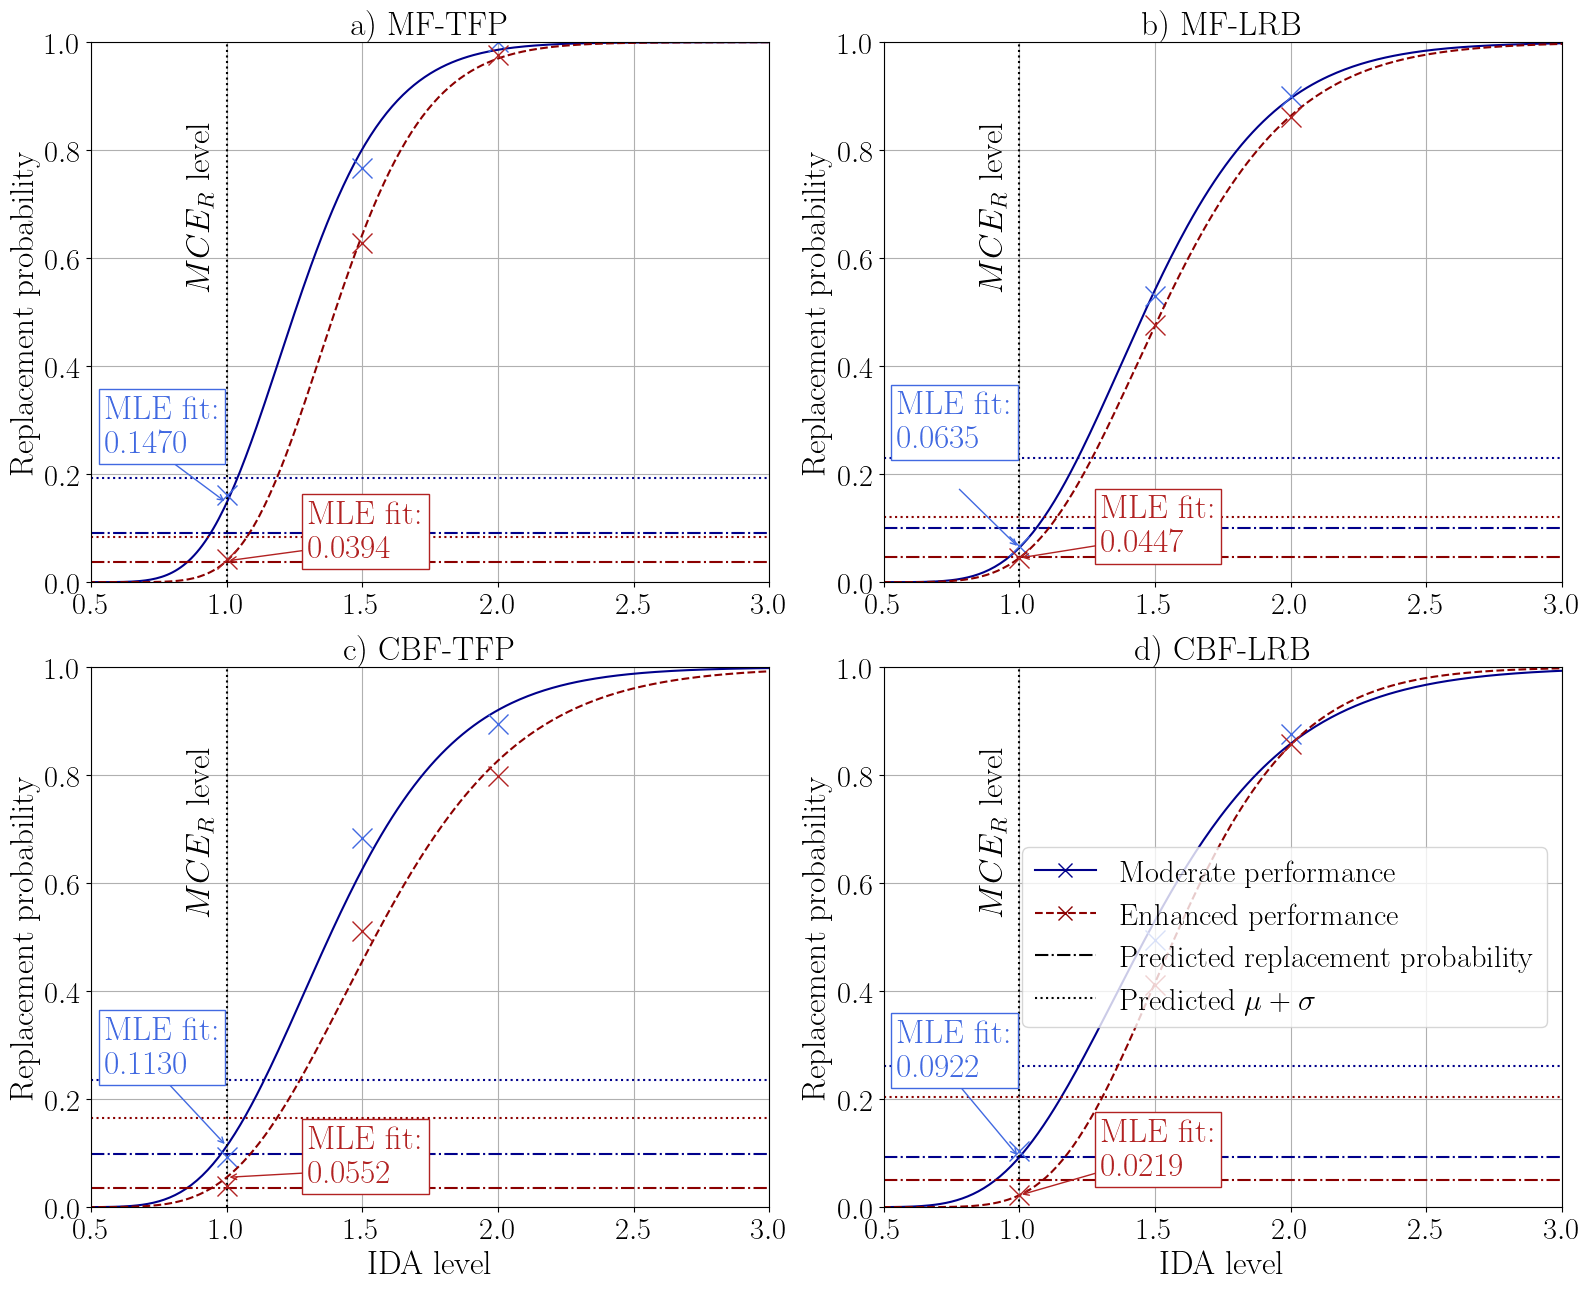

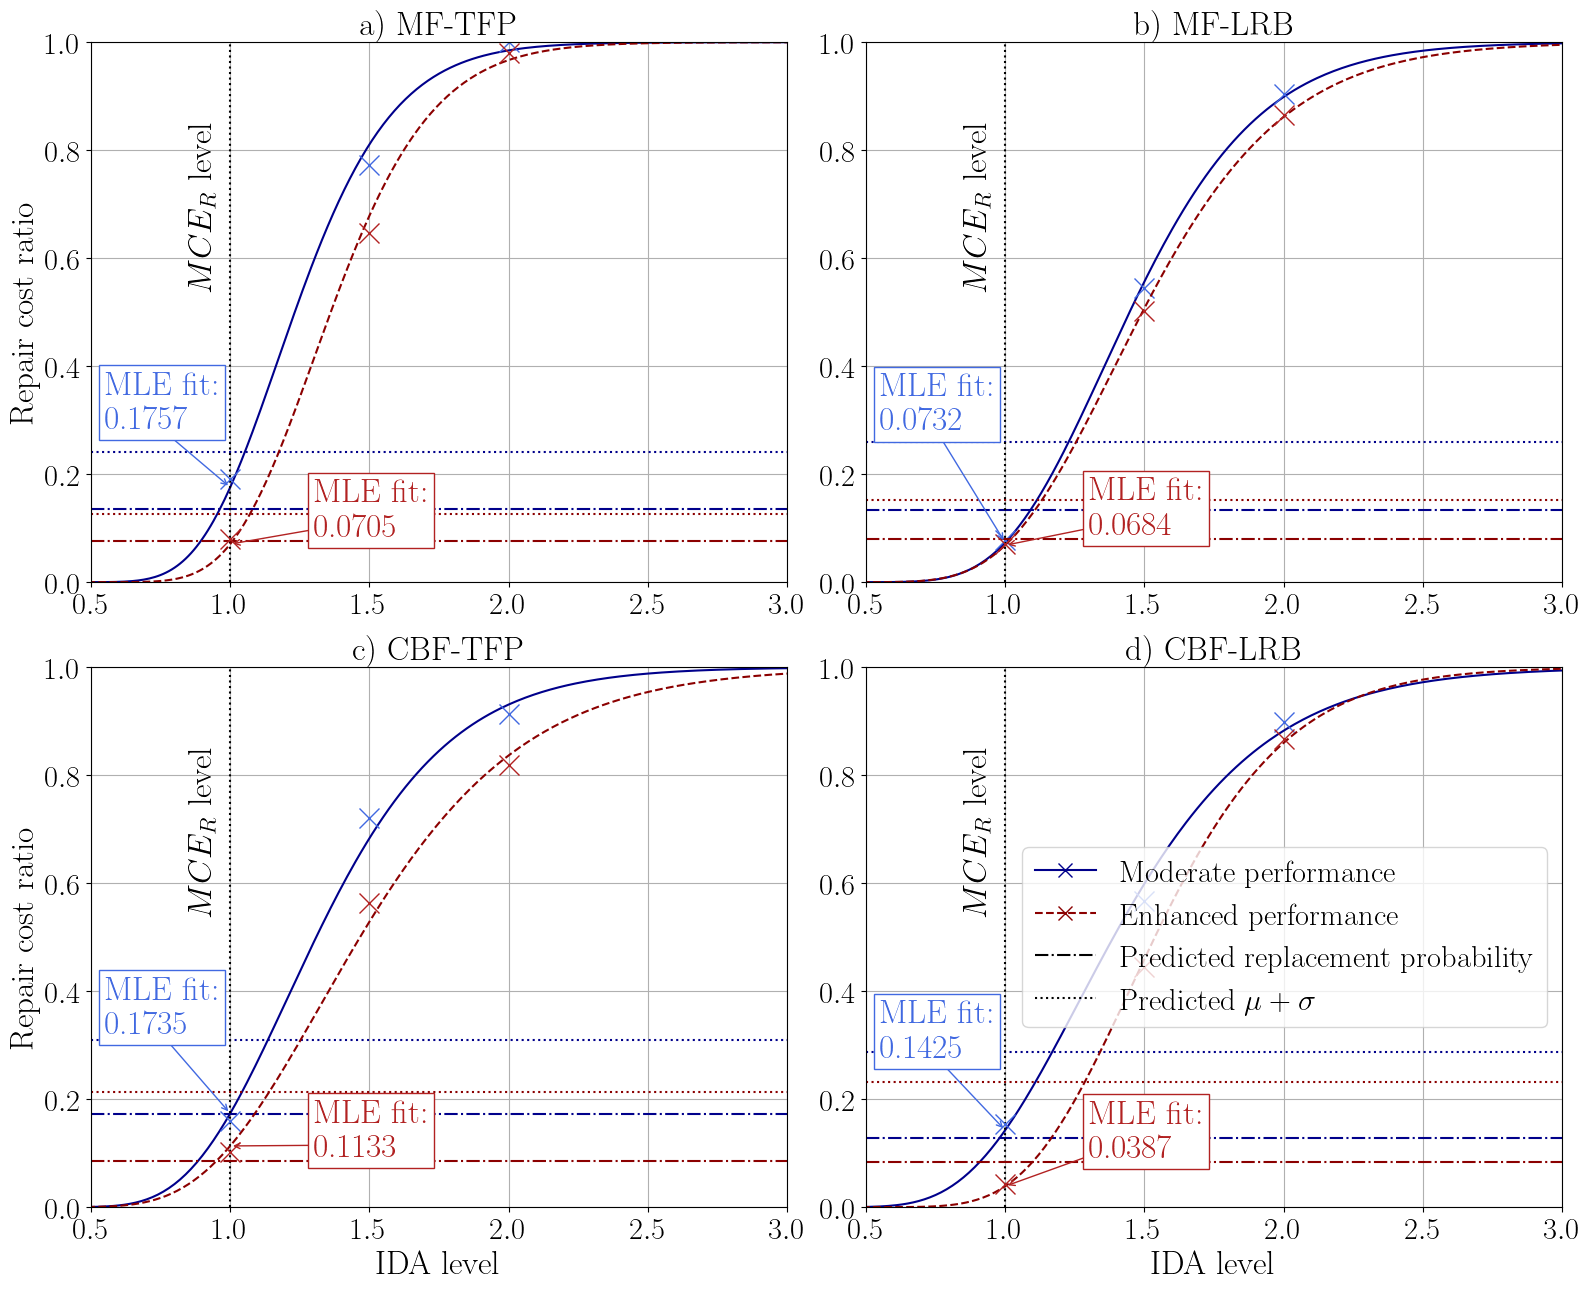

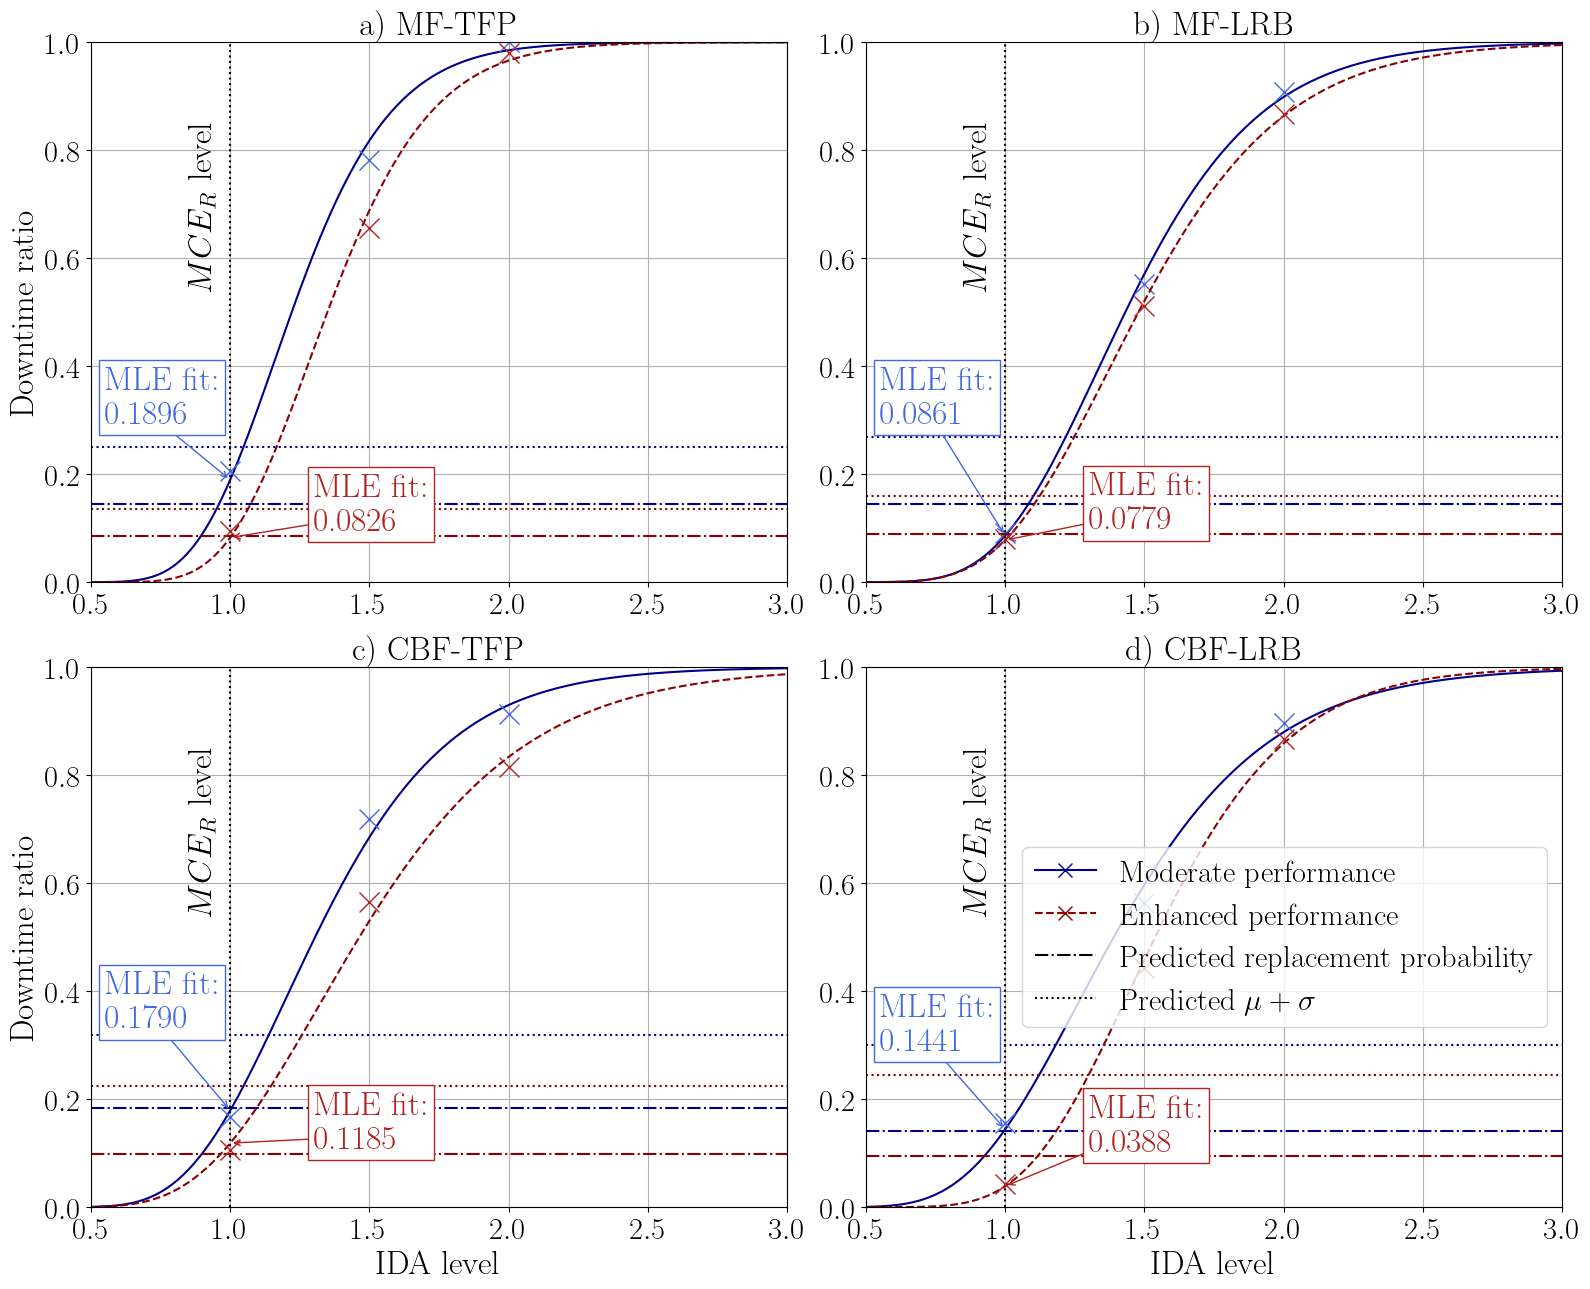

In [70]:
# TODO: replacement frag curves
def neg_log_likelihood_sum(params, im_l, no_a, no_c):
    from scipy import stats
    import numpy as np
    sigma, beta = params
    theoretical_fragility_function = stats.norm(np.log(sigma), beta).cdf(im_l)
    likelihood = stats.binom.pmf(no_c, no_a, theoretical_fragility_function)
    log_likelihood = np.log(likelihood)
    log_likelihood_sum = np.sum(log_likelihood)

    return -log_likelihood_sum

def mle_fit_collapse(ida_levels, pr_collapse):
    from functools import partial
    import numpy as np
    from scipy import optimize
    
    im_log = np.log(ida_levels)
    number_of_analyses = np.array([1000, 1000, 1000 ])
    number_of_collapses = np.round(1000*pr_collapse)
    
    neg_log_likelihood_sum_partial = partial(
        neg_log_likelihood_sum, im_l=im_log, no_a=number_of_analyses, no_c=number_of_collapses)
    
    
    res = optimize.minimize(neg_log_likelihood_sum_partial, (1, 1), method="Nelder-Mead")
    return res.x[0], res.x[1]

inverse_color = 'darkblue'
inverse_color_2 = 'royalblue'
strict_color = 'darkred'
strict_color_2 = 'firebrick'



# print out the results
ida_levels = [1.0, 1.5, 2.0]

from scipy.stats import norm
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 24
label_size = 22
title_font=24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
from matplotlib.lines import Line2D
# plt.close('all')

fig = plt.figure(figsize=(16, 13))

## MF-TFP

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_val_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_repl_risk = mf_tfp_inv_pred['replacement_freq']
mf_tfp_repl_risk_var = mf_tfp_inv_pred['replacement_freq_var']
upper = mf_tfp_repl_risk+mf_tfp_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_tfp_repl_risk, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')

# ax1.text(1.5,mf_tfp_repl_risk+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_tfp_repl_risk+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_tfp_repl_risk+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

# ax1.set_ylabel('Replacement probability', fontsize=axis_font)
# ax1.set_title('MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_val_repl[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_strict_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_repl_risk = mf_tfp_strict_pred['replacement_freq']
mf_tfp_repl_risk_var = mf_tfp_strict_pred['replacement_freq_var']
upper = mf_tfp_repl_risk+mf_tfp_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_tfp_repl_risk, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_tfp_repl_risk+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_tfp_repl_risk+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

ax1.set_ylabel('Replacement probability', fontsize=axis_font)
ax1.set_title('a) MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_strict_repl[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])


####

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_val_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_repl_risk = mf_lrb_inv_pred['replacement_freq']
mf_lrb_repl_risk_var = mf_lrb_inv_pred['replacement_freq_var']
upper = mf_lrb_repl_risk+mf_lrb_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 2)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_lrb_repl_risk, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,mf_lrb_repl_risk+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)


bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_tfp_repl_risk+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_lrb_repl_risk+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

# ax1.set_ylabel('Replacement probability', fontsize=axis_font)
# ax1.set_title('MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_val_repl[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_strict_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_repl_risk = mf_lrb_strict_pred['replacement_freq']
mf_lrb_repl_risk_var = mf_lrb_strict_pred['replacement_freq_var']
upper = mf_lrb_repl_risk+mf_lrb_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_lrb_repl_risk, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_lrb_repl_risk+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_lrb_repl_risk+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


ax1.set_ylabel('Replacement probability', fontsize=axis_font)
ax1.set_title('b) MF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_strict_repl[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_val_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_repl_risk = cbf_tfp_inv_pred['replacement_freq']
cbf_tfp_repl_risk_var = cbf_tfp_inv_pred['replacement_freq_var']
upper = cbf_tfp_repl_risk+cbf_tfp_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 3)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_tfp_repl_risk, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_tfp_repl_risk+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_tfp_repl_risk+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_tfp_repl_risk+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

# ax1.set_ylabel('Replacement probability', fontsize=axis_font)
# ax1.set_title('MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_val_repl[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_strict_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_repl_risk = cbf_tfp_strict_pred['replacement_freq']
cbf_tfp_repl_risk_var = cbf_tfp_strict_pred['replacement_freq_var']
upper = cbf_tfp_repl_risk+cbf_tfp_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_tfp_repl_risk, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)


bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_tfp_repl_risk+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_tfp_repl_risk+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


ax1.set_ylabel('Replacement probability', fontsize=axis_font)
ax1.set_title('c) CBF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_strict_repl[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])
ax1.set_xlabel('IDA level', fontsize=axis_font)
######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_val_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_repl_risk = cbf_lrb_inv_pred['replacement_freq']
cbf_lrb_repl_risk_var = cbf_lrb_inv_pred['replacement_freq_var']
upper = cbf_lrb_repl_risk+cbf_lrb_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 4)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_lrb_repl_risk, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_lrb_repl_risk+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_lrb_repl_risk+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_lrb_repl_risk+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)


ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

# ax1.set_ylabel('Replacement probability', fontsize=axis_font)
# ax1.set_title('MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_val_repl[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_strict_repl)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_repl_risk = cbf_lrb_strict_pred['replacement_freq']
cbf_lrb_repl_risk_var = cbf_lrb_strict_pred['replacement_freq_var']
upper = cbf_lrb_repl_risk+cbf_lrb_repl_risk_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_lrb_repl_risk, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)


bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_lrb_repl_risk+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_lrb_repl_risk+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


ax1.set_ylabel('Replacement probability', fontsize=axis_font)
ax1.set_title('d) CBF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_strict_repl[i]], 
              marker='x', markersize=15, color=strict_color_2)
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])
ax1.set_xlabel('IDA level', fontsize=axis_font)
fig.tight_layout()

    
custom_lines = [
                Line2D([-1], [-1], color=inverse_color, linestyle='-', marker='x', markersize=10),
                Line2D([-1], [-1], color=strict_color, linestyle='--', marker='x', markersize=10),
                Line2D([-1], [-1], color='black', linestyle='-.'),
                Line2D([-1], [-1], color='black', linestyle=':'),
                ]

ax1.legend(custom_lines, ['Moderate performance', 'Enhanced performance', 
                          'Predicted replacement probability', r'Predicted $\mu+\sigma$'], 
           fontsize=subt_font-2, loc='center right')

plt.savefig('./eng_struc_figures/inverse_repl_frag_eesd.pdf')
plt.show()

#%% cost validation frag

# print out the results
ida_levels = [1.0, 1.5, 2.0]

from scipy.stats import norm
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 24
label_size = 22
title_font=24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
from matplotlib.lines import Line2D
# plt.close('all')

fig = plt.figure(figsize=(16, 13))


## MF-TFP

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_val_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_cost_ratio = mf_tfp_inv_pred['cost']
mf_tfp_cost_ratio_var = mf_tfp_inv_pred['cost_var']
upper = mf_tfp_cost_ratio+mf_tfp_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_tfp_cost_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,mf_tfp_cost_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_tfp_cost_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_tfp_cost_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_val_cost_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_strict_cost_ratio)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_cost_ratio = mf_tfp_strict_pred['cost']
mf_tfp_cost_ratio_var = mf_tfp_strict_pred['cost_var']
upper = mf_tfp_cost_ratio+mf_tfp_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_tfp_cost_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_tfp_cost_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_tfp_cost_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


ax1.set_ylabel('Repair cost ratio', fontsize=axis_font)
ax1.set_title('a) MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_strict_cost_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])


####

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_val_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_cost_ratio = mf_lrb_inv_pred['cost']
mf_lrb_cost_ratio_var = mf_lrb_inv_pred['cost_var']
upper = mf_lrb_cost_ratio+mf_lrb_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 2)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_lrb_cost_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,mf_lrb_cost_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_lrb_cost_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_lrb_cost_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_val_cost_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_strict_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_cost_ratio = mf_lrb_strict_pred['cost']
mf_lrb_cost_ratio_var = mf_lrb_strict_pred['cost_var']
upper = mf_lrb_cost_ratio+mf_lrb_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_lrb_cost_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_lrb_cost_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_lrb_cost_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


# ax1.set_ylabel('Repair cost ratio', fontsize=axis_font)
ax1.set_title('b) MF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_strict_cost_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_val_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_cost_ratio = cbf_tfp_inv_pred['cost']
cbf_tfp_cost_ratio_var = cbf_tfp_inv_pred['cost_var']
upper = cbf_tfp_cost_ratio+cbf_tfp_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 3)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_tfp_cost_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_tfp_cost_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)


bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_tfp_cost_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_tfp_cost_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_val_cost_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_strict_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_cost_ratio = cbf_tfp_strict_pred['cost']
cbf_tfp_cost_ratio_var = cbf_tfp_strict_pred['cost_var']
upper = cbf_tfp_cost_ratio+cbf_tfp_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_tfp_cost_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_tfp_cost_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_tfp_cost_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)


ax1.set_xlabel('IDA level', fontsize=axis_font)
ax1.set_ylabel('Repair cost ratio', fontsize=axis_font)
ax1.set_title('c) CBF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_strict_cost_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_val_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_cost_ratio = cbf_lrb_inv_pred['cost']
cbf_lrb_cost_ratio_var = cbf_lrb_inv_pred['cost_var']
upper = cbf_lrb_cost_ratio+cbf_lrb_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 4)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_lrb_cost_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_lrb_cost_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)


bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_lrb_cost_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_lrb_cost_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_val_cost_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_strict_cost_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_cost_ratio = cbf_lrb_strict_pred['cost']
cbf_lrb_cost_ratio_var = cbf_lrb_strict_pred['cost_var']
upper = cbf_lrb_cost_ratio+cbf_lrb_cost_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_lrb_cost_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_lrb_cost_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_lrb_cost_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

ax1.set_xlabel('IDA level', fontsize=axis_font)
ax1.set_title('d) CBF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_strict_cost_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

fig.tight_layout()

    
custom_lines = [
                Line2D([-1], [-1], color=inverse_color, linestyle='-', marker='x', markersize=10),
                Line2D([-1], [-1], color=strict_color, linestyle='--', marker='x', markersize=10),
                Line2D([-1], [-1], color='black', linestyle='-.'),
                Line2D([-1], [-1], color='black', linestyle=':'),
                ]

ax1.legend(custom_lines, ['Moderate performance', 'Enhanced performance', 
                          'Predicted replacement probability', r'Predicted $\mu+\sigma$'], 
           fontsize=subt_font-2, loc='center right')

plt.savefig('./eng_struc_figures/inverse_cost_frag_eesd.pdf')

plt.show()

#%% time validation frag

# print out the results
ida_levels = [1.0, 1.5, 2.0]

from scipy.stats import norm
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 24
label_size = 22
title_font=24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
from matplotlib.lines import Line2D
# plt.close('all')

fig = plt.figure(figsize=(16, 13))


## MF-TFP

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_val_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_downtime_ratio = mf_tfp_inv_pred['time']
mf_tfp_downtime_ratio_var = mf_tfp_inv_pred['time_var']
upper = mf_tfp_downtime_ratio+mf_tfp_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_tfp_downtime_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,mf_tfp_downtime_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_tfp_downtime_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_tfp_downtime_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_val_downtime_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_tfp_strict_downtime_ratio)
p = f(xx_pr, theta_inv, beta_inv)

mf_tfp_downtime_ratio = mf_tfp_strict_pred['time']
mf_tfp_downtime_ratio_var = mf_tfp_strict_pred['time_var']
upper = mf_tfp_downtime_ratio+mf_tfp_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_tfp_downtime_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_tfp_downtime_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_tfp_downtime_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

ax1.set_ylabel('Downtime ratio', fontsize=axis_font)
ax1.set_title('a) MF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_tfp_strict_downtime_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])


####

# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_val_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_downtime_ratio = mf_lrb_inv_pred['time']
mf_lrb_downtime_ratio_var = mf_lrb_inv_pred['time_var']
upper = mf_lrb_downtime_ratio+mf_lrb_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 2)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(mf_lrb_downtime_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,mf_lrb_downtime_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, mf_lrb_downtime_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, mf_lrb_downtime_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_val_downtime_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,mf_lrb_strict_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

mf_lrb_downtime_ratio = mf_lrb_strict_pred['time']
mf_lrb_downtime_ratio_var = mf_lrb_strict_pred['time_var']
upper = mf_lrb_downtime_ratio+mf_lrb_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(mf_lrb_downtime_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, mf_lrb_downtime_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, mf_lrb_downtime_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

# ax1.set_ylabel('Repair time ratio', fontsize=axis_font)
ax1.set_title('b) MF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [mf_lrb_strict_downtime_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_val_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_downtime_ratio = cbf_tfp_inv_pred['time']
cbf_tfp_downtime_ratio_var = cbf_tfp_inv_pred['time_var']
upper = cbf_tfp_downtime_ratio+cbf_tfp_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 3)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_tfp_downtime_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_tfp_downtime_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_tfp_downtime_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_tfp_downtime_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_val_downtime_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_tfp_strict_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_tfp_downtime_ratio = cbf_tfp_strict_pred['time']
cbf_tfp_downtime_ratio_var = cbf_tfp_strict_pred['time_var']
upper = cbf_tfp_downtime_ratio+cbf_tfp_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_tfp_downtime_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_tfp_downtime_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_tfp_downtime_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

ax1.set_xlabel('IDA level', fontsize=axis_font)
ax1.set_ylabel('Downtime ratio', fontsize=axis_font)
ax1.set_title('c) CBF-TFP', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_tfp_strict_downtime_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
    
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

######
# regular
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_val_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_downtime_ratio = cbf_lrb_inv_pred['time']
cbf_lrb_downtime_ratio_var = cbf_lrb_inv_pred['time_var']
upper = cbf_lrb_downtime_ratio+cbf_lrb_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 4)
ax1.plot(xx_pr, p, color=inverse_color)
ax1.axhline(cbf_lrb_downtime_ratio, linestyle='-.', color=inverse_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=inverse_color, linewidth=1.5)
ax1.axvline(1.0, linestyle=':', color='black')
# ax1.text(1.5,cbf_lrb_downtime_ratio+0.02, r'Predicted replacement risk',
#           fontsize=subt_font, color=inverse_color)
# ax1.text(1.5,upper+0.02, r'$+1\sigma$',
#           fontsize=subt_font, color=inverse_color)

bbox_props = dict(facecolor='white', edgecolor=inverse_color_2)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(0.75, cbf_lrb_downtime_ratio+0.15), 
             arrowprops=dict(arrowstyle='->', color=inverse_color_2),
             bbox=bbox_props)
ax1.text(0.55, cbf_lrb_downtime_ratio+0.15, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=inverse_color_2, bbox=bbox_props, zorder=5)

ax1.text(0.85, 0.55, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_val_downtime_ratio[i]], 
              marker='x', markersize=15, color=inverse_color_2)

# strict
theta_inv, beta_inv = mle_fit_collapse(ida_levels,cbf_lrb_strict_downtime_ratio)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_inv, beta_inv)

cbf_lrb_downtime_ratio = cbf_lrb_strict_pred['time']
cbf_lrb_downtime_ratio_var = cbf_lrb_strict_pred['time_var']
upper = cbf_lrb_downtime_ratio+cbf_lrb_downtime_ratio_var**0.5

MCE_level = float(p[xx_pr==1.0])
ax1.plot(xx_pr, p, color=strict_color, linestyle='--')
ax1.axhline(cbf_lrb_downtime_ratio, linestyle='-.', color=strict_color, linewidth=1.5)
ax1.axhline(upper, linestyle=':', color=strict_color, linewidth=1.5)

bbox_props = dict(facecolor='white', edgecolor=strict_color_2)
ax1.text(1.3, cbf_lrb_downtime_ratio+0.01, f'MLE fit: \n {MCE_level:,.4f}',
          fontsize=subt_font, color=strict_color_2, bbox=bbox_props, zorder=5)
ax1.annotate(text='', xy=(1.0,MCE_level), xytext=(1.4, cbf_lrb_downtime_ratio+0.03), 
             arrowprops=dict(arrowstyle='->', color=strict_color_2),
             bbox=bbox_props)

ax1.set_xlabel('IDA level', fontsize=axis_font)
ax1.set_title('d) CBF-LRB', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [cbf_lrb_strict_downtime_ratio[i]], 
              marker='x', markersize=15, color=strict_color_2)
ax1.grid(True)
ax1.set_xlim([0.5, 3.0])
ax1.set_ylim([0, 1.0])

fig.tight_layout()

    
custom_lines = [
                Line2D([-1], [-1], color=inverse_color, linestyle='-', marker='x', markersize=10),
                Line2D([-1], [-1], color=strict_color, linestyle='--', marker='x', markersize=10),
                Line2D([-1], [-1], color='black', linestyle='-.'),
                Line2D([-1], [-1], color='black', linestyle=':'),
                ]

ax1.legend(custom_lines, ['Moderate performance', 'Enhanced performance', 
                          'Predicted replacement probability', r'Predicted $\mu+\sigma$'], 
           fontsize=subt_font-2, loc='center right')

plt.savefig('./eng_struc_figures/inverse_time_frag_eesd.pdf')
plt.show()


## Distributions

MF-TFP runs requiring replacement: 4
MF-LRB runs requiring replacement: 2
CBF-TFP runs requiring replacement: 4
CBF-LRB runs requiring replacement: 4
MF-TFP runs requiring replacement: 1
MF-LRB runs requiring replacement: 2
CBF-TFP runs requiring replacement: 1
CBF-LRB runs requiring replacement: 1
MF-TFP runs requiring replacement: 4
MF-LRB runs requiring replacement: 2
CBF-TFP runs requiring replacement: 4
CBF-LRB runs requiring replacement: 4
MF-TFP runs requiring replacement: 1
MF-LRB runs requiring replacement: 2
CBF-TFP runs requiring replacement: 1
CBF-LRB runs requiring replacement: 1


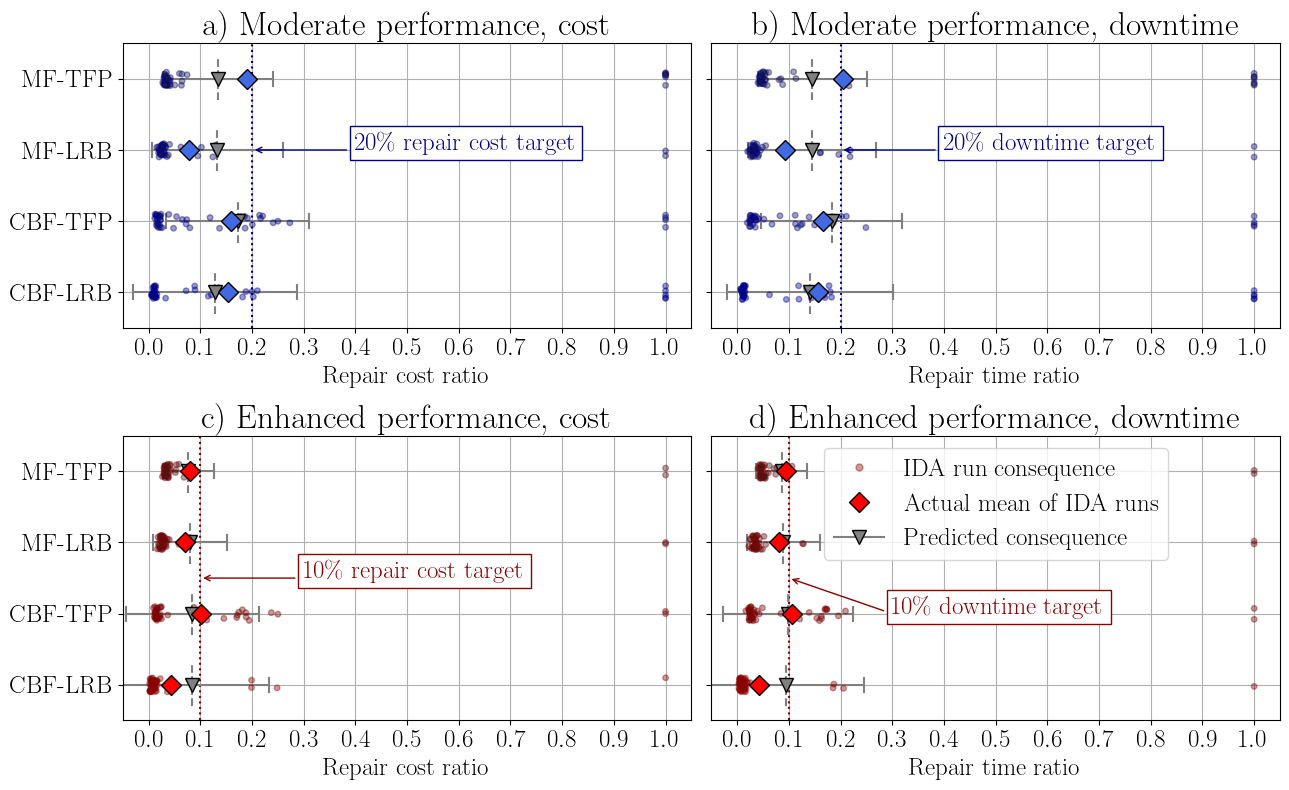

In [71]:
#%% cost validation distr

def plot_predictions(mean, var, y_middle, y_bar, color):
    middle = mean
    upper = mean + var**0.5
    lower = mean - var**0.5
    
    ax.plot(middle, y_bar, 'v', ms=10, markeredgecolor='black', markerfacecolor=color, zorder=5)
    ax.plot([lower, upper], 
            [y_bar,y_bar], color=color)
    
    ax.axvline(middle, ymin=y_middle-0.075, ymax=y_middle+0.075, linestyle='--', color=color)
    ax.axvline(lower, ymin=y_middle-0.025, ymax=y_middle+0.025, color=color)
    ax.axvline(upper, ymin=y_middle-0.025, ymax=y_middle+0.025, color=color)
    
plt.close('all')
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 18
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'None'},
    'medianprops':{'color':'None'},
    'whiskerprops':{'color':'None'},
    'capprops':{'color':'None'}
}

# fig, axes = plt.subplots(1, 1, 
#                          figsize=(10, 6))

inverse_color = 'darkblue'
inverse_color_2 = 'royalblue'
strict_color = 'darkred'
strict_color_2 = 'red'

fig = plt.figure(figsize=(13, 8))

### regular
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[cost_var]),
               ('MF-LRB', mf_lrb_ida[cost_var]),
               ('CBF-TFP', cbf_tfp_ida[cost_var]),
               ('CBF-LRB', cbf_lrb_ida[cost_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_cost = cbf_tfp_inv_pred['cost']
mf_tfp_repair_cost = mf_tfp_inv_pred['cost']
cbf_lrb_repair_cost = cbf_lrb_inv_pred['cost']
mf_lrb_repair_cost = mf_lrb_inv_pred['cost']

cbf_tfp_repair_cost_var = cbf_tfp_inv_pred['cost_var']
mf_tfp_repair_cost_var = mf_tfp_inv_pred['cost_var']
cbf_lrb_repair_cost_var = cbf_lrb_inv_pred['cost_var']
mf_lrb_repair_cost_var = mf_lrb_inv_pred['cost_var']


ax=fig.add_subplot(2, 2, 1)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
ax = sns.stripplot(data=df_dt, orient='h', color=inverse_color, alpha=0.4, size=4,
                   edgecolor=inverse_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=inverse_color_2, zorder=20)
ax.axvline(0.2, color=inverse_color, linestyle=':')
sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair cost ratio', fontsize=axis_font)




plot_predictions(mf_tfp_repair_cost, mf_tfp_repair_cost_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_cost, mf_lrb_repair_cost_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_cost, cbf_tfp_repair_cost_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_cost, cbf_lrb_repair_cost_var, 0.125, 3, 'gray')
ax.set_xlim([-0.05, 1.05])

bbox_props = dict(facecolor='white', edgecolor=inverse_color)
ax.text(0.4, 1, r'20\% repair cost target',
          fontsize=subt_font, color=inverse_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.2, 1), xytext=(0.4, 1), 
             arrowprops=dict(arrowstyle='->', color=inverse_color),
             bbox=bbox_props)

ax.grid(visible=True)
ax.set_title('a) Moderate performance, cost', fontsize=title_font)
### strict
ax=fig.add_subplot(2, 2, 3)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
cbf_tfp_ida = cbf_tfp_strict_results[cbf_tfp_strict_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_strict_results[mf_tfp_strict_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_strict_results[cbf_lrb_strict_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_strict_results[mf_lrb_strict_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[cost_var]),
                ('MF-LRB', mf_lrb_ida[cost_var]),
                ('CBF-TFP', cbf_tfp_ida[cost_var]),
                ('CBF-LRB', cbf_lrb_ida[cost_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_cost = cbf_tfp_strict_pred['cost']
mf_tfp_repair_cost = mf_tfp_strict_pred['cost']
cbf_lrb_repair_cost = cbf_lrb_strict_pred['cost']
mf_lrb_repair_cost = mf_lrb_strict_pred['cost']

cbf_tfp_repair_cost_var = cbf_tfp_strict_pred['cost_var']
mf_tfp_repair_cost_var = mf_tfp_strict_pred['cost_var']
cbf_lrb_repair_cost_var = cbf_lrb_strict_pred['cost_var']
mf_lrb_repair_cost_var = mf_lrb_strict_pred['cost_var']

ax = sns.stripplot(data=df_dt, orient='h', color=strict_color, alpha=0.4, size=4,
                    edgecolor=strict_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=strict_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax.axvline(0.1, color=strict_color, linestyle=':')

bbox_props = dict(facecolor='white', edgecolor=strict_color)
ax.text(0.3, 1.5, r'10\% repair cost target',
          fontsize=subt_font, color=strict_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.1, 1.5), xytext=(0.3, 1.5), 
             arrowprops=dict(arrowstyle='->', color=strict_color),
             bbox=bbox_props)

plot_predictions(mf_tfp_repair_cost, mf_tfp_repair_cost_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_cost, mf_lrb_repair_cost_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_cost, cbf_tfp_repair_cost_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_cost, cbf_lrb_repair_cost_var, 0.125, 3, 'gray')
ax.set_xlim([-0.05, 1.05])
ax.grid(visible=True)
ax.set_title('c) Enhanced performance, cost', fontsize=title_font)

###### time

### regular
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[time_var]),
               ('MF-LRB', mf_lrb_ida[time_var]),
               ('CBF-TFP', cbf_tfp_ida[time_var]),
               ('CBF-LRB', cbf_lrb_ida[time_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_time = cbf_tfp_inv_pred['time']
mf_tfp_repair_time = mf_tfp_inv_pred['time']
cbf_lrb_repair_time = cbf_lrb_inv_pred['time']
mf_lrb_repair_time = mf_lrb_inv_pred['time']

cbf_tfp_repair_time_var = cbf_tfp_inv_pred['time_var']
mf_tfp_repair_time_var = mf_tfp_inv_pred['time_var']
cbf_lrb_repair_time_var = cbf_lrb_inv_pred['time_var']
mf_lrb_repair_time_var = mf_lrb_inv_pred['time_var']


ax=fig.add_subplot(2, 2, 2)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
ax = sns.stripplot(data=df_dt, orient='h', color=inverse_color, alpha=0.4, size=4,
                   edgecolor=inverse_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=inverse_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax.axvline(0.2, color=inverse_color, linestyle=':')

plot_predictions(mf_tfp_repair_time, mf_tfp_repair_time_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_time, mf_lrb_repair_time_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_time, cbf_tfp_repair_time_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_time, cbf_lrb_repair_time_var, 0.125, 3, 'gray')

bbox_props = dict(facecolor='white', edgecolor=inverse_color)
ax.text(0.4, 1, r'20\% downtime target',
          fontsize=subt_font, color=inverse_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.2, 1), xytext=(0.4, 1), 
             arrowprops=dict(arrowstyle='->', color=inverse_color),
             bbox=bbox_props)

ax.grid(visible=True)
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-0.05, 1.05])
ax.set_title('b) Moderate performance, downtime', fontsize=title_font)
### strict
ax=fig.add_subplot(2, 2, 4)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
cbf_tfp_ida = cbf_tfp_strict_results[cbf_tfp_strict_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_strict_results[mf_tfp_strict_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_strict_results[cbf_lrb_strict_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_strict_results[mf_lrb_strict_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[time_var]),
                ('MF-LRB', mf_lrb_ida[time_var]),
                ('CBF-TFP', cbf_tfp_ida[time_var]),
                ('CBF-LRB', cbf_lrb_ida[time_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_time = cbf_tfp_strict_pred['time']
mf_tfp_repair_time = mf_tfp_strict_pred['time']
cbf_lrb_repair_time = cbf_lrb_strict_pred['time']
mf_lrb_repair_time = mf_lrb_strict_pred['time']

cbf_tfp_repair_time_var = cbf_tfp_strict_pred['time_var']
mf_tfp_repair_time_var = mf_tfp_strict_pred['time_var']
cbf_lrb_repair_time_var = cbf_lrb_strict_pred['time_var']
mf_lrb_repair_time_var = mf_lrb_strict_pred['time_var']

ax = sns.stripplot(data=df_dt, orient='h', color=strict_color, alpha=0.4, size=4,
                    edgecolor=strict_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=strict_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax.axvline(0.1, color=strict_color, linestyle=':')

bbox_props = dict(facecolor='white', edgecolor=strict_color)
ax.text(0.3, 2.0, r'10\% downtime target',
          fontsize=subt_font, color=strict_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.1, 1.5), xytext=(0.3, 2.0), 
             arrowprops=dict(arrowstyle='->', color=strict_color),
             bbox=bbox_props)

plot_predictions(mf_tfp_repair_time, mf_tfp_repair_time_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_time, mf_lrb_repair_time_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_time, cbf_tfp_repair_time_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_time, cbf_lrb_repair_time_var, 0.125, 3, 'gray')

ax.grid(visible=True)
ax.axes.yaxis.set_ticklabels([])
ax.set_title('d) Enhanced performance, downtime', fontsize=title_font)

import matplotlib.patches as mpatches
custom_lines = [
                Line2D([-1], [-1], color='white', marker='o', markeredgecolor=strict_color,
                       alpha=0.4, markerfacecolor=strict_color, markersize=5),
                Line2D([-1], [-1], color='white', marker='D', markeredgecolor='black'
                       , markerfacecolor=strict_color_2, markersize=10),
                Line2D([0, 0], [-1, 1], color='gray', marker='v', markeredgecolor='black',
                       markerfacecolor='gray', markersize=10)
                ]

ax.legend(custom_lines, ['IDA run consequence', 'Actual mean of IDA runs', 
                         'Predicted consequence'], 
           fontsize=subt_font)

ax.set_xlim([-0.05, 1.05])
fig.tight_layout()

plt.savefig('./eng_struc_figures/inverse_dv_distro_eesd.pdf')
plt.show()

# Additional figures/analyses

## Filter design graphic

TypeError: len() of unsized object

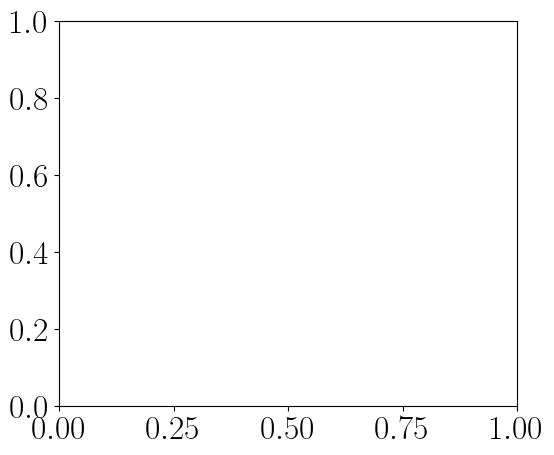

In [38]:
#%% filter design graphic

# TODO: filter

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=24
axis_font = 24
subt_font = 22
label_size = 24
clabel_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

from matplotlib.lines import Line2D
fig = plt.figure(figsize=(13, 11))

#################################
xvar = 'gap_ratio'
yvar = 'RI'

# lvls_cost = np.array([0.2])
# lvls_time = np.array([0.2])
# lvls_repl = np.array([0.1])

# lvls_cost_enhanced = np.array([0.1])
# lvls_time_enhanced = np.array([0.1])
# lvls_repl_enhanced = np.array([0.05])

lvls_cost = 0.2
lvls_time = 0.2
lvls_repl = 0.1

lvls_cost_enhanced = 0.1
lvls_time_enhanced = 0.1
lvls_repl_enhanced = 0.05

res = 100
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 3.2, fourth_var_set = 0.24)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)


#### MF-TFP

ax = fig.add_subplot(2, 2, 1)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_time_mf_tfp_i.gpr,
                       mdl_time_mf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(.6, 1.5)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.6, 1.5, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)



ax.set_title('a) MF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

custom_lines = [Line2D([-1], [-1], color='black', 
                       linestyle='-' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle='--' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle=':' ),
                ]

ax.legend(custom_lines, ['20\% repair cost ratio', '20\% repair time ratio', '10\% replacement probability'], 
           fontsize=subt_font, loc='lower right')

#### MF-LRB
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.35, fourth_var_set = 0.20)

ax = fig.add_subplot(2, 2, 2)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_cost_mf_lrb_i.gpr,
                       mdl_cost_mf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_time_mf_lrb_i.gpr,
                       mdl_time_mf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_repl_mf_lrb_i.gpr,
                       mdl_repl_mf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(0.9, 1.5)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.5, 1.0, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)


ax.set_title('b) MF-LRB', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

#### CBF-TFP
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 5.79, fourth_var_set = 0.23)
ax = fig.add_subplot(2, 2, 3)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_cost_cbf_tfp_i.gpr,
                       mdl_cost_cbf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_time_cbf_tfp_i.gpr,
                       mdl_time_cbf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_repl_cbf_tfp_i.gpr,
                       mdl_repl_cbf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(1.0, 1.25)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.5, 1.0, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)

ax.set_title('c) CBF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()

#### CBF-LRB
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 4.79, fourth_var_set = 0.21)
ax = fig.add_subplot(2, 2, 4)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_cost_cbf_lrb_i.gpr,
                       mdl_cost_cbf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_time_cbf_lrb_i.gpr,
                       mdl_time_cbf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.65, 0.8, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)


ax.set_title('d) CBF-LRB', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()
# plt.savefig('./eng_struc_figures/filter_design.pdf')
# ax.text(1.2, 1.00, 'OK space',
#           fontsize=axis_font, color='green')
#%% filter design graphic

# TODO: filter, secondary variables

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

from matplotlib.lines import Line2D
fig = plt.figure(figsize=(13, 11))

#################################
xvar = 'T_ratio'
yvar = 'zeta_e'

lvls_cost = np.array([0.2])
lvls_time = np.array([0.2])
lvls_repl = np.array([0.1])

res = 100
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 0.88, fourth_var_set = 2.25)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)


#### MF-TFP

ax = fig.add_subplot(2, 2, 1)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_time_mf_tfp_i.gpr,
                       mdl_time_mf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[lvls_repl, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[lvls_time, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[lvls_cost, 1.0])

ax.grid(visible=True)

custom_lines = [Line2D([-1], [-1], color='black', 
                       linestyle='-' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle='--' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle=':' ),
                ]

ax.legend(custom_lines, ['Repair cost ratio', 'Repair time ratio', 'Replacement probability'], 
           fontsize=subt_font)

ax.set_title('a) MF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


# ax.set_xlim([0.35, 2.0])
# ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

#### MF-LRB
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.19, fourth_var_set = 2.25)

ax = fig.add_subplot(2, 2, 2)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_cost_mf_lrb_i.gpr,
                       mdl_cost_mf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_time_mf_lrb_i.gpr,
                       mdl_time_mf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_repl_mf_lrb_i.gpr,
                       mdl_repl_mf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[lvls_repl, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[lvls_time, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[lvls_cost, 1.0])

ax.grid(visible=True)


ax.set_title('b) MF-LRB', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


# ax.set_xlim([0.35, 2.0])
# ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

#### CBF-TFP
X_plot = make_2D_plotting_space(df_cbf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.26, fourth_var_set = 2.16)
ax = fig.add_subplot(2, 2, 3)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_cost_cbf_tfp_i.gpr,
                       mdl_cost_cbf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_time_cbf_tfp_i.gpr,
                       mdl_time_cbf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_repl_cbf_tfp_i.gpr,
                       mdl_repl_cbf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[lvls_repl, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[lvls_time, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[lvls_cost, 1.0])

ax.grid(visible=True)


ax.set_title('c) CBF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)



# ax.set_xlim([0.35, 2.0])
# ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)

fig.tight_layout()

#### CBF-LRB
X_plot = make_2D_plotting_space(df_cbf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.52, fourth_var_set = 1.97)
ax = fig.add_subplot(2, 2, 4)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_cost_cbf_lrb_i.gpr,
                       mdl_cost_cbf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_time_cbf_lrb_i.gpr,
                       mdl_time_cbf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = 0.1
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[lvls_repl, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[lvls_time, 1.0])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
ax.clabel(cs, fontsize=clabel_size)
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[lvls_cost, 1.0])

ax.grid(visible=True)


ax.set_title('d) CBF-LRB', fontsize=title_font)
ax.set_xlabel(r'$T_M/T_{fb}$', fontsize=axis_font)
# ax.set_ylabel(r'$\zeta_M$', fontsize=axis_font)


# ax.set_xlim([0.35, 2.0])
# ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)

fig.tight_layout()

## Generalized MLE curves and ECDFs

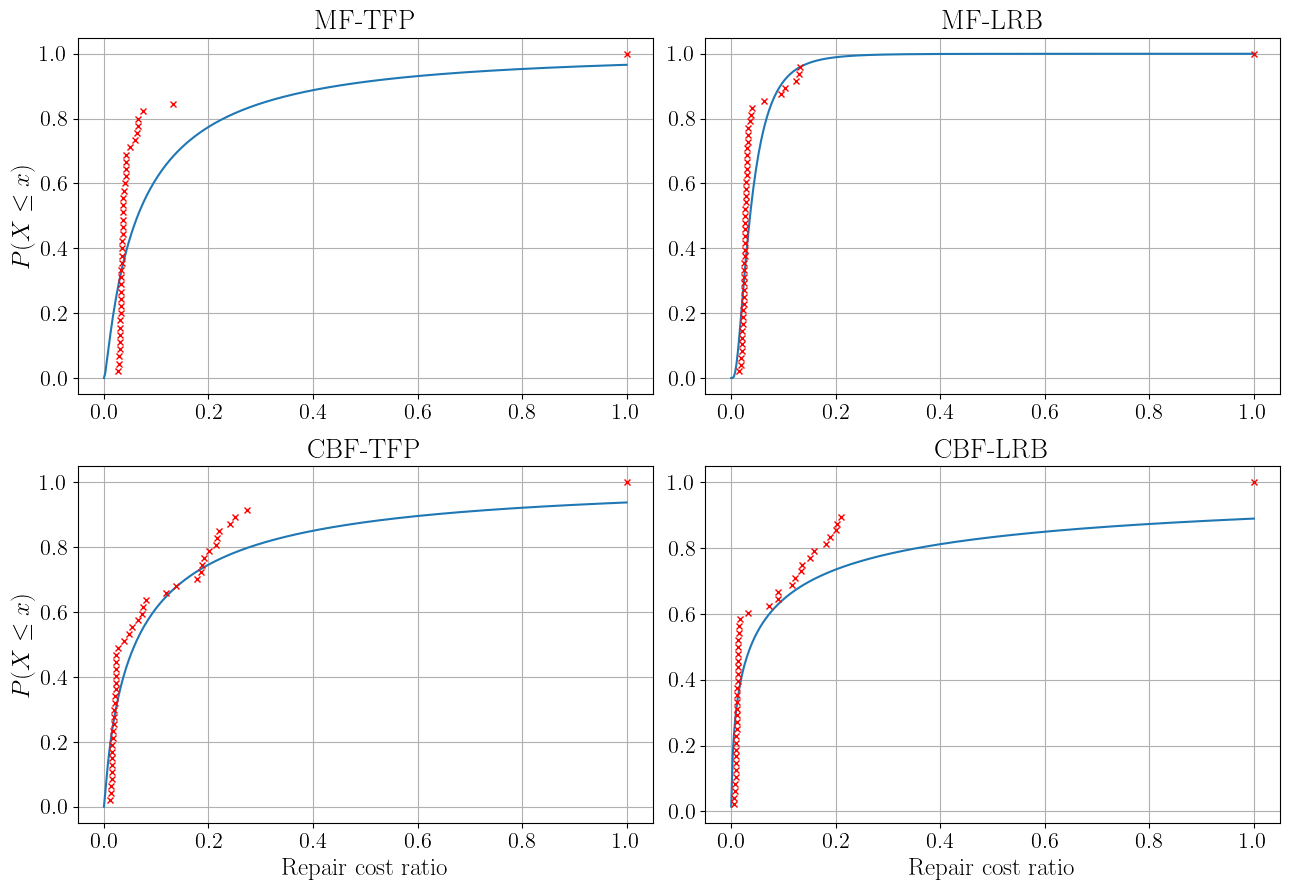

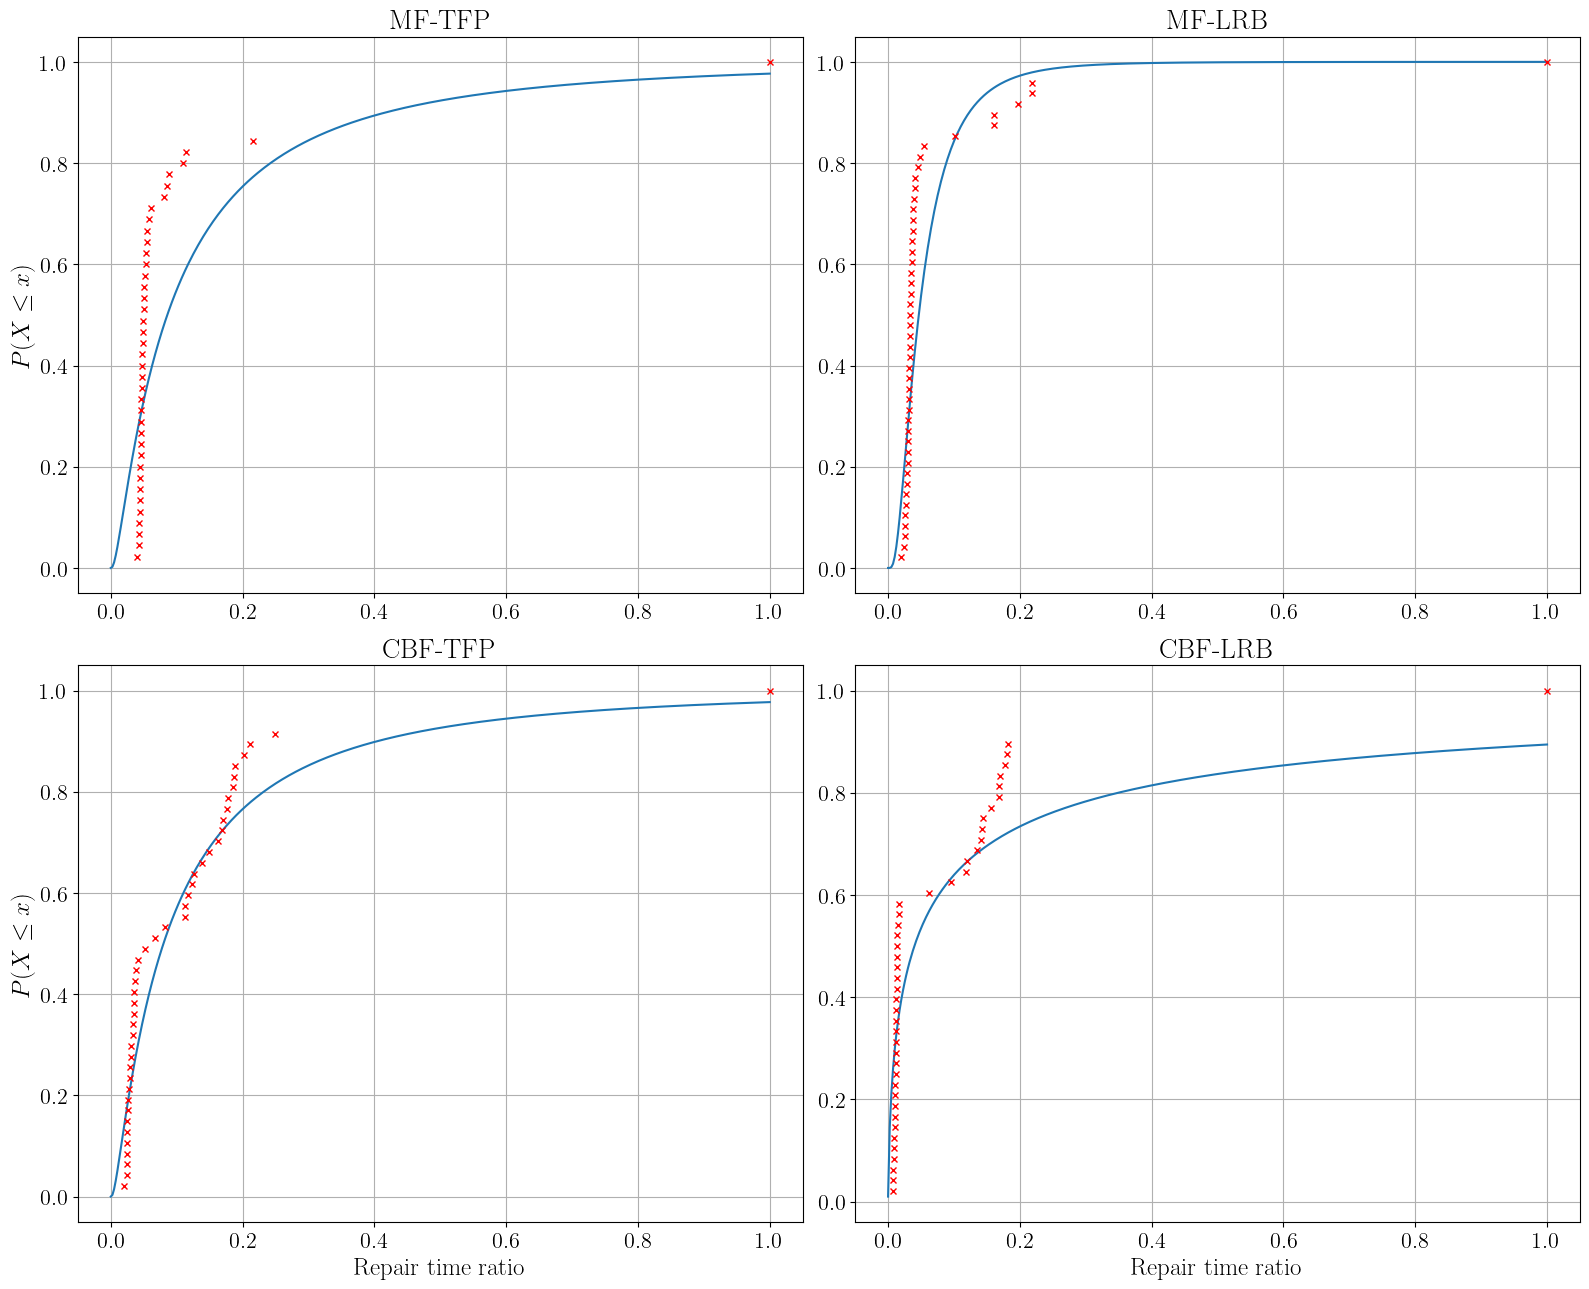

In [34]:
#%% generalized curve fitting for cost and time

# TODO: should this be real values ($)

def nlls(params, log_x, no_a, no_c):
    from scipy import stats
    import numpy as np
    sigma, beta = params
    theoretical_fragility_function = stats.norm(np.log(sigma), beta).cdf(log_x)
    likelihood = stats.binom.pmf(no_c, no_a, theoretical_fragility_function)
    log_likelihood = np.log(likelihood)
    log_likelihood_sum = np.sum(log_likelihood)

    return -log_likelihood_sum

def mle_fit_general(x_values, probs, x_init=None):
    from functools import partial
    import numpy as np
    from scipy.optimize import basinhopping
    
    log_x = np.log(x_values)
    number_of_analyses = 1000*np.ones(len(x_values))
    number_of_collapses = np.round(1000*probs)
    
    neg_log_likelihood_sum_partial = partial(
        nlls, log_x=log_x, no_a=number_of_analyses, no_c=number_of_collapses)
    
    if x_init is None:
        x0 = (1, 1)
    else:
        x0 = x_init
    
    bnds = ((1e-6, 0.2), (0.5, 1.5))
    
    # use basin hopping to avoid local minima
    minimizer_kwargs={'bounds':bnds}
    res = basinhopping(neg_log_likelihood_sum_partial, x0, minimizer_kwargs=minimizer_kwargs,
                       niter=10, seed=985)
    
    return res.x[0], res.x[1]

from scipy.stats import ecdf
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))
# plt.close('all')

# moderate designs
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

my_y_var = mf_tfp_ida[cost_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 16
title_font=20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(13, 9))

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),0.5))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p)

ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
# ax1.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax1.set_title('MF-TFP', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = mf_lrb_ida[cost_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),0.25))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 2)
ax1.plot(xx_pr, p)

# ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
# ax1.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax1.set_title('MF-LRB', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = cbf_tfp_ida[cost_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),1))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 3)
ax1.plot(xx_pr, p)

ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
ax1.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax1.set_title('CBF-TFP', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = cbf_lrb_ida[cost_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),1))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 4)
ax1.plot(xx_pr, p)

# ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
ax1.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax1.set_title('CBF-LRB', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

fig.tight_layout()
plt.show()

#%%

# plt.close('all')
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 16
title_font=20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

my_y_var = mf_tfp_ida[time_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

fig = plt.figure(figsize=(16, 13))

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),0.5))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p)

ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
# ax1.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax1.set_title('MF-TFP', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = mf_lrb_ida[time_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles


# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),0.5))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 2)
ax1.plot(xx_pr, p)

# ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
# ax1.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax1.set_title('MF-LRB', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = cbf_tfp_ida[time_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles


# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),1))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 3)
ax1.plot(xx_pr, p)

ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
ax1.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax1.set_title('CBF-TFP', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

####

my_y_var = cbf_lrb_ida[time_var]
res = ecdf(my_y_var)
ecdf_prob = res.cdf.probabilities
ecdf_values = res.cdf.quantiles

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 16
title_font=20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# theta_inv, beta_inv = mle_fit_general(
#     ecdf_values,ecdf_prob, x_init=(np.median(ecdf_values),1))

theta_inv = np.exp(np.log(my_y_var).mean())
beta_inv = np.log(my_y_var).var()

xx_pr = np.linspace(1e-4, 1.0, 400)
p = f(xx_pr, theta_inv, beta_inv)

ax1=fig.add_subplot(2, 2, 4)
ax1.plot(xx_pr, p)

# ax1.set_ylabel(r'$P(X \leq x)$', fontsize=axis_font)
ax1.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax1.set_title('CBF-LRB', fontsize=title_font)
ax1.plot([ecdf_values], [ecdf_prob], 
          marker='x', markersize=5, color="red")
ax1.grid(True)
# ax1.set_xlim([0, 1.0])
# ax1.set_ylim([0, 1.0])

fig.tight_layout()


## Cost breakdown

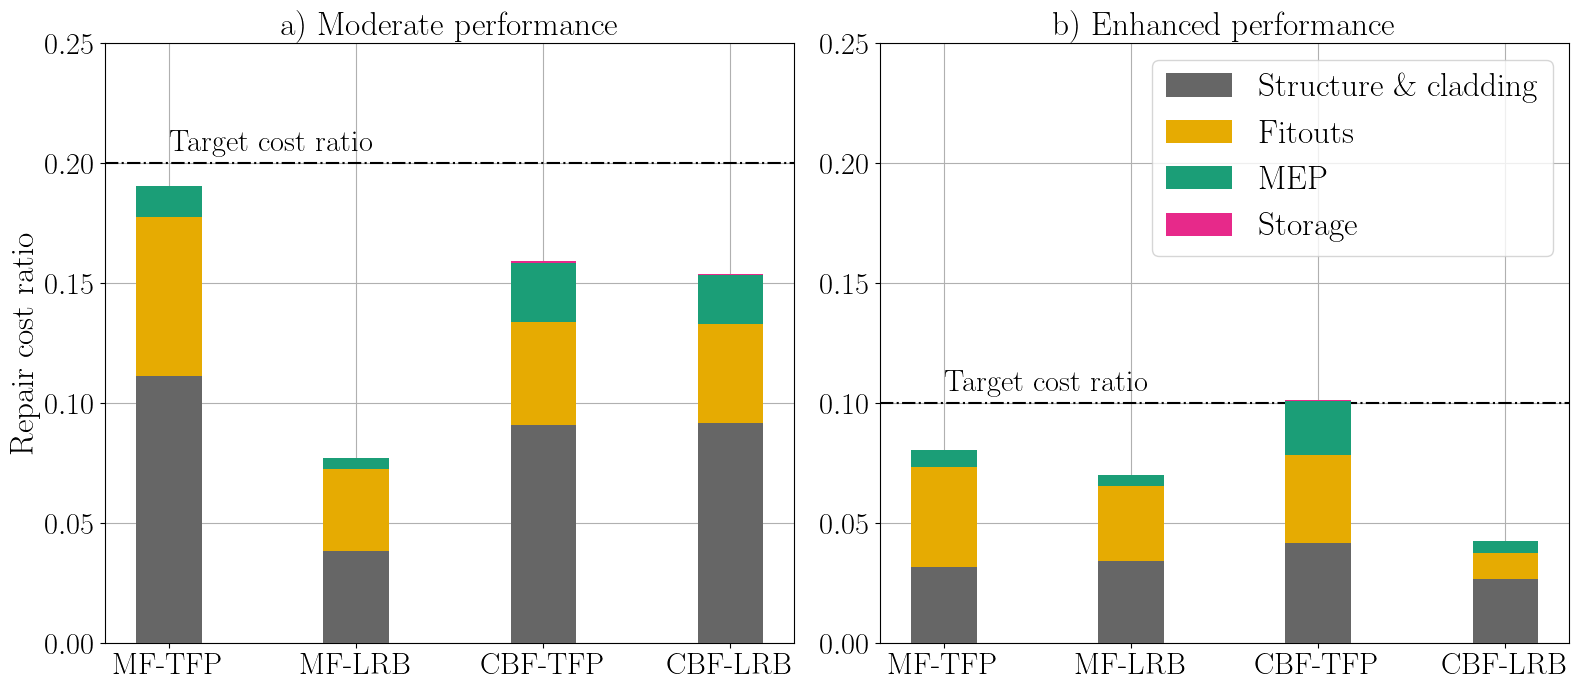

In [72]:

# TODO: component breakdown
def component_fractions(loss_df):
    
    loss_df['cost_50%'] = loss_df['cmp_cost_ratio'] * loss_df['total_cmp_cost']
    loss_df['cost_compare'] = loss_df['B_50%'] + loss_df['C_50%'] + loss_df['D_50%'] + loss_df['E_50%'] 
    loss_df['difference'] = loss_df['cost_50%'] / loss_df['cost_compare']
    
    
    loss_df['B_frac'] = loss_df['B_50%']*loss_df['difference'] / loss_df['total_cmp_cost']
    loss_df['C_frac'] = loss_df['C_50%']*loss_df['difference'] / loss_df['total_cmp_cost']
    loss_df['D_frac'] = loss_df['D_50%']*loss_df['difference'] / loss_df['total_cmp_cost']
    loss_df['E_frac'] = loss_df['E_50%']*loss_df['difference'] / loss_df['total_cmp_cost']
    
    # loss_df['B_frac'] = loss_df['B_50%'] / loss_df['total_cmp_cost']
    # loss_df['C_frac'] = loss_df['C_50%'] / loss_df['total_cmp_cost']
    # loss_df['D_frac'] = loss_df['D_50%'] / loss_df['total_cmp_cost']
    # loss_df['E_frac'] = loss_df['E_50%'] / loss_df['total_cmp_cost']
    
    df_stack_bars = loss_df[['B_frac', 'C_frac', 'D_frac', 'E_frac']].mean()
    
    # df['cmp_cost_ratio'].mean()
    
    return df_stack_bars
# labels=['<10\%', '10-90%', '>90\%']
# bins = pd.IntervalIndex.from_tuples([(-0.001, 0.1), (0.1, 0.9), (0.9, 1.0)])
# df['bin'] = pd.cut(df['replacement_freq'], bins=bins, labels=labels)

# df['B_frac'] = df['B_50%'] / df['total_cmp_cost']
# df['C_frac'] = df['C_50%'] / df['total_cmp_cost']
# df['D_frac'] = df['D_50%'] / df['total_cmp_cost']
# df['E_frac'] = df['E_50%'] / df['total_cmp_cost']

# df_stack_bars = df.groupby('bin')[[
#     'B_frac', 'C_frac', 'D_frac', 'E_frac']].mean()

##### moderate designs
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

mf_tfp_components = component_fractions(mf_tfp_ida)
mf_lrb_components = component_fractions(mf_lrb_ida)
cbf_tfp_components = component_fractions(cbf_tfp_ida)
cbf_lrb_components = component_fractions(cbf_lrb_ida)

df_stack = pd.DataFrame({'MF-TFP':mf_tfp_components, 'MF-LRB':mf_lrb_components,
                        'CBF-TFP':cbf_tfp_components, 'CBF-LRB':cbf_lrb_components}).T


# plt.close('all')

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
label_size = 22
title_font=24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 2, 1)
systems = ['MF-TFP', 'MF-LRB', 'CBF-TFP', 'CBF-LRB']
category_name = ['Structure \& cladding',
                 'Fitouts',
                 'MEP',
                 'Storage']
colorlist = [7, 5, 0, 3]
ax.grid(visible=True, zorder=0)
cmap = plt.cm.Dark2

bottom = np.zeros(4)
i = 0
for boolean, category in df_stack.items():
    p = ax.bar(systems, category, width=0.35, label=category_name[i], bottom=bottom,
               zorder=3, color=cmap(colorlist[i]))
    bottom += category
    i += 1
    
ax.axhline(0.2, linestyle='-.', color='black', linewidth=1.5)
ax.text(0.0, 0.205, r'Target cost ratio', fontsize=subt_font, color='black')
ax.set_ylabel("Repair cost ratio", fontsize=axis_font)
# ax.set_xlabel('System', fontsize=axis_font)
ax.set_title('a) Moderate performance', fontsize=title_font)
ax.set_ylim([0, 0.25])


#### enhanced designs
cbf_tfp_ida = cbf_tfp_strict_results[cbf_tfp_strict_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_strict_results[mf_tfp_strict_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_strict_results[cbf_lrb_strict_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_strict_results[mf_lrb_strict_results['ida_level']==1.0]

a = cbf_lrb_ida['PFA']

a1 = cbf_lrb_ida['sa_tm'].mean()
a2 = cbf_tfp_ida['sa_tm'].mean()

mf_tfp_components = component_fractions(mf_tfp_ida)
mf_lrb_components = component_fractions(mf_lrb_ida)
cbf_tfp_components = component_fractions(cbf_tfp_ida)
cbf_lrb_components = component_fractions(cbf_lrb_ida)

df_stack = pd.DataFrame({'MF-TFP':mf_tfp_components, 'MF-LRB':mf_lrb_components,
                        'CBF-TFP':cbf_tfp_components, 'CBF-LRB':cbf_lrb_components}).T

ax = fig.add_subplot(1, 2, 2)
# risks = ['$<10\%$', '$10-90\%$', '$>90\%$']
ax.grid(visible=True, zorder=0)
bottom = np.zeros(4)
i = 0
for boolean, category in df_stack.items():
    p = ax.bar(systems, category, width=0.35, label=category_name[i], bottom=bottom,
               zorder=3, color=cmap(colorlist[i]))
    bottom += category
    i += 1
# ax.set_ylabel("Repair cost ratio", fontsize=axis_font)
ax.axhline(0.1, linestyle='-.', color='black', linewidth=1.5)
ax.text(0.0, 0.105, r'Target cost ratio', fontsize=subt_font, color='black')
ax.set_ylim([0, 0.25])
# ax.set_xlabel('System', fontsize=axis_font)
ax.set_title('b) Enhanced performance', fontsize=title_font)

ax.legend(fontsize=axis_font)

fig.tight_layout()

plt.savefig('./eng_struc_figures/cost_breakdown_eesd.pdf')
plt.show()

## System selection

In [36]:

# consider: replacement freq, num_stories, num_bays, repair cost
covariate_list_sys = ['cmp_cost_ratio', 'steel_cost_per_sf']
clf_struct = GP(df)
clf_struct.set_covariates(covariate_list_sys)
clf_struct.set_outcome('superstructure_system', use_ravel=False)
clf_struct.test_train_split(0.2)
clf_struct.fit_ensemble()
# clf_struct.fit_svc(neg_wt=False)
clf_struct.fit_gpc(kernel_name='rbf_iso')
# clf_struct.fit_kernel_logistic(kernel_name='rbf', neg_wt=False)
# clf_struct.fit_dt()

# clf_isol = GP(df)
# clf_isol.set_covariates(covariate_list_sys)
# clf_isol.set_outcome('isolator_system', use_ravel=False)
# clf_isol.test_train_split(0.2)
# clf_isol.fit_ensemble()
# clf_isol.fit_svc(neg_wt=False)
# clf_isol.fit_gpc(kernel_name='rbf_iso')
# clf_isol.fit_kernel_logistic(kernel_name='rbf', neg_wt=False)


Current ensembling method is RandomForestClassifier'>
The ensemble training score is 0.993
The ensemble testing score is 0.715
The GP training score is 0.777
The GP testing score is 0.720


### plot

The GP training score is 0.716
The GP testing score is 0.695
The GP training score is 0.733
The GP testing score is 0.725


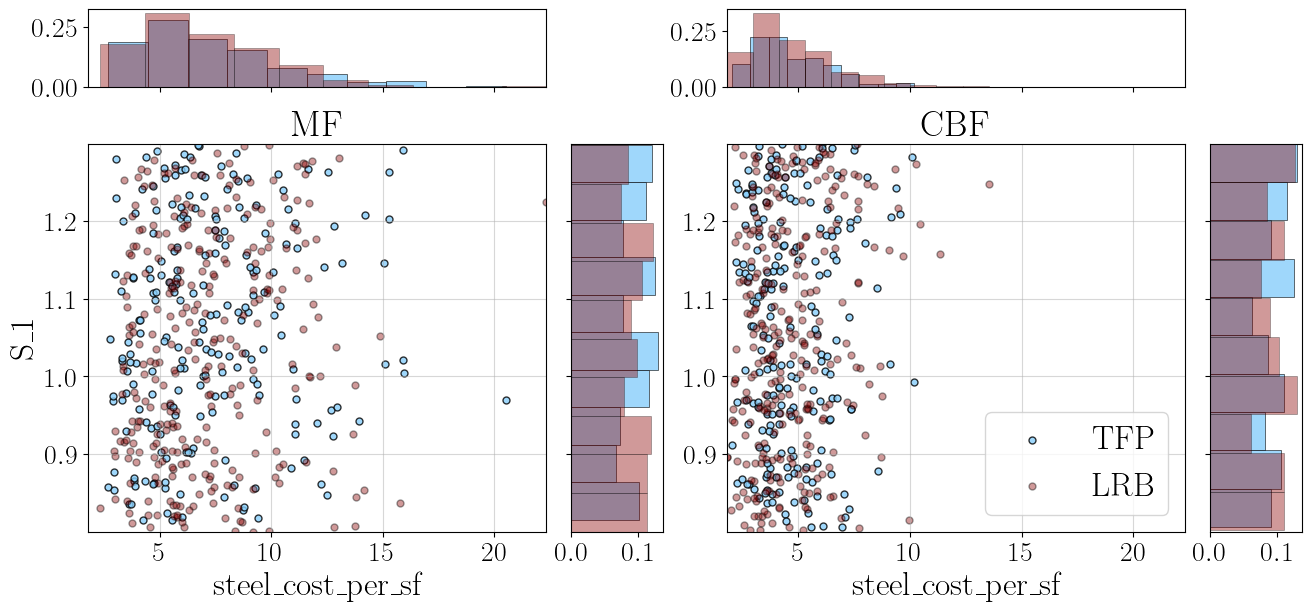

In [37]:

#%%
plt.close('all')
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 26
subt_font = 24
label_size = 24
title_font = 26
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


kernel_name = 'rbf_ard'

fig = plt.figure(figsize=(13, 6))

color = plt.cm.Set1(np.linspace(0, 1, 10))



#################################
# # xvar = 'cmp_cost_ratio'
# # yvar = 'replacement_freq'

# yvar = 'replacement_freq'
# xvar = 'steel_cost_per_sf'

# # fit
# covariate_list_sys = [yvar, xvar]
# clf_struct = GP(df)
# clf_struct.set_covariates(covariate_list_sys)
# clf_struct.set_outcome('superstructure_system', use_ravel=False)
# clf_struct.test_train_split(0.2)
# clf_struct.fit_gpc(kernel_name=kernel_name)


# res = 75

# x_min = min(clf_struct.X[xvar])
# x_max = max(clf_struct.X[xvar])

# y_min = min(clf_struct.X[yvar])
# y_max = max(clf_struct.X[yvar])


# xx, yy = np.meshgrid(np.linspace(x_min,
#                                  x_max,
#                                  res),
#                      np.linspace(y_min,
#                                  y_max,
#                                  res))

# X_pl = pd.DataFrame({xvar:xx.ravel(),
#                      yvar:yy.ravel()})
# X_plot = X_pl[covariate_list_sys]

# # X_plot = make_2D_plotting_space(clf_struct.X, res, x_var=xvar, y_var=yvar,
# #                                 all_vars=covariate_list_sys,
# #                                 third_var_set = 0.2, fourth_var_set = 0.2)






# xx = X_plot[xvar]
# yy = X_plot[yvar]
# Z = clf_struct.gpc.predict(X_plot)

# lookup_table, Z_numbered = np.unique(Z, return_inverse=True)
# x_pl = np.unique(xx)
# y_pl = np.unique(yy)

# Z_numbered = clf_struct.gpc.predict_proba(X_plot)[:,1]
# xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)
# Z_classif = Z_numbered.reshape(xx_pl.shape)

# plt.contour(xx_pl, yy_pl, Z_classif, levels=[0.5], linestyles='dashed',
#             colors='black', linewidths=1.5)

# plt.imshow(
#         Z_classif,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.coolwarm_r,
#     )

# ax.scatter(df_cbf[xvar], df_cbf[yvar], color=color[0],
#             edgecolors='k', alpha = 0.6, label='CBF', marker='^')
# ax.scatter(df_mf[xvar], df_mf[yvar], color=color[1],
#             edgecolors='k', alpha = 0.6, label='MF', marker='^')
# plt.legend(fontsize=axis_font)

# ax.set_title(r'a) Replacement', fontsize=title_font)
# ax.set_ylabel(r'Replacement probability', fontsize=axis_font)
# ax.set_xlabel(r'Steel cost per ft$^2$', fontsize=axis_font)

#################################


yvar = 'cmp_time_ratio'
xvar = 'upfront_cost_per_sm'

# fit
covariate_list_sys = [yvar, xvar]
clf_struct = GP(df)
clf_struct.set_covariates(covariate_list_sys)
clf_struct.set_outcome('superstructure_system', use_ravel=False)
clf_struct.test_train_split(0.2)
clf_struct.fit_gpc(kernel_name=kernel_name)


res = 75

x_min = min(clf_struct.X[xvar])
x_max = max(clf_struct.X[xvar])

y_min = min(clf_struct.X[yvar])
y_max = max(clf_struct.X[yvar])


xx, yy = np.meshgrid(np.linspace(x_min,
                                 x_max,
                                 res),
                     np.linspace(y_min,
                                 y_max,
                                 res))

X_pl = pd.DataFrame({xvar:xx.ravel(),
                     yvar:yy.ravel()})
X_plot = X_pl[covariate_list_sys]

# X_plot = make_2D_plotting_space(clf_struct.X, res, x_var=xvar, y_var=yvar,
#                                 all_vars=covariate_list_sys,
#                                 third_var_set = 0.2, fourth_var_set = 0.2)



ax=fig.add_subplot(1, 2, 1)



xx = X_plot[xvar]
yy = X_plot[yvar]
Z = clf_struct.gpc.predict(X_plot)

lookup_table, Z_numbered = np.unique(Z, return_inverse=True)
x_pl = np.unique(xx)
y_pl = np.unique(yy)

Z_numbered = clf_struct.gpc.predict_proba(X_plot)[:,1]
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)
Z_classif = Z_numbered.reshape(xx_pl.shape)

plt.contour(xx_pl, yy_pl, Z_classif, levels=[0.5], linestyles='dashed',
            colors='black', linewidths=1.5)

plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm_r,
    )

ax.scatter(df_cbf[xvar], df_cbf[yvar], color=color[0],
            edgecolors='k', alpha = 0.6, label='CBF', marker='^')
ax.scatter(df_mf[xvar], df_mf[yvar], color=color[1],
            edgecolors='k', alpha = 0.6, label='MF', marker='^')

# ax.scatter(df_cbf_i[xvar], df_cbf_i[yvar], color=color[0],
#             edgecolors='k', alpha = 0.6, label='CBF', marker='^')
# ax.scatter(df_mf_i[xvar], df_mf_i[yvar], color=color[1],
#             edgecolors='k', alpha = 0.6, label='MF', marker='^')

# ax.scatter(df_cbf_o[xvar], df_cbf_o[yvar], color=color[0],
#             edgecolors='k', alpha = 0.6, label='CBF', marker='o')
# ax.scatter(df_mf_o[xvar], df_mf_o[yvar], color=color[1],
#             edgecolors='k', alpha = 0.6, label='MF', marker='o')
# plt.legend(fontsize=axis_font)

ax.set_title(r'a) Downtime', fontsize=title_font)
ax.set_xlabel(r'Upfront cost per m$^2$ (USD)', fontsize=axis_font)
ax.set_ylabel(r'Downtime ratio', fontsize=axis_font)


#################################
yvar = 'cmp_cost_ratio'
xvar = 'upfront_cost_per_sm'


# fit
covariate_list_sys = [yvar, xvar]
clf_struct = GP(df)
clf_struct.set_covariates(covariate_list_sys)
clf_struct.set_outcome('superstructure_system', use_ravel=False)
clf_struct.test_train_split(0.2)
clf_struct.fit_gpc(kernel_name=kernel_name)


res = 75

x_min = min(clf_struct.X[xvar])
x_max = max(clf_struct.X[xvar])

y_min = min(clf_struct.X[yvar])
y_max = max(clf_struct.X[yvar])


xx, yy = np.meshgrid(np.linspace(x_min,
                                 x_max,
                                 res),
                     np.linspace(y_min,
                                 y_max,
                                 res))

X_pl = pd.DataFrame({xvar:xx.ravel(),
                     yvar:yy.ravel()})
X_plot = X_pl[covariate_list_sys]

# X_plot = make_2D_plotting_space(clf_struct.X, res, x_var=xvar, y_var=yvar,
#                                 all_vars=covariate_list_sys,
#                                 third_var_set = 0.2, fourth_var_set = 0.2)



ax=fig.add_subplot(1, 2, 2)



xx = X_plot[xvar]
yy = X_plot[yvar]
Z = clf_struct.gpc.predict(X_plot)

lookup_table, Z_numbered = np.unique(Z, return_inverse=True)
x_pl = np.unique(xx)
y_pl = np.unique(yy)

Z_numbered = clf_struct.gpc.predict_proba(X_plot)[:,1]
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)
Z_classif = Z_numbered.reshape(xx_pl.shape)

plt.contour(xx_pl, yy_pl, Z_classif, levels=[0.5], linestyles='dashed',
            colors='black', linewidths=1.5)

plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm_r,
    )


ax.scatter(df_cbf[xvar], df_cbf[yvar], color=color[0],
            edgecolors='k', alpha = 0.6, label='CBF', marker='^')
ax.scatter(df_mf[xvar], df_mf[yvar], color=color[1],
            edgecolors='k', alpha = 0.6, label='MF', marker='^')

# ax.scatter(df_cbf_i[xvar], df_cbf_i[yvar], color=color[0],
#             edgecolors='k', alpha = 0.6, label='CBF', marker='^')
# ax.scatter(df_mf_i[xvar], df_mf_i[yvar], color=color[1],
#             edgecolors='k', alpha = 0.6, label='MF', marker='^')

# ax.scatter(df_cbf_o[xvar], df_cbf_o[yvar], color=color[0],
#             edgecolors='k', alpha = 0.6, label='CBF', marker='o')
# ax.scatter(df_mf_o[xvar], df_mf_o[yvar], color=color[1],
#             edgecolors='k', alpha = 0.6, label='MF', marker='o')

# plt.legend(fontsize=axis_font)

ax.set_title(r'b) Repair cost', fontsize=title_font)
ax.set_xlabel(r'Upfront cost per m$^2$ (USD)', fontsize=axis_font)
ax.set_ylabel(r'Repair cost ratio', fontsize=axis_font)

from matplotlib.lines import Line2D
custom_lines = [Line2D([-1], [-1], color='white', marker='^', markeredgecolor='k',
                       alpha=0.6, markerfacecolor=color[0], markersize=10),
                Line2D([-1], [-1], color='white', marker='^', markeredgecolor='k',
                                       alpha=0.6, markerfacecolor=color[1], markersize=10),
                Line2D([-1], [-1], color='black', linestyle='--' ),
                ]

ax.legend(custom_lines, ['CBF','MF','Decision boundary\n (50\% probability)'], 
           fontsize=subt_font)

fig.tight_layout()

# plt.savefig('./eng_struc_figures/fig_17_system_selection_upfront.pdf')

# plt.close('all')

#%%

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.grid(True)
    # ax_histy.grid(True)
    
    # the scatter plot:
    ax.grid(True, alpha=0.5)
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
                label=label)

    n_bins = 10
    ax_histx.hist(x, bins=n_bins, alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
    
    ax_histy.hist(y, bins=n_bins, orientation='horizontal', alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
  
    
xvar = 'steel_cost_per_sf'
yvar = 'S_1'

df_a1 = df_mf[df_mf['S_1'] > 1.1]
df_a2 = df_cbf[df_cbf['S_1'] > 1.1]

# TODO: simpler scatter
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(df_mf_tfp[xvar], df_mf_tfp[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
             label='TFP')
scatter_hist(df_mf_lrb[xvar], df_mf_lrb[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
             label='LRB')
# ax.legend(fontsize=axis_font)

ax.set_title(r'MF', fontsize=title_font)

ax.set_xlabel(xvar, fontsize=axis_font)
ax.set_ylabel(yvar, fontsize=axis_font)
ax.set_xlim([df[xvar].min(), df[xvar].max()])
ax.set_ylim([df[yvar].min(), df[yvar].max()])

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)

# Draw the scatter plot and marginals.

scatter_hist(df_cbf_tfp[xvar], df_cbf_tfp[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
              label='TFP')
scatter_hist(df_cbf_lrb[xvar], df_cbf_lrb[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
              label='LRB')

ax.set_xlim([df[xvar].min(), df[xvar].max()])
ax.set_ylim([df[yvar].min(), df[yvar].max()])

ax.set_title(r'CBF', fontsize=title_font)
ax.set_xlabel(xvar, fontsize=axis_font)

ax.legend(fontsize=axis_font)
